In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

pd.options.mode.chained_assignment = None

In [2]:
# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

# Load data

In [3]:
#we used the first proccessed data cuz we want to retrive again the features that will help us to count repetitions efficiently
df = pd.read_pickle("../../data/interim/O1_data_processed.pkl")
df = df[df["label"]!="rest"]

In [4]:
#sum of squares
acc_r = df["acc_x"]**2 + df["acc_y"]**2 + df["acc_z"]**2
gyr_r = df["gyr_x"]**2 + df["gyr_y"]**2 + df["gyr_z"]**2

df["acc_r"] = np.sqrt(acc_r)
df["gyr_r"] = np.sqrt(gyr_r)

# Split data

In [9]:
bench_df = df[df["label"]=="bench"]
squat_df = df[df["label"]=="squat"]
ohp_df = df[df["label"]=="ohp"]
row_df = df[df["label"]=="row"]
dead_df = df[df["label"]=="dead"]

# Visualize data to identify patterns

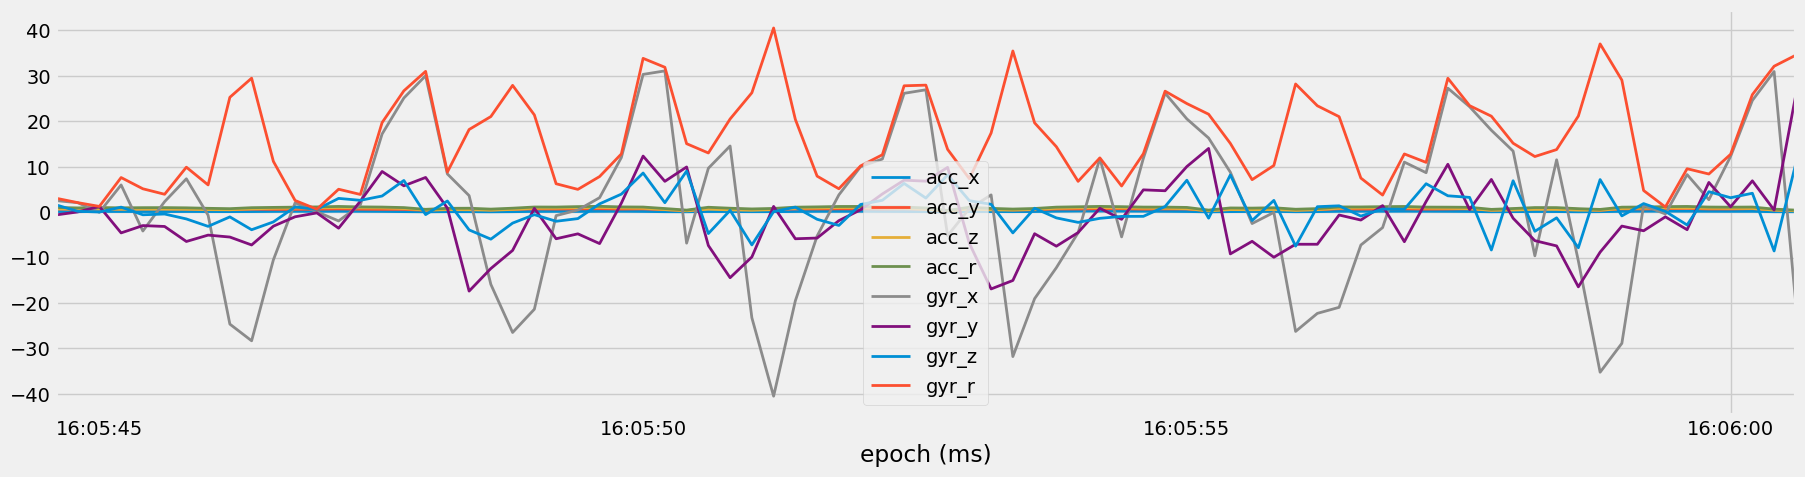

In [10]:
plot_df = squat_df
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_x"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_y"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_z"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_r"].plot()
    
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_x"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_y"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_z"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_r"].plot()
plt.legend()
        

# Configure LowPassFilter

In [7]:
fs = 1000/200
LowPass = LowPassFilter()

<AxesSubplot:xlabel='epoch (ms)'>

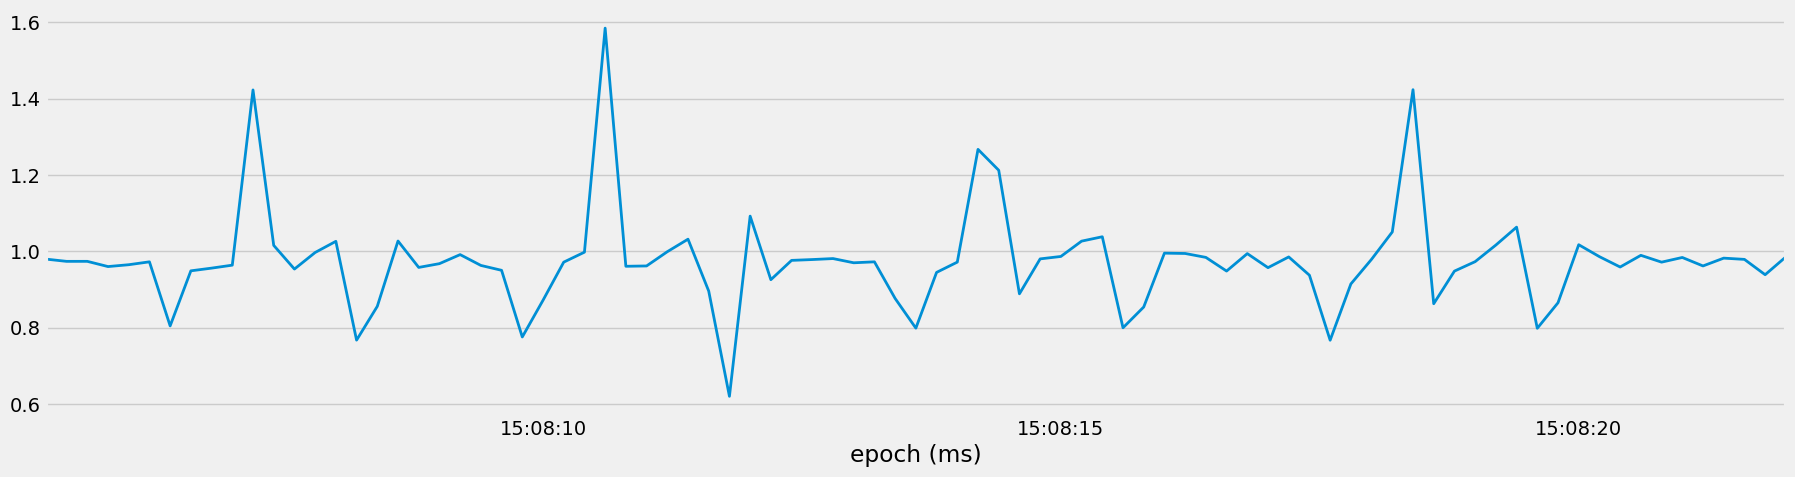

In [13]:
bench_set["acc_r"].plot()

# Apply and tweak LowPassFilter

<AxesSubplot:xlabel='epoch (ms)'>

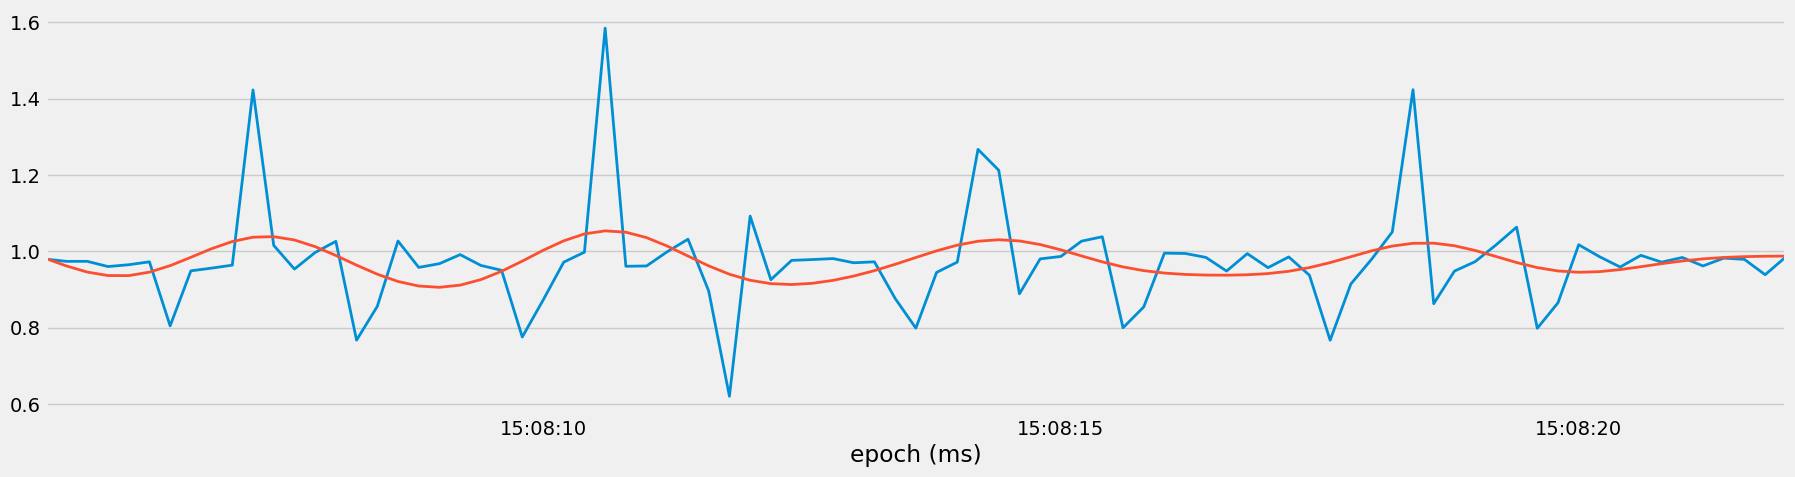

In [ ]:
bench_set = bench_df[bench_df["set"] == bench_df["set"].unique()[0]]
row_set = row_df[row_df["set"] == row_df["set"].unique()[0]]
dead_set = dead_df[dead_df["set"] == dead_df["set"].unique()[0]]
squat_set = squat_df[squat_df["set"] == squat_df["set"].unique()[0]]
ohp_set = ohp_df[ohp_df["set"] == ohp_df["set"].unique()[0]]

#lowpassfiler on the bench_set over, column accr_r
column = "acc_r"
LowPass.low_pass_filter(
        bench_set,
        col = column,
        sampling_frequency = fs,
        cutoff_frequency = 0.4,
        order=5)[column + "_lowpass"].plot()

# Create function to count repetitions

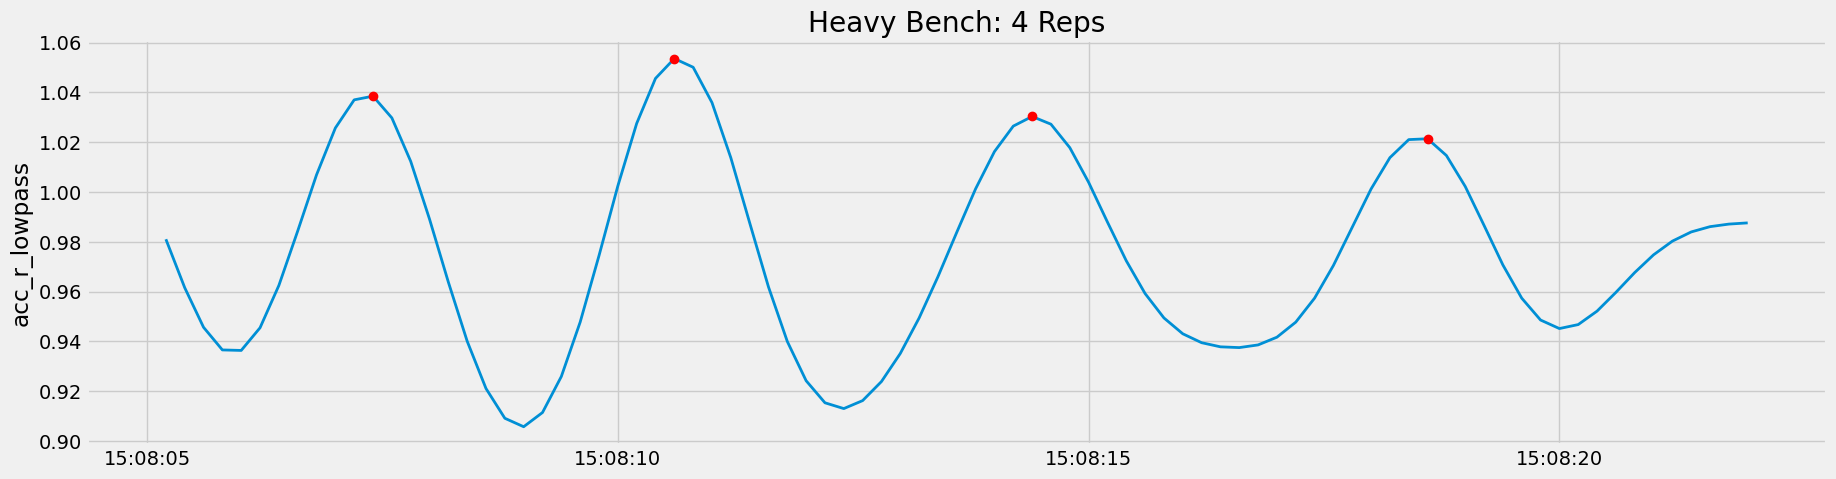

4

In [14]:
def count_rep(dataset, cutoff = 0.4, order =10, column = "acc_r"):
    
    data = LowPass.low_pass_filter(
            dataset,
            col = column,
            sampling_frequency = fs,
            cutoff_frequency = 0.4,
            order=5)
    indexes = argrelextrema(data[column + "_lowpass"].values, np.greater)
    peaks = data.iloc[indexes]
    
    fig, ax  = plt.subplots() 
    plt.plot(dataset[f"{column}_lowpass"])
    plt.plot(peaks[f"{column}_lowpass"], "o", color="red") 
    ax.set_ylabel(f"{column}_lowpass")
    exercise = dataset["label"].iloc[0].title() 
    category = dataset["category"].iloc[0].title()
    plt.title(f"{category} {exercise}: {len(peaks)} Reps")
    plt.show()
    
    return len(peaks)

#test again for each set
count_rep(bench_set, cutoff = 0.4)
#count_rep(row_set, cutoff = 0.65, column = "gyr_x")
#count_rep(dead_set, cutoff = 0.4)
#count_rep(squat_set, cutoff = 0.35)
#count_rep(ohp_set, cutoff = 0.35)

# Create benchmark dataframe

In [15]:
df["reps"] = df["category"].apply(lambda x: 5 if x=="heavy" else 10)

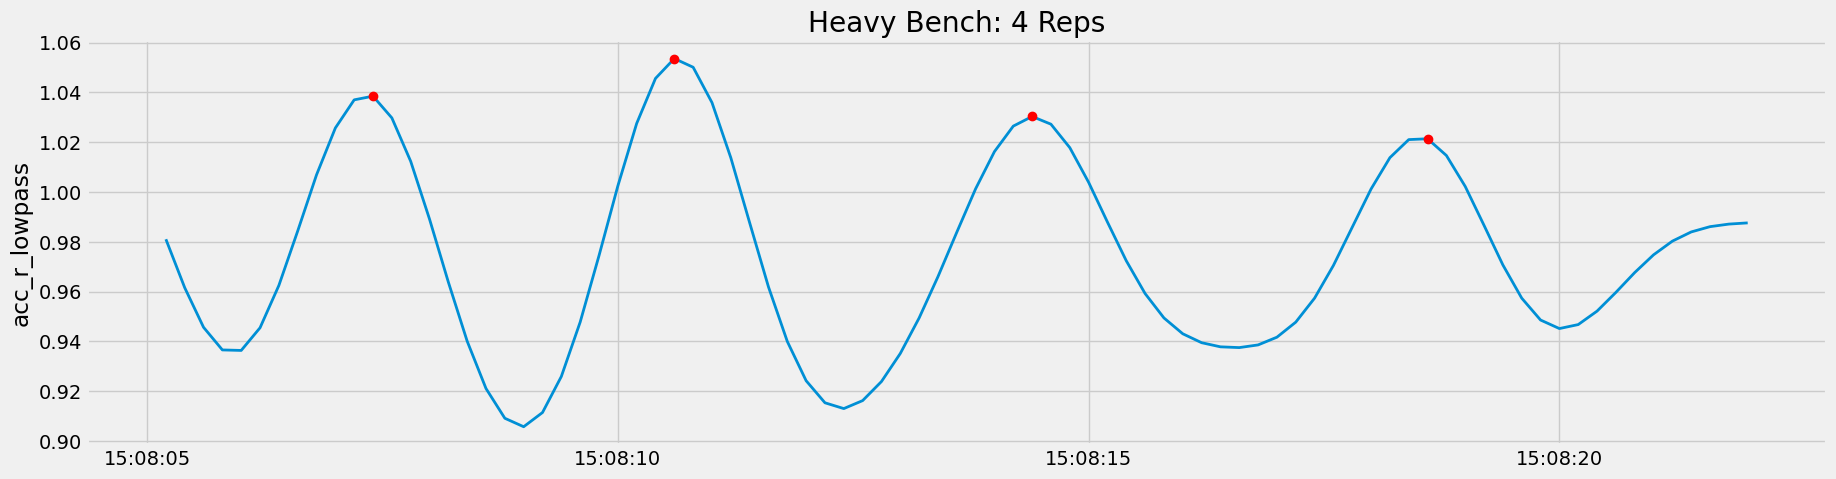

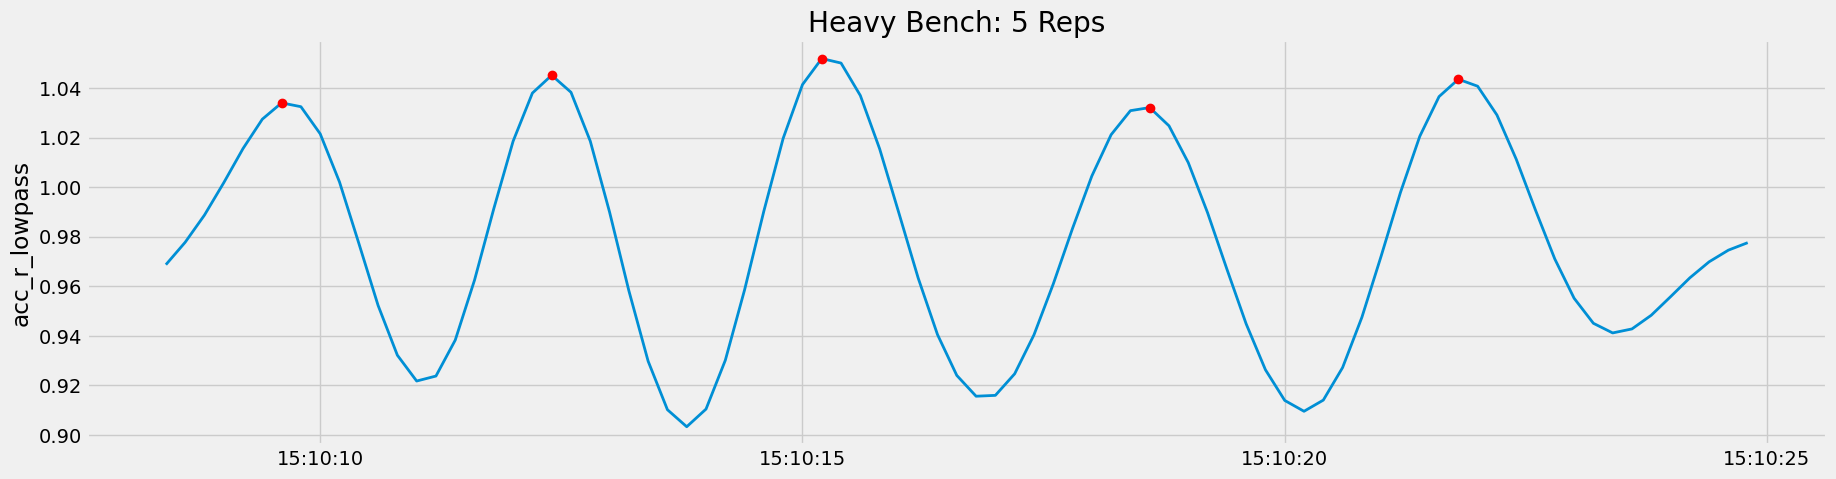

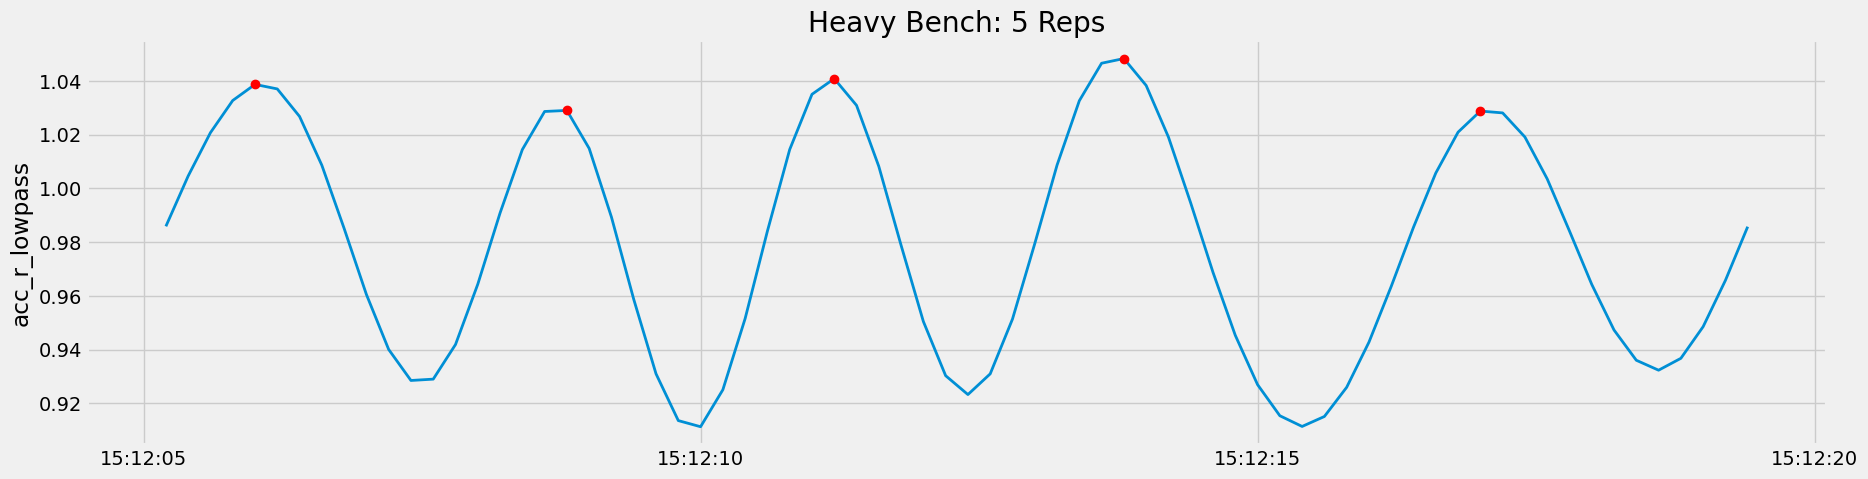

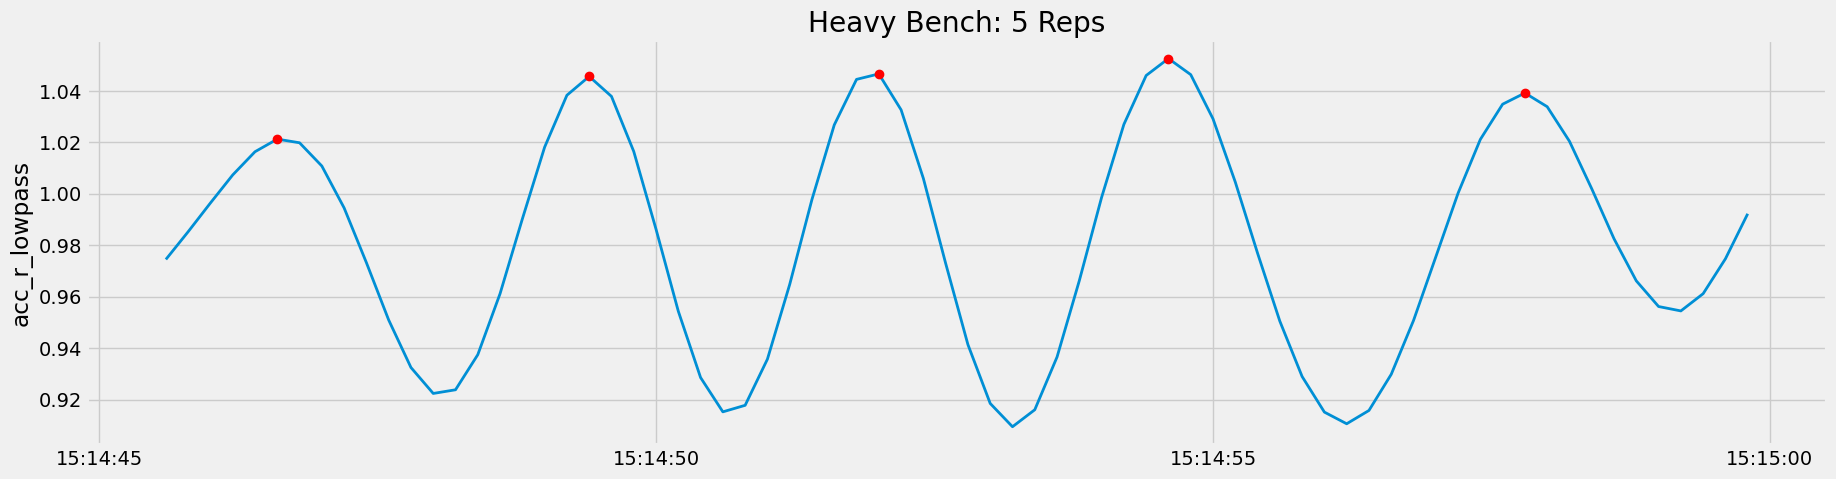

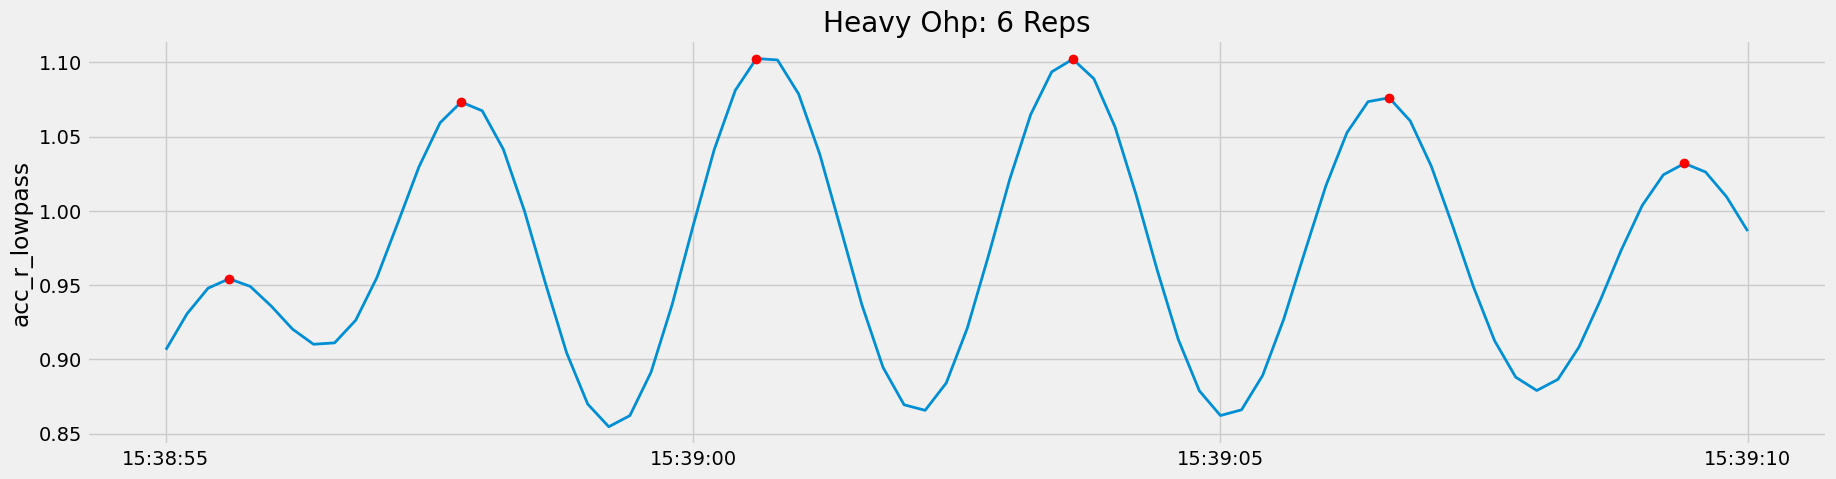

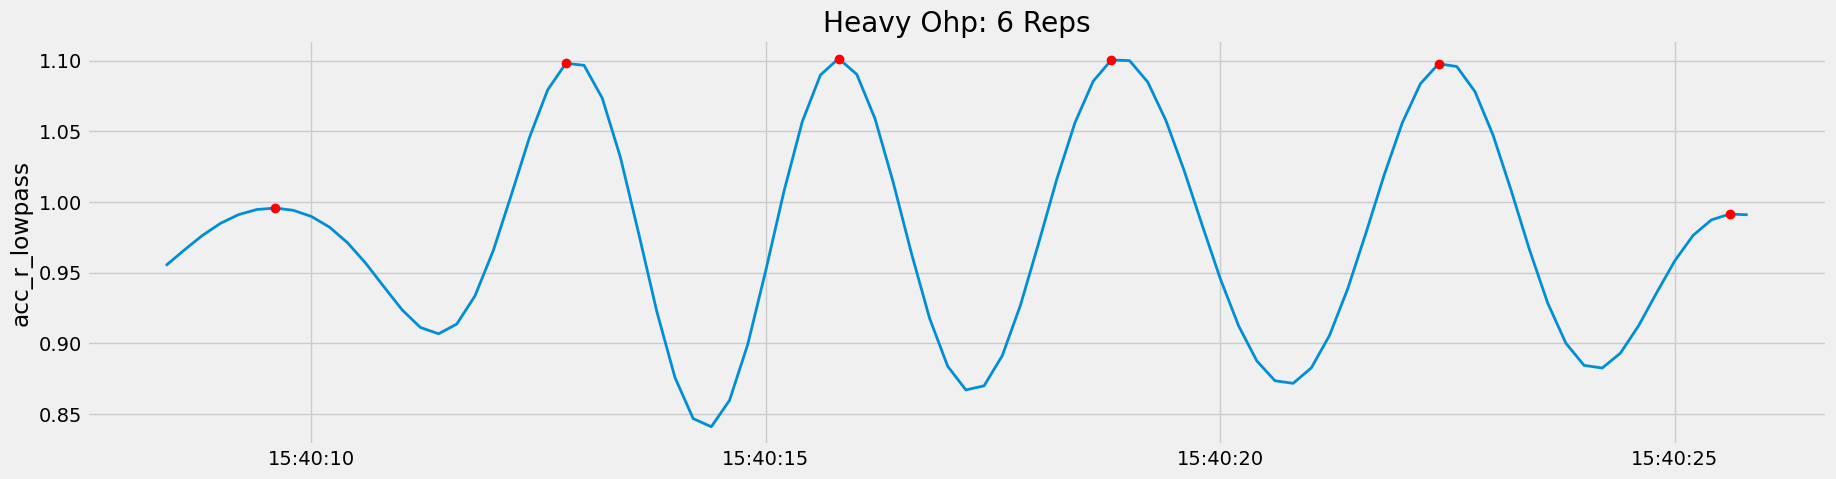

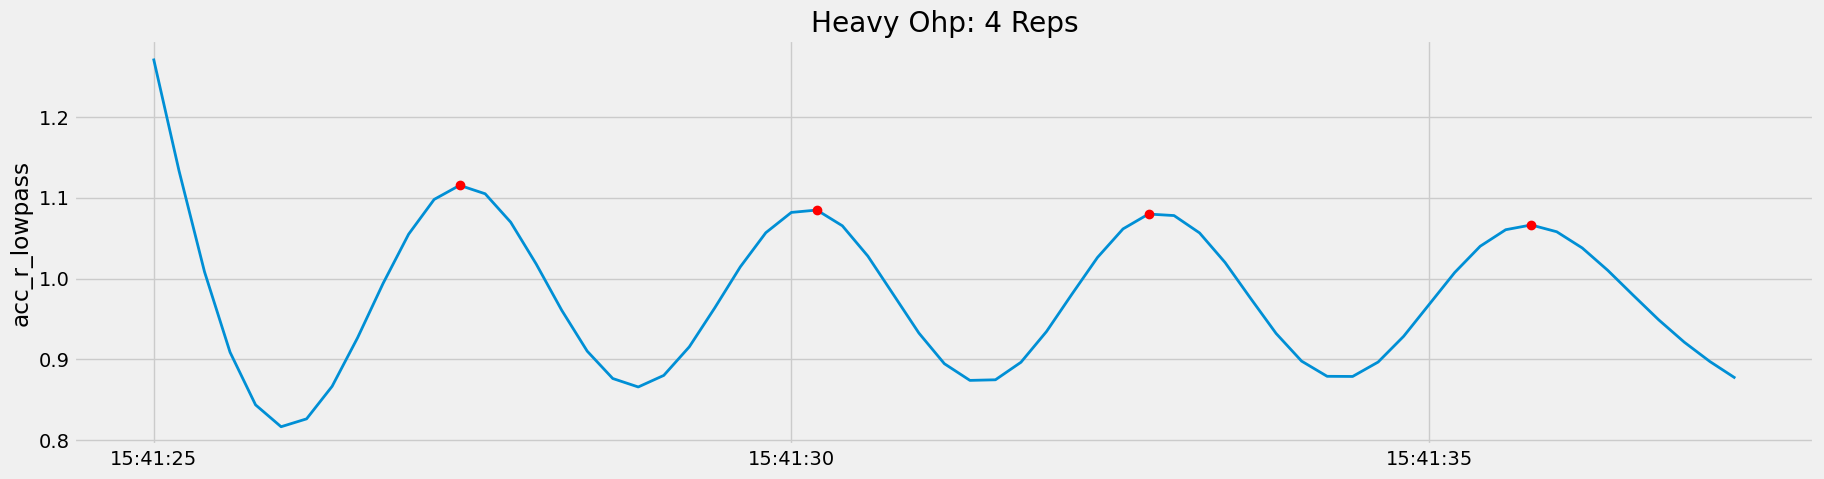

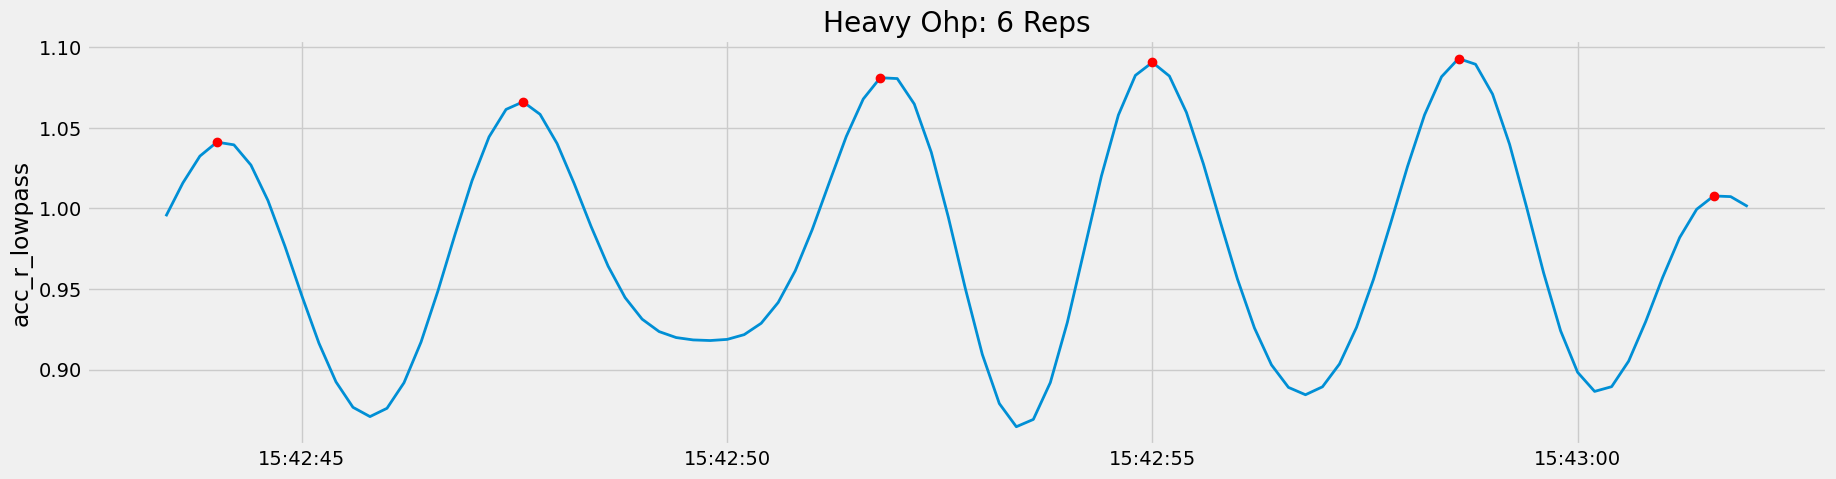

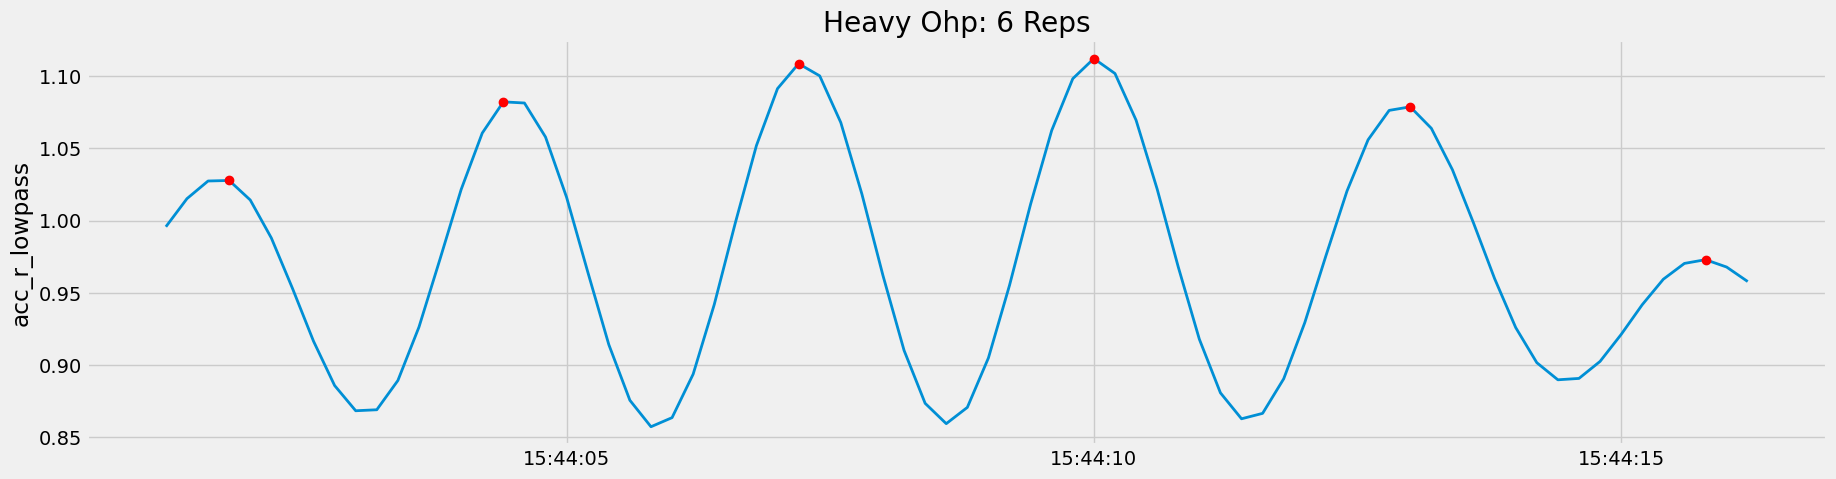

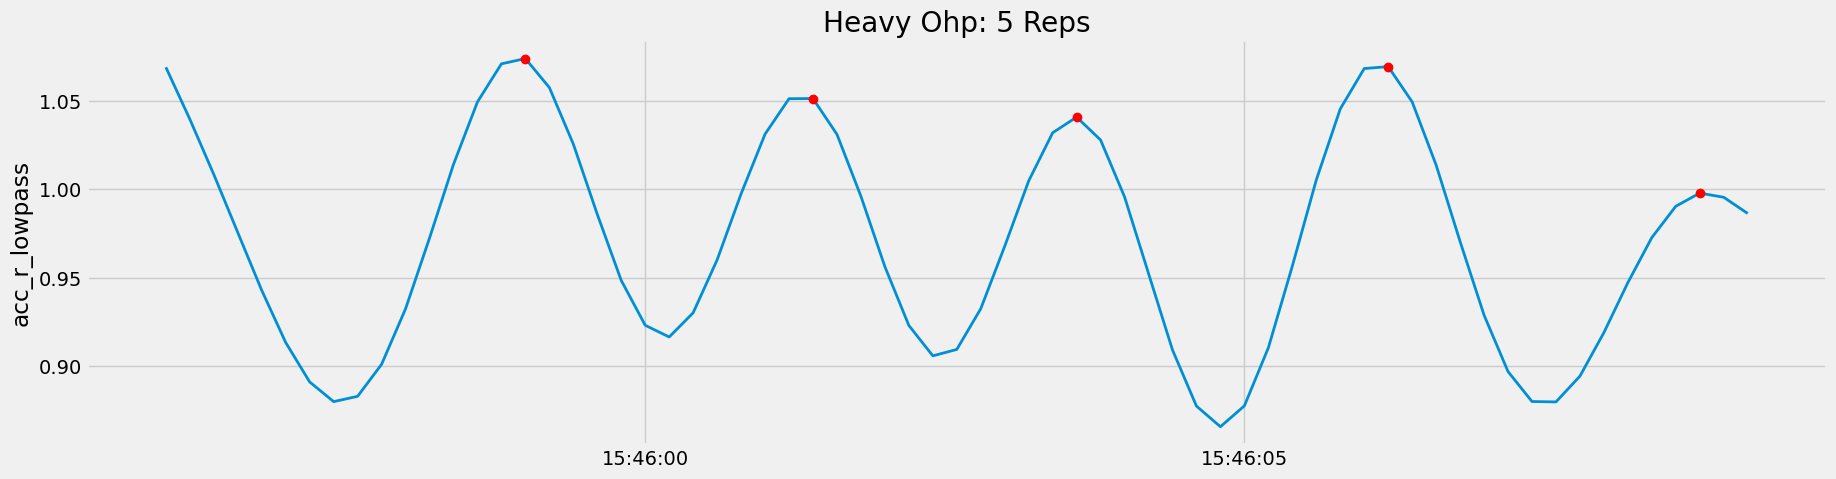

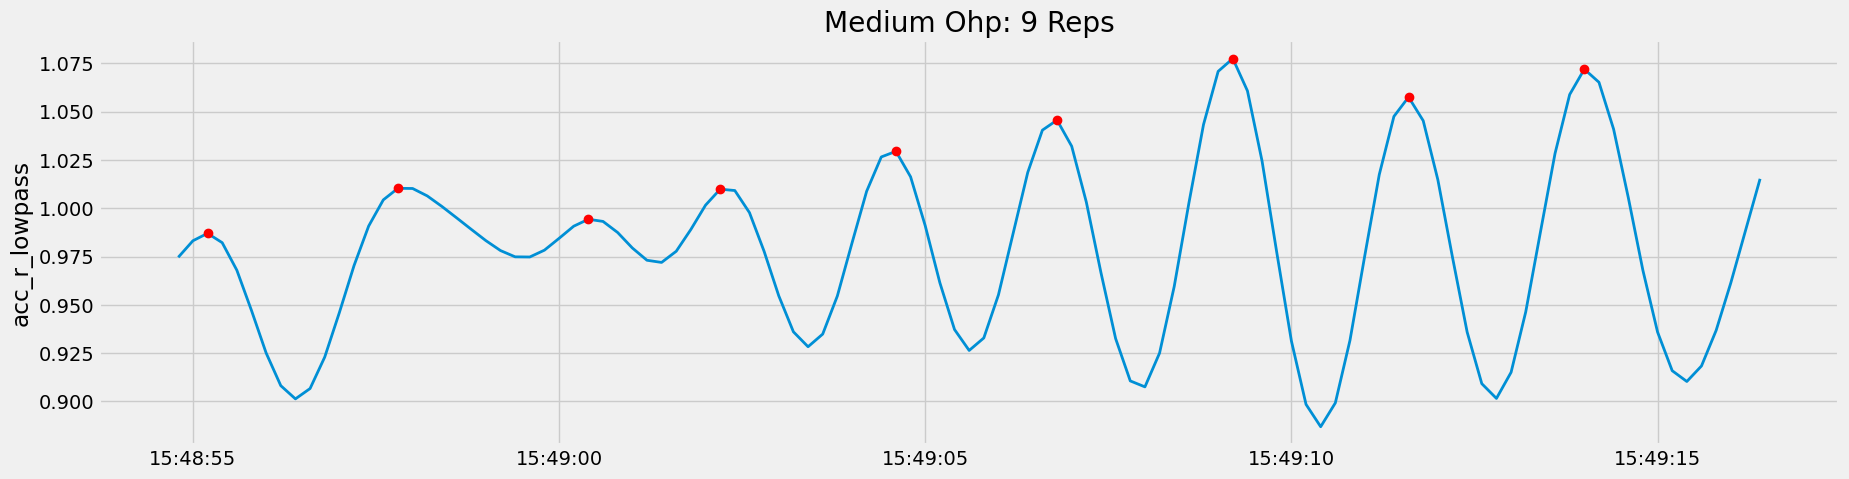

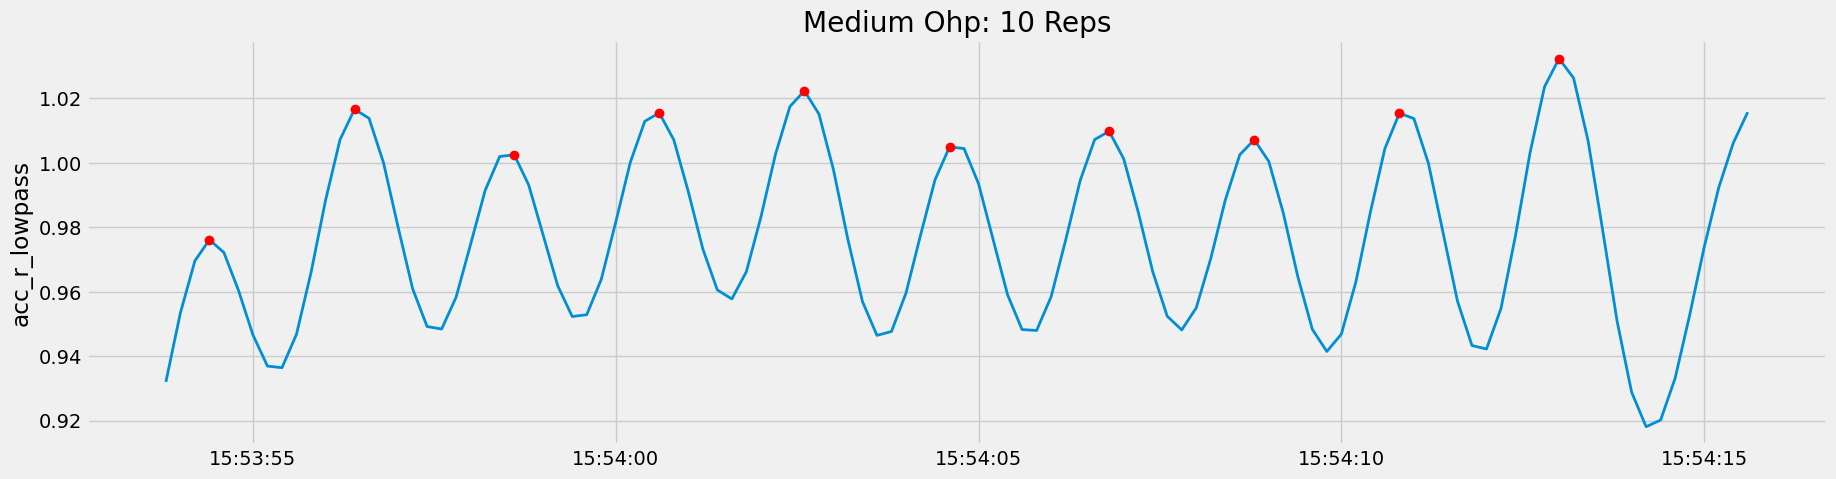

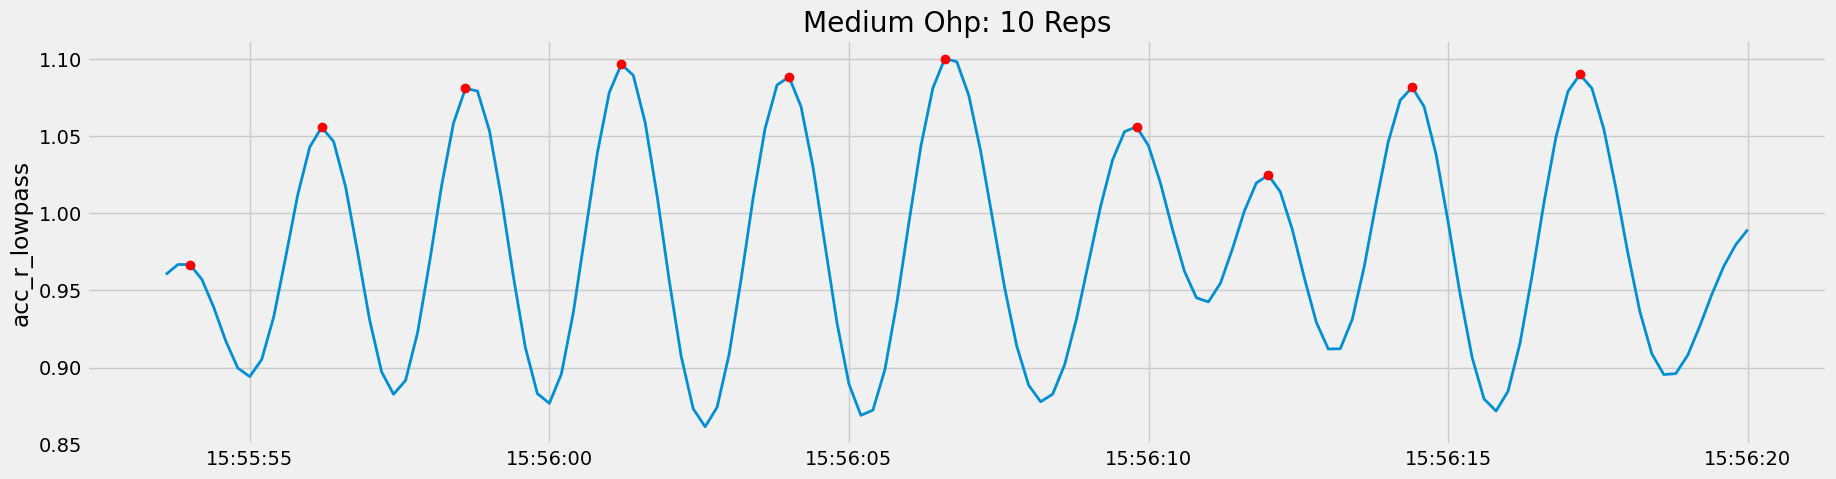

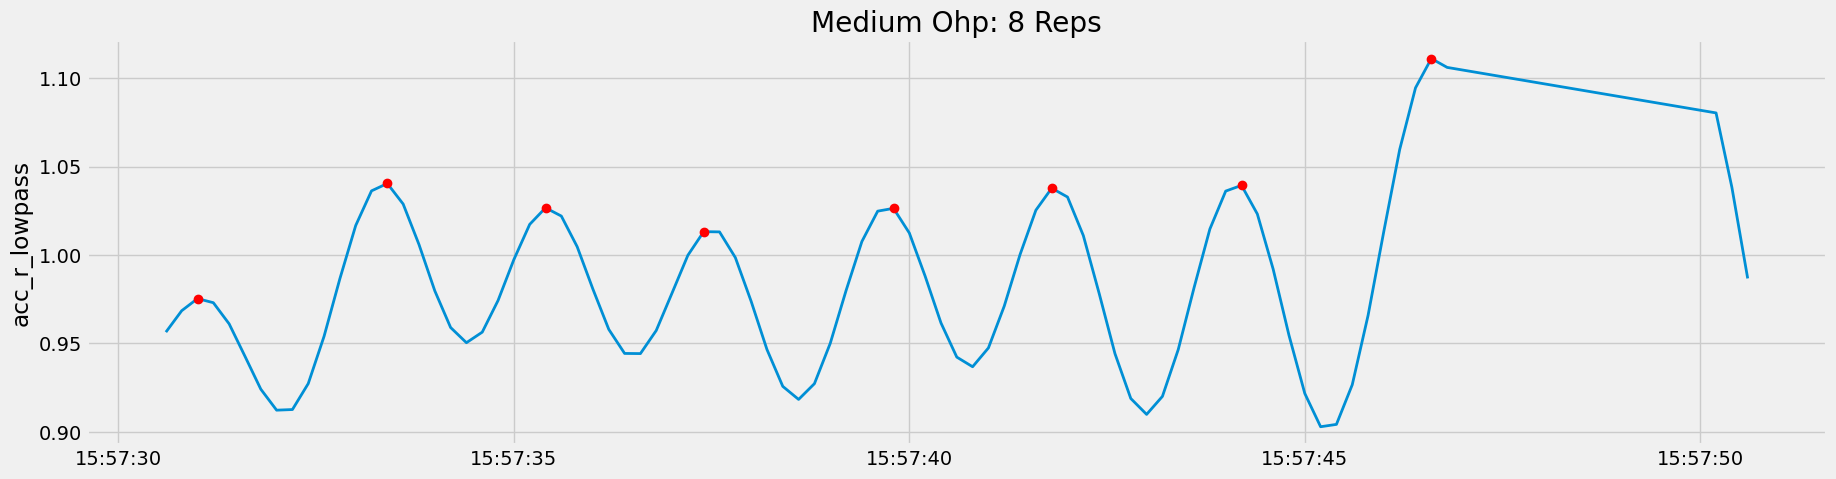

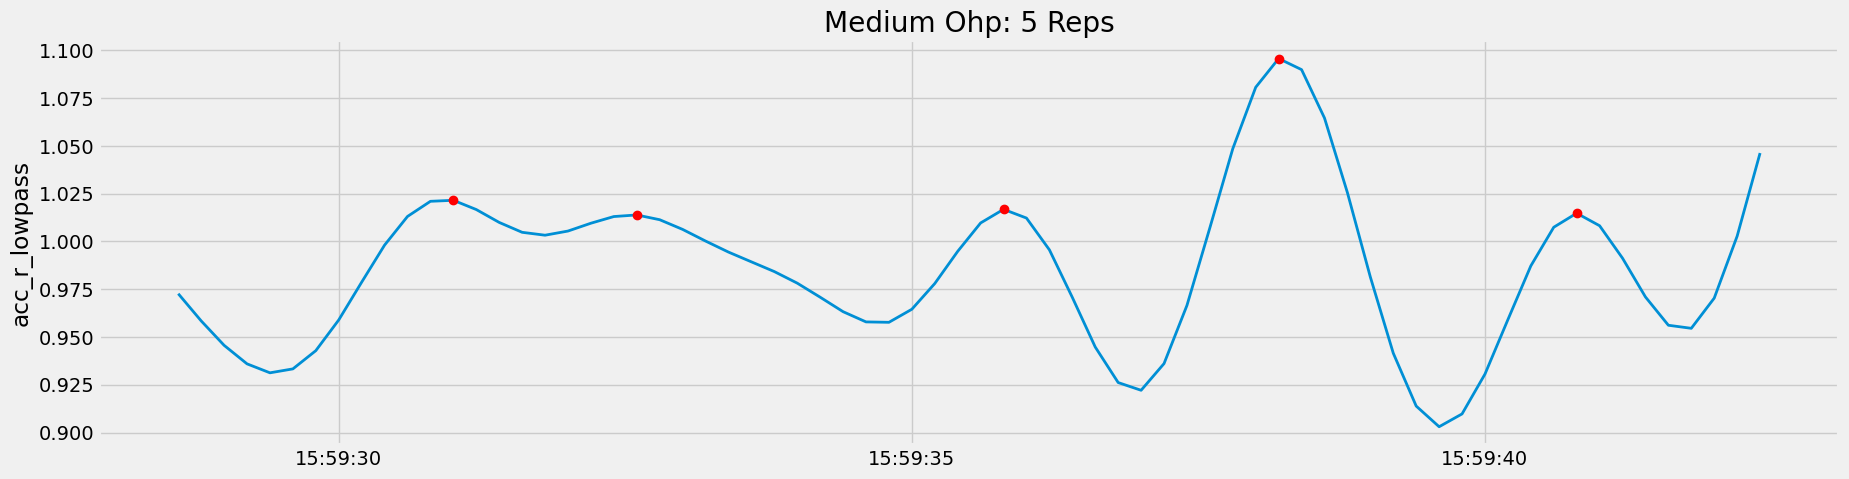

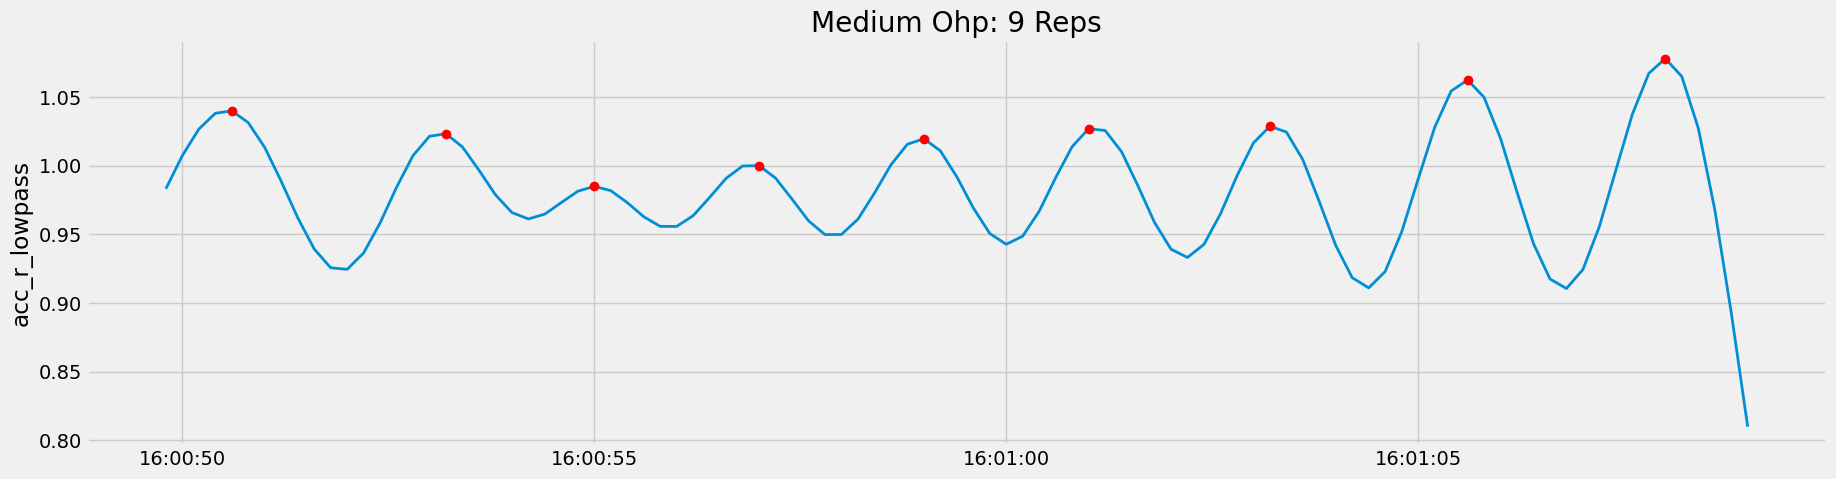

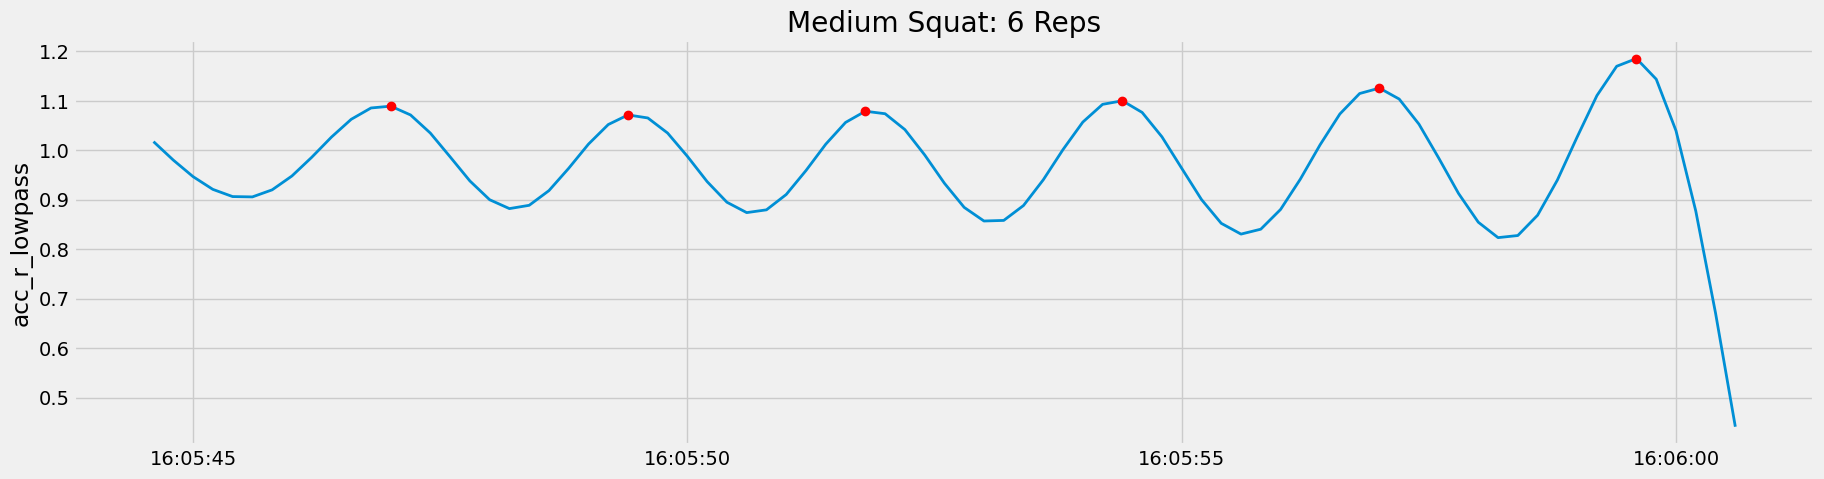

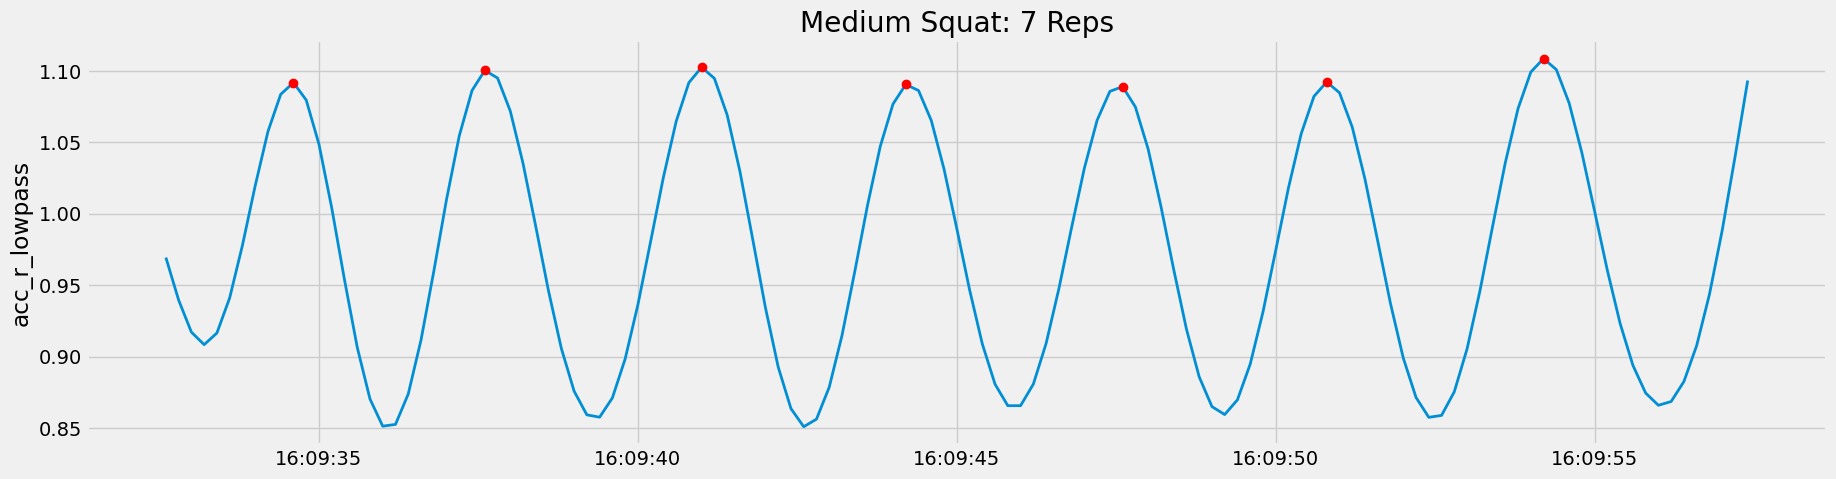

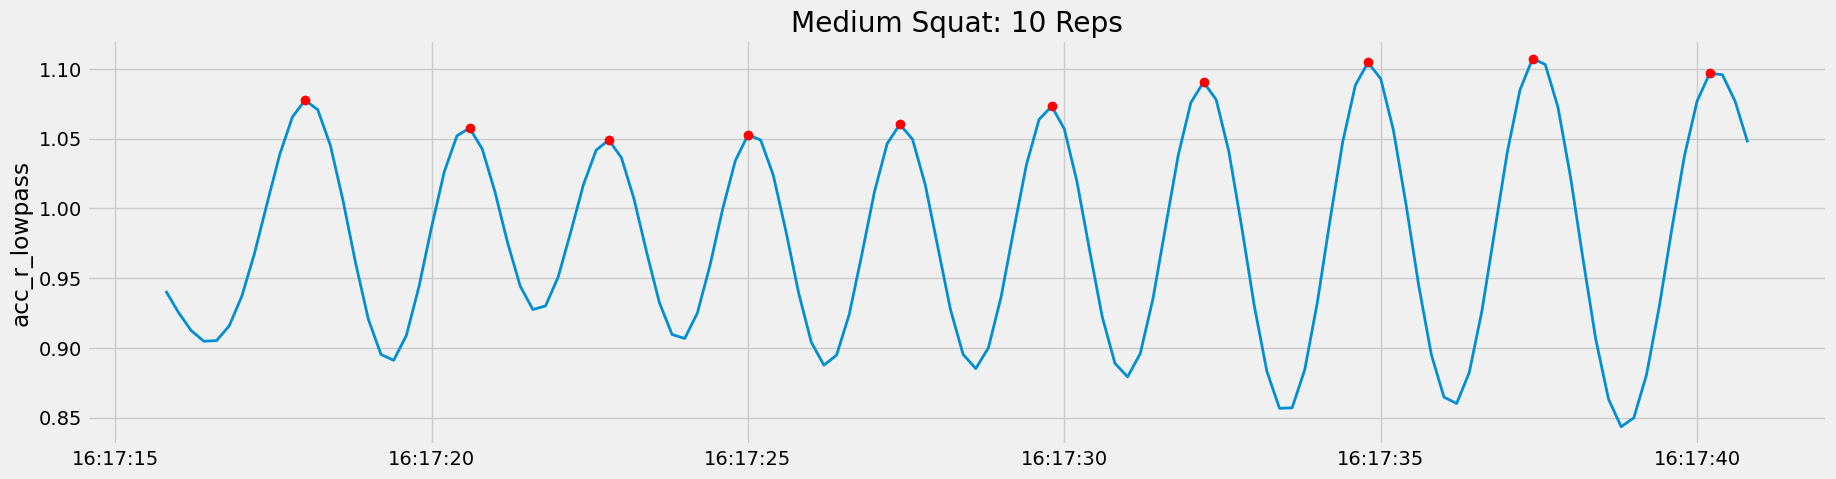

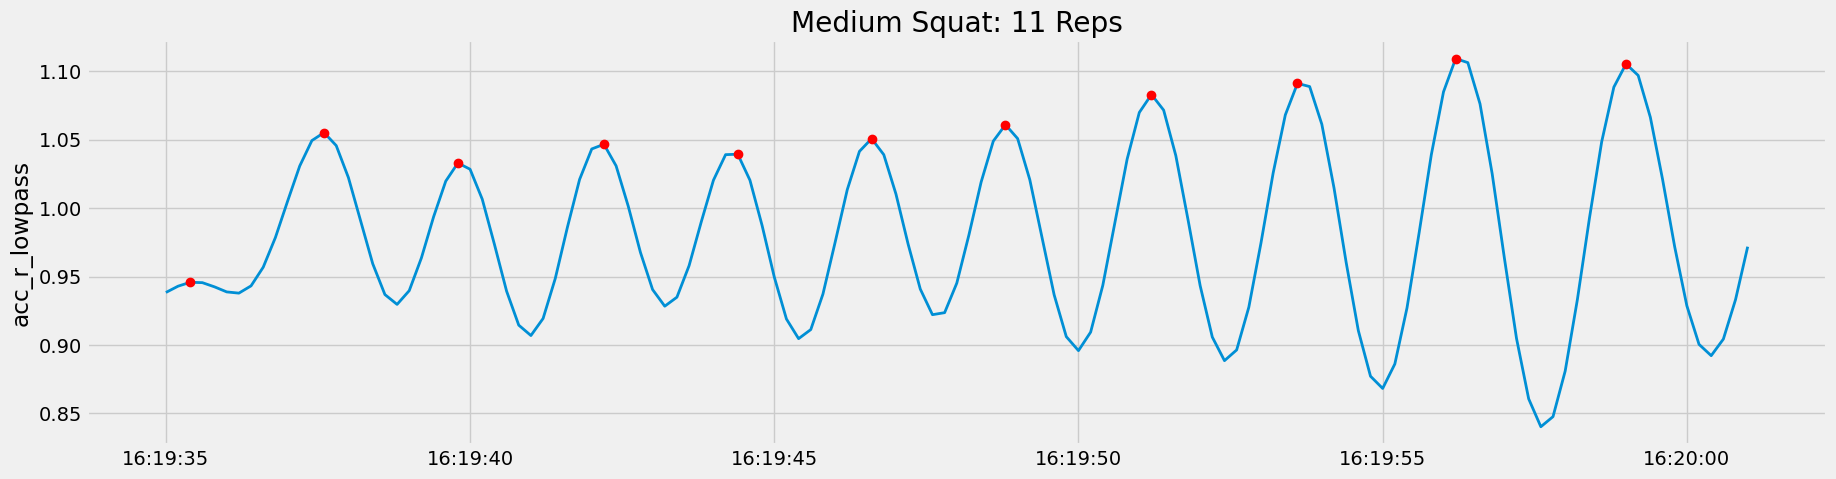

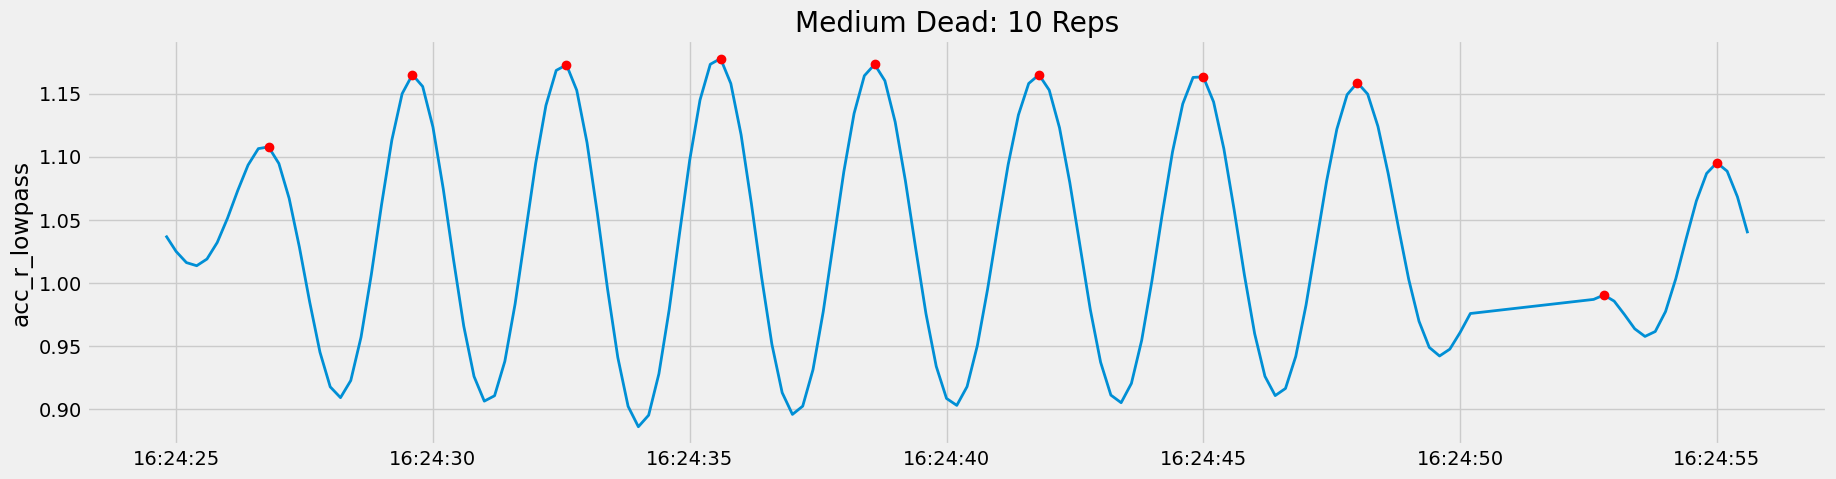

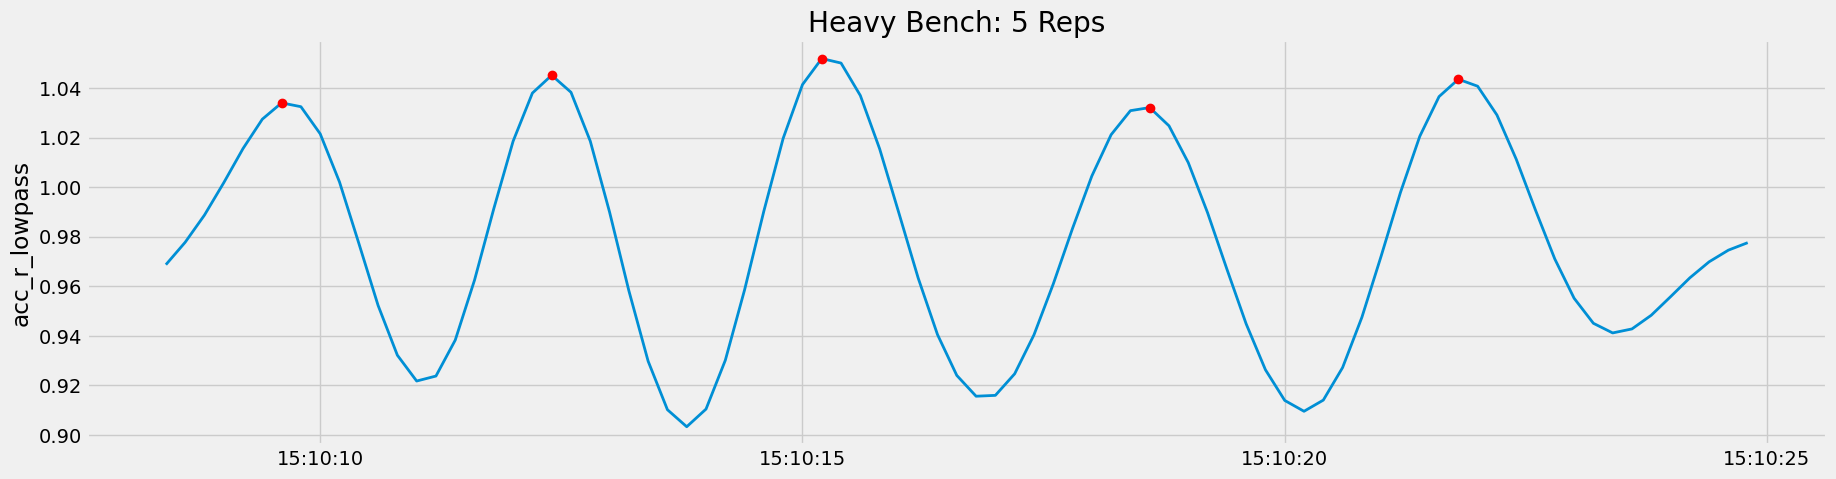

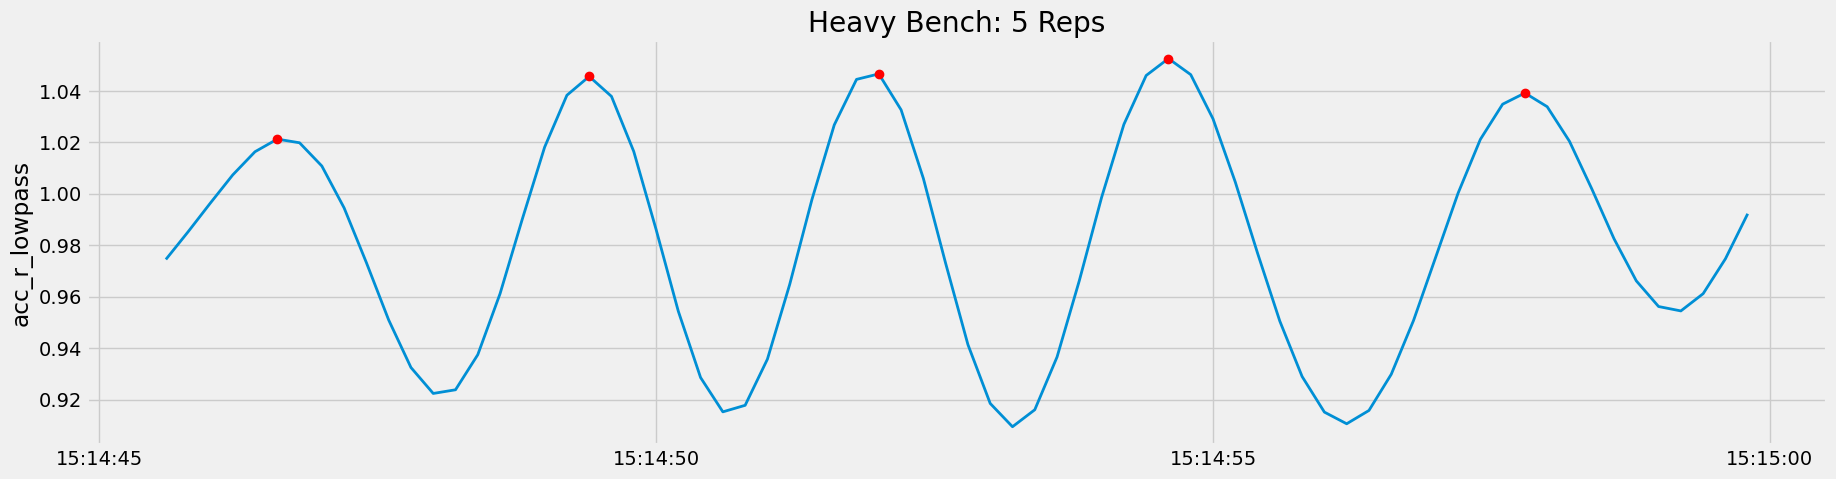

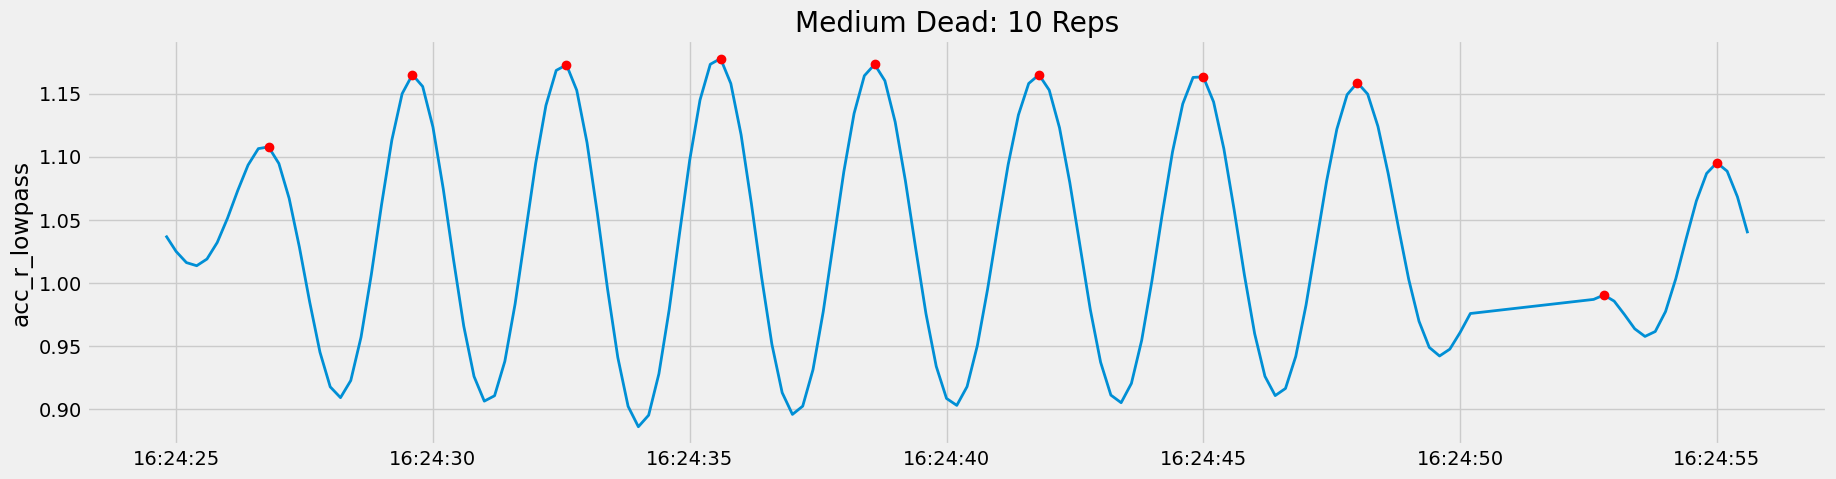

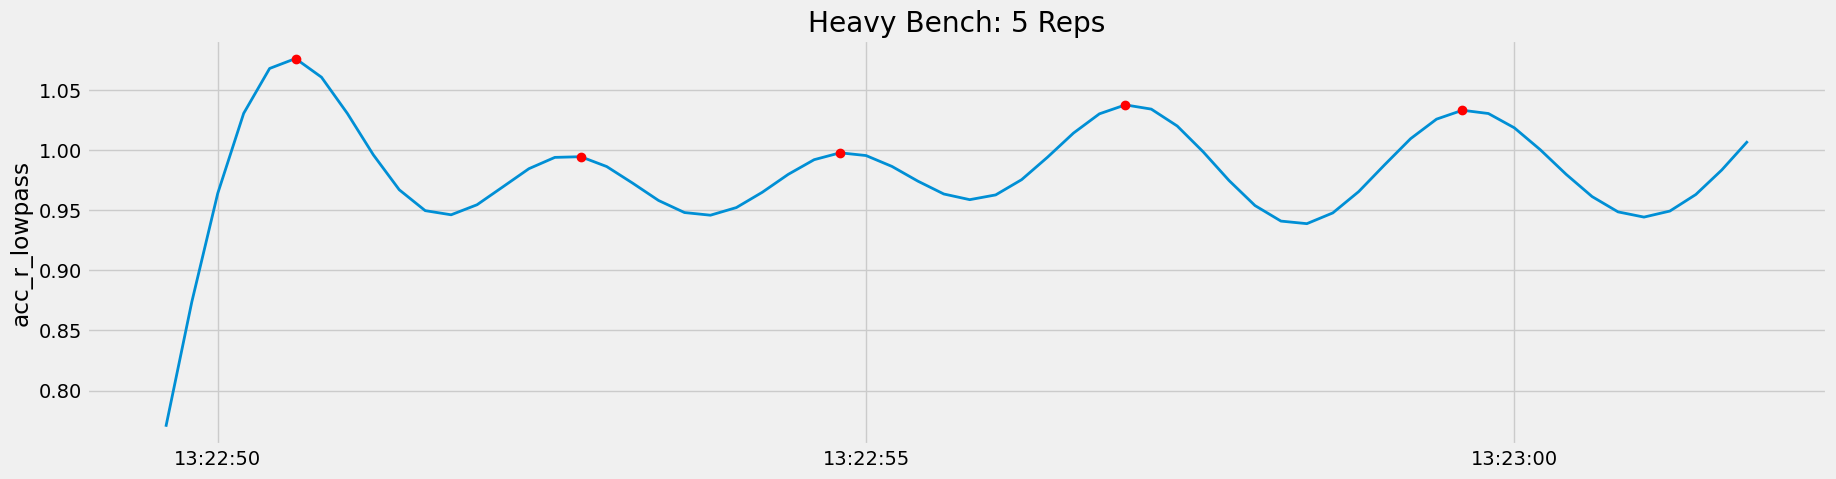

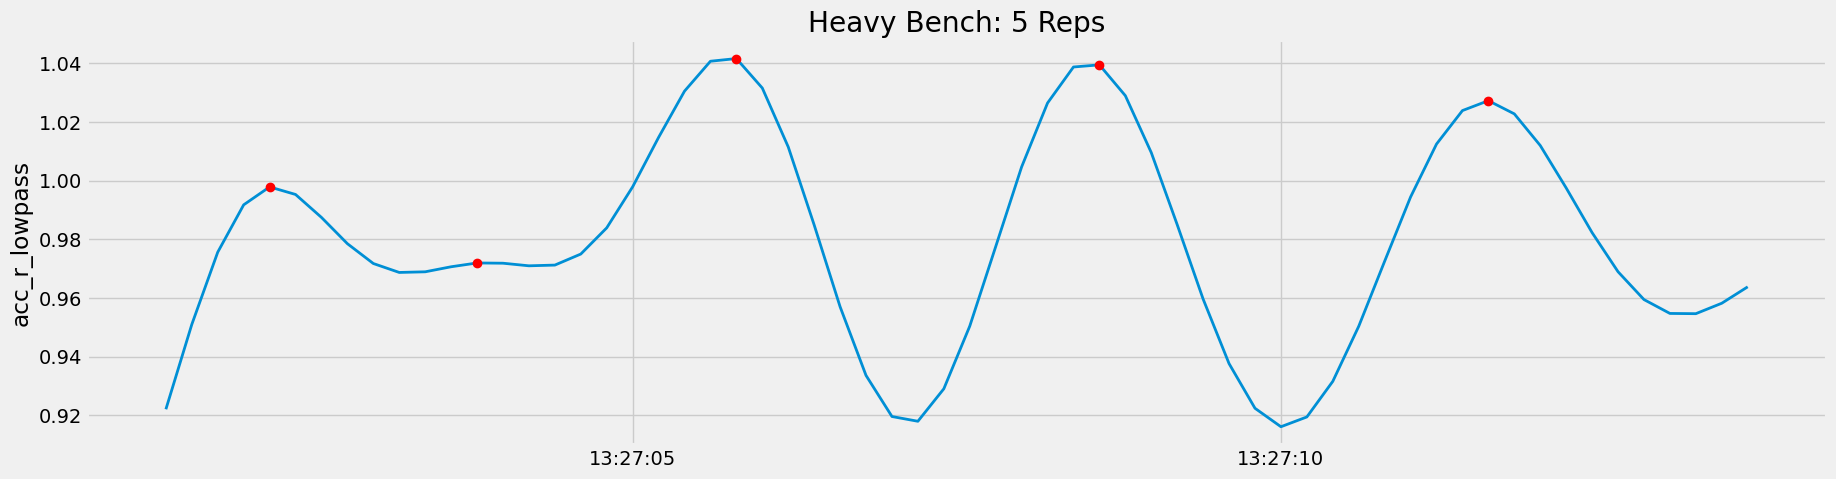

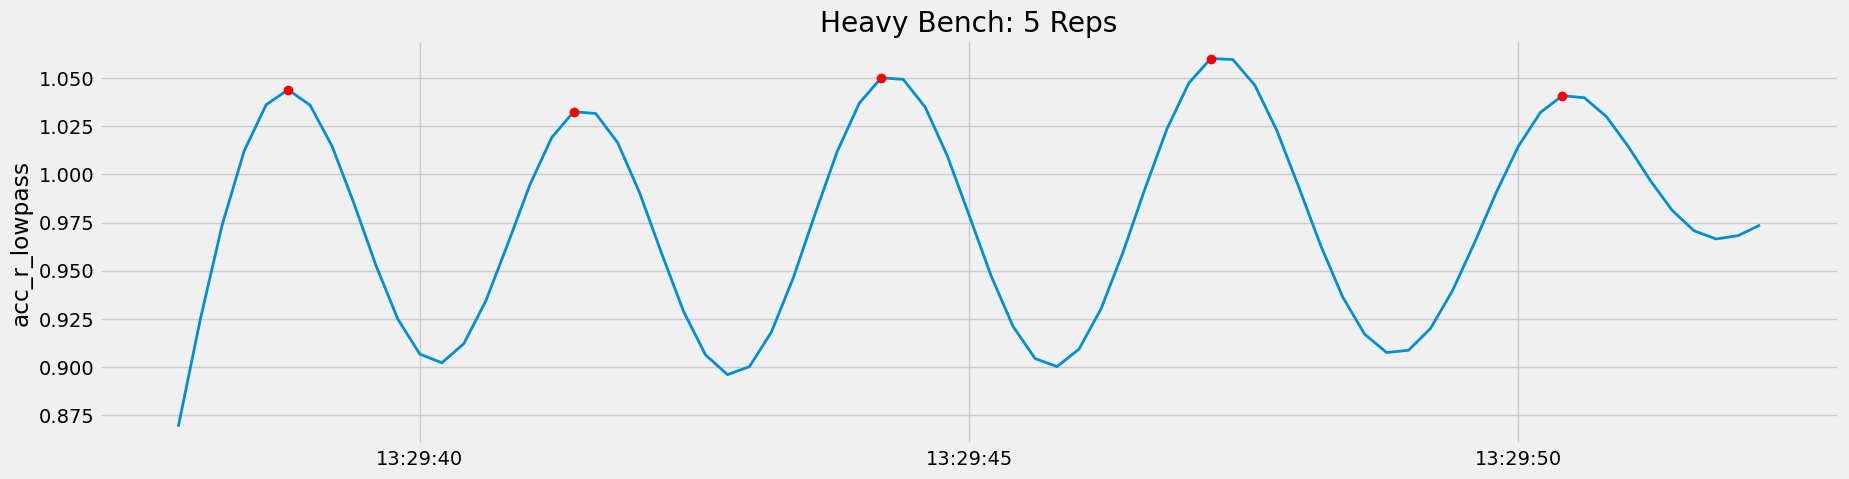

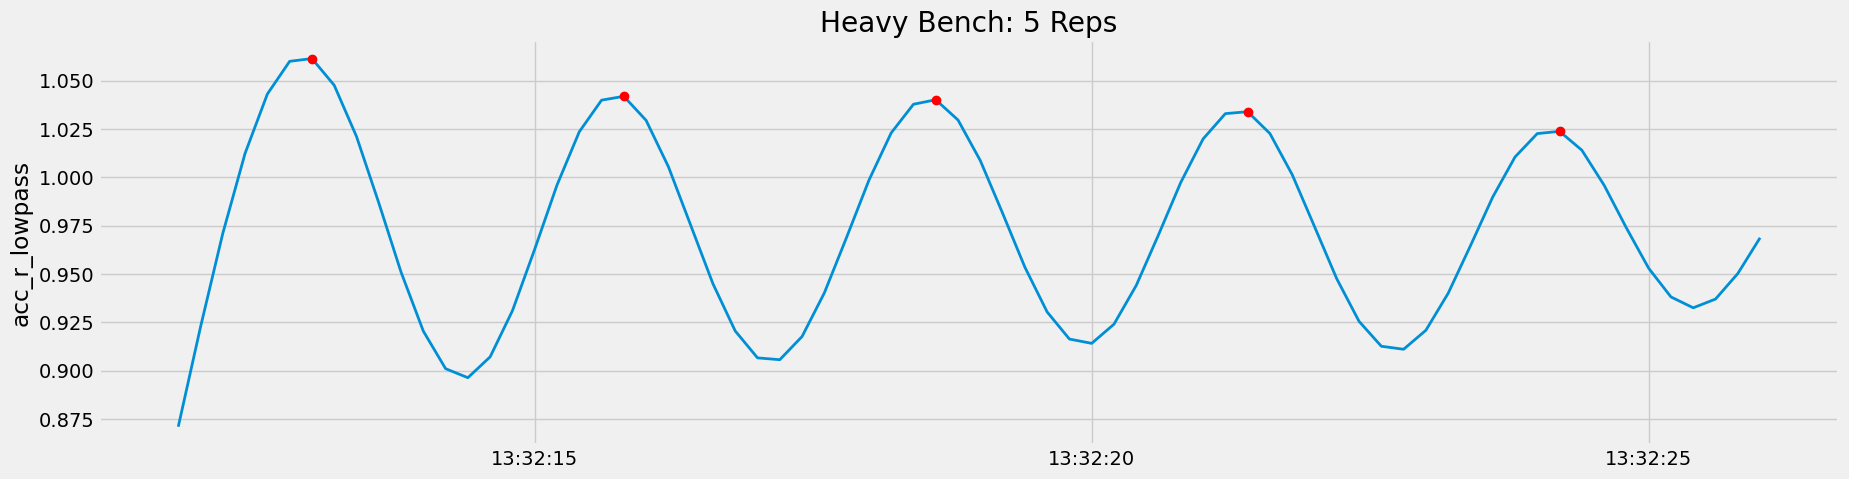

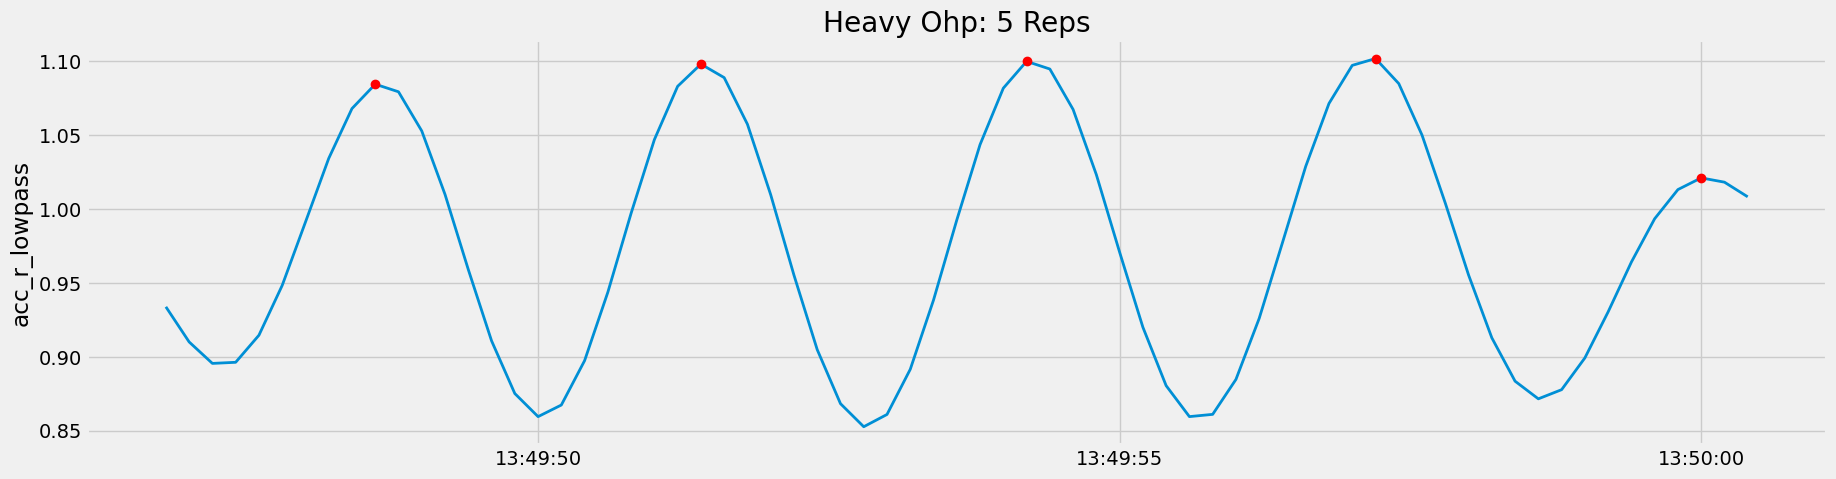

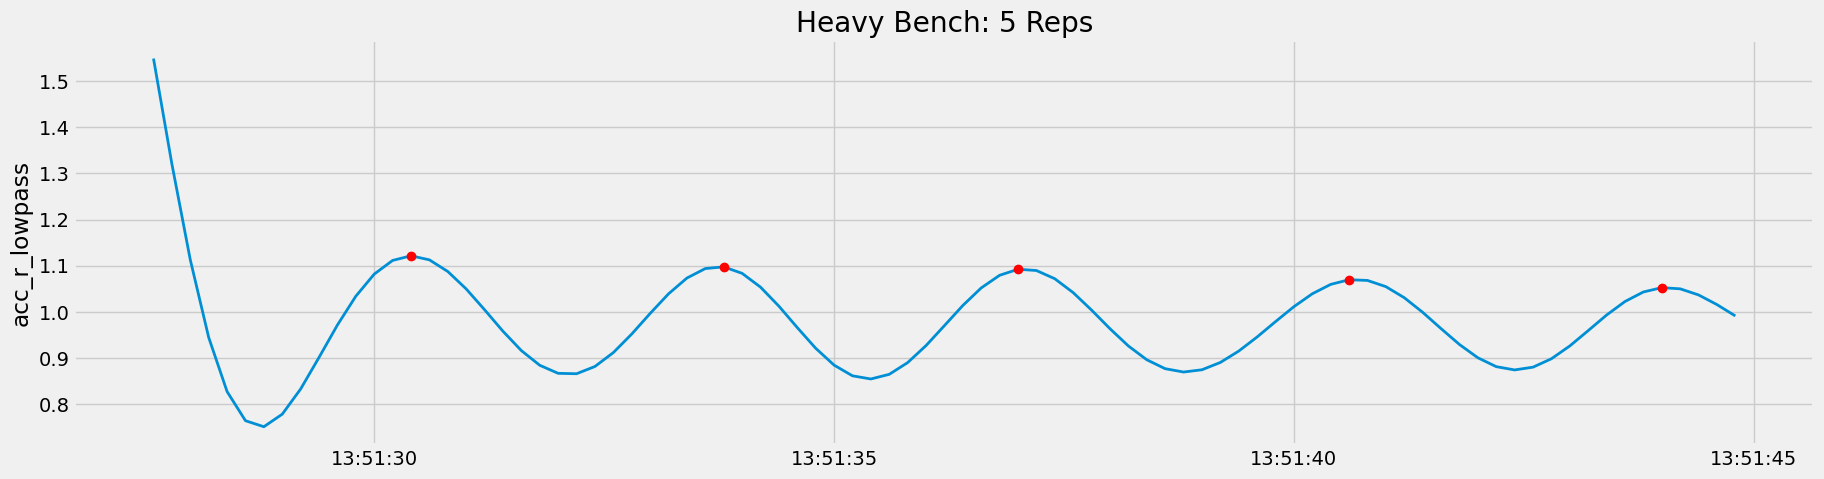

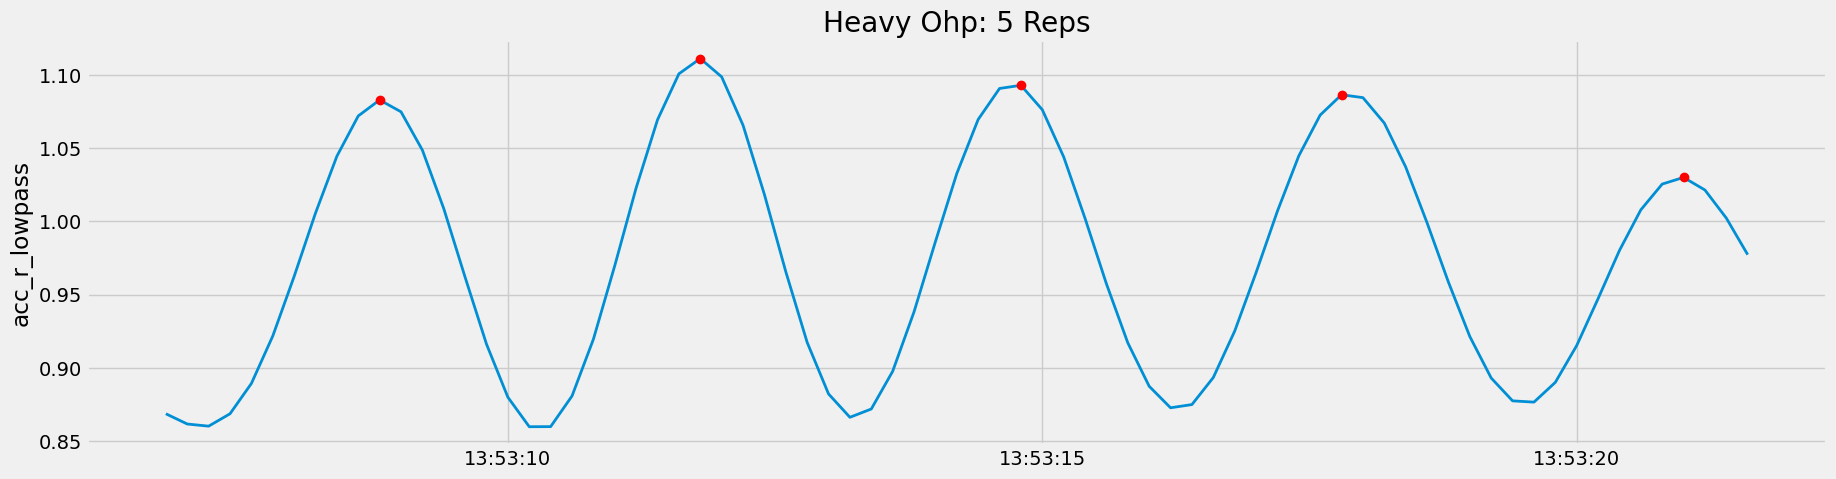

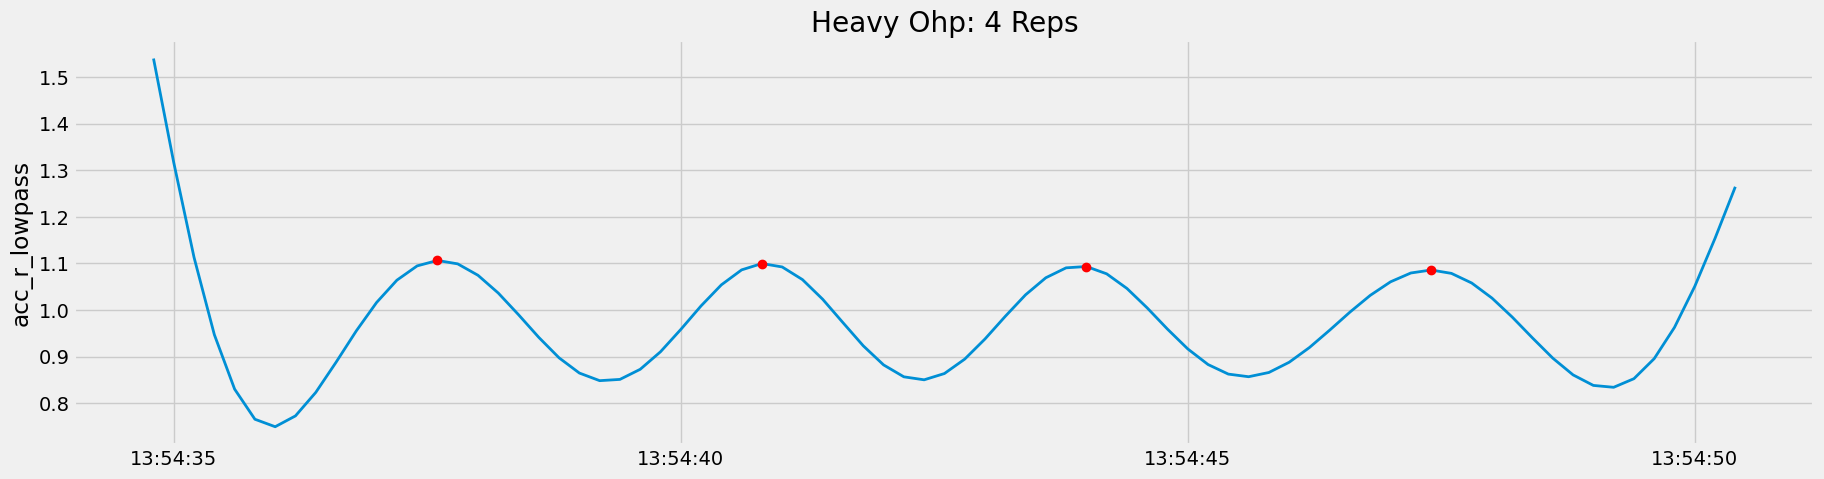

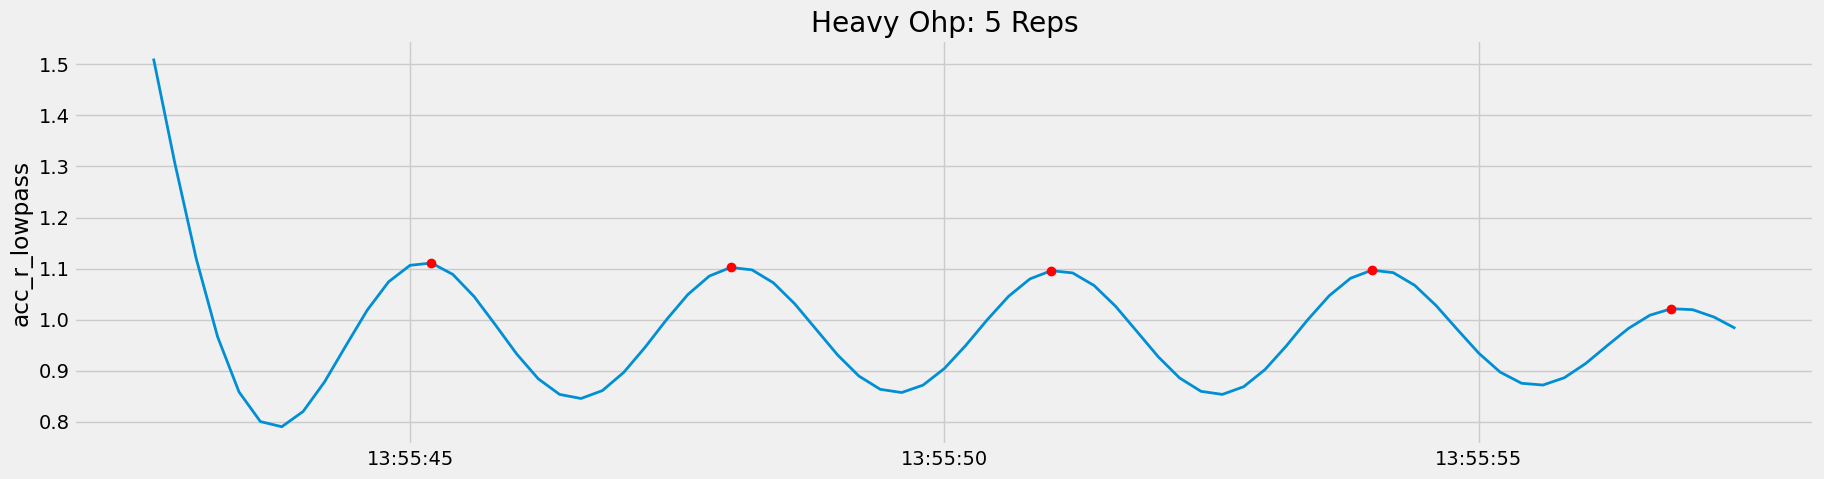

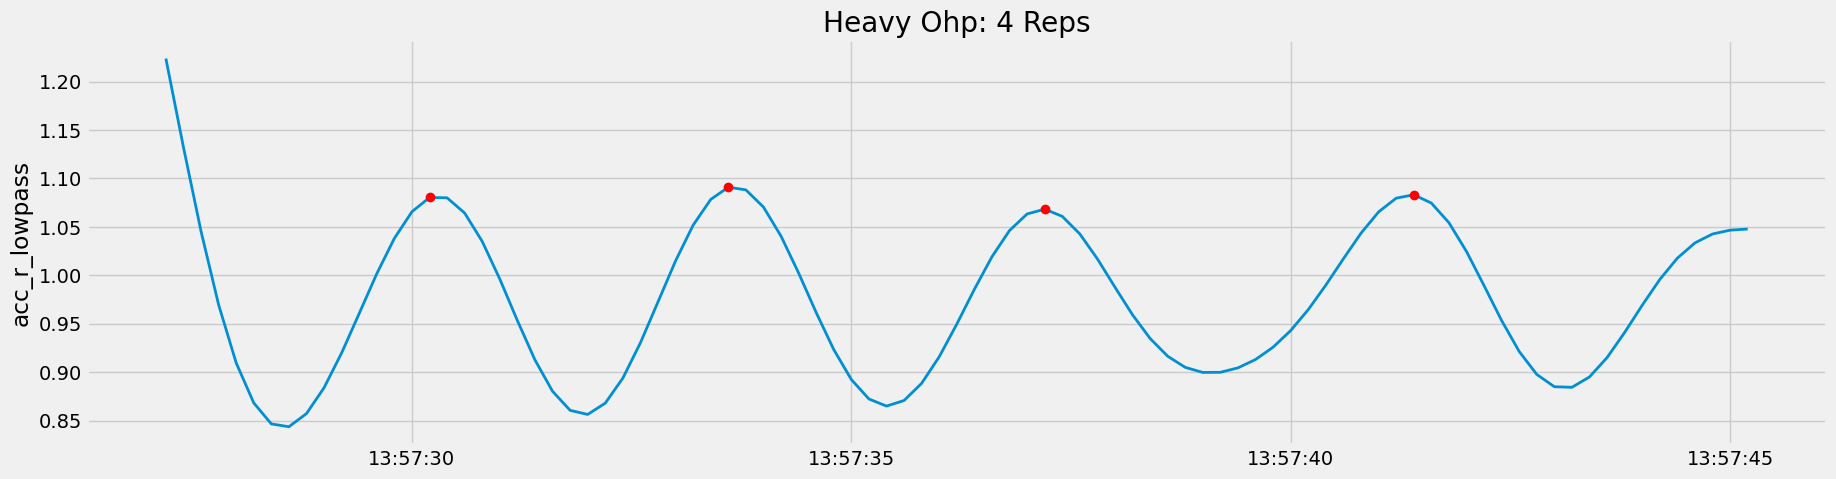

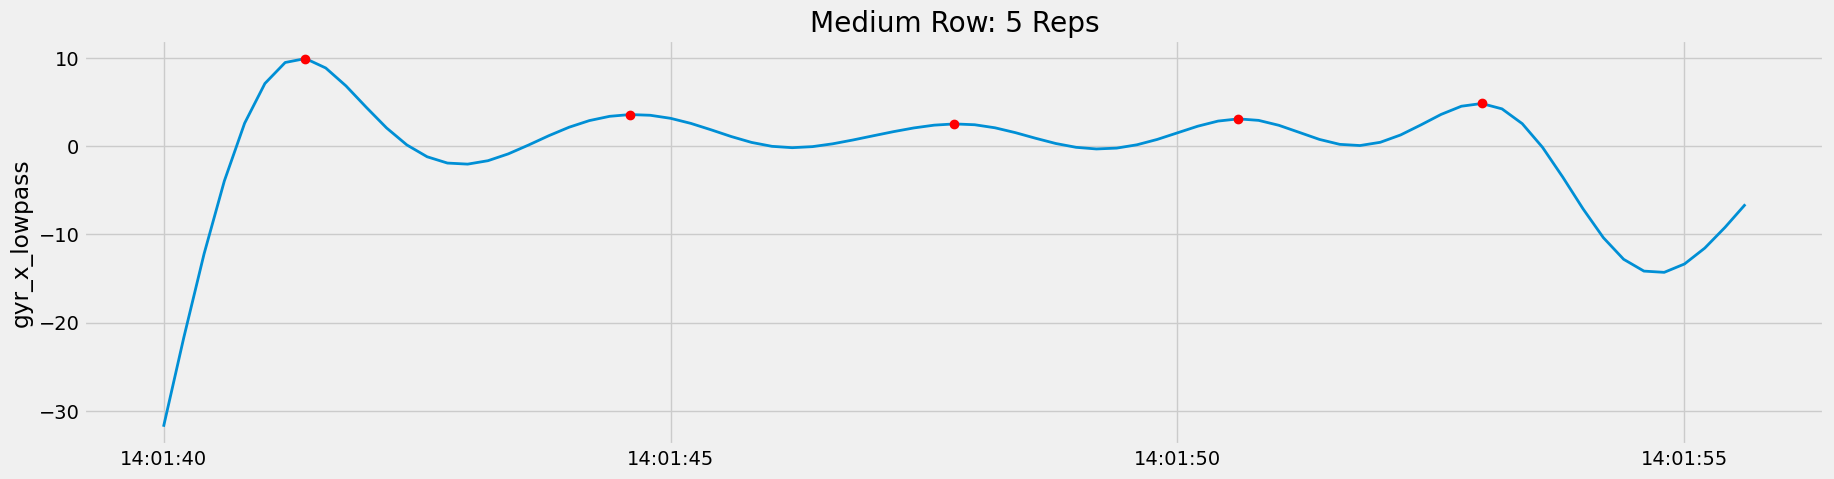

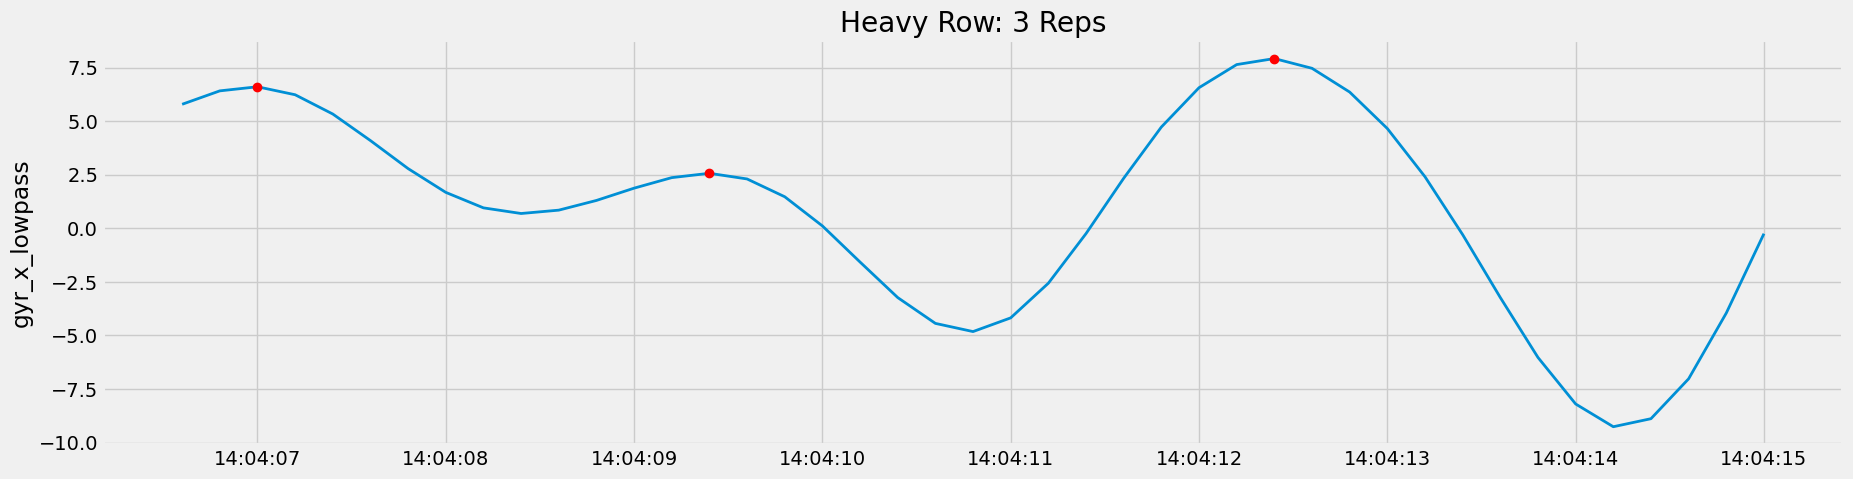

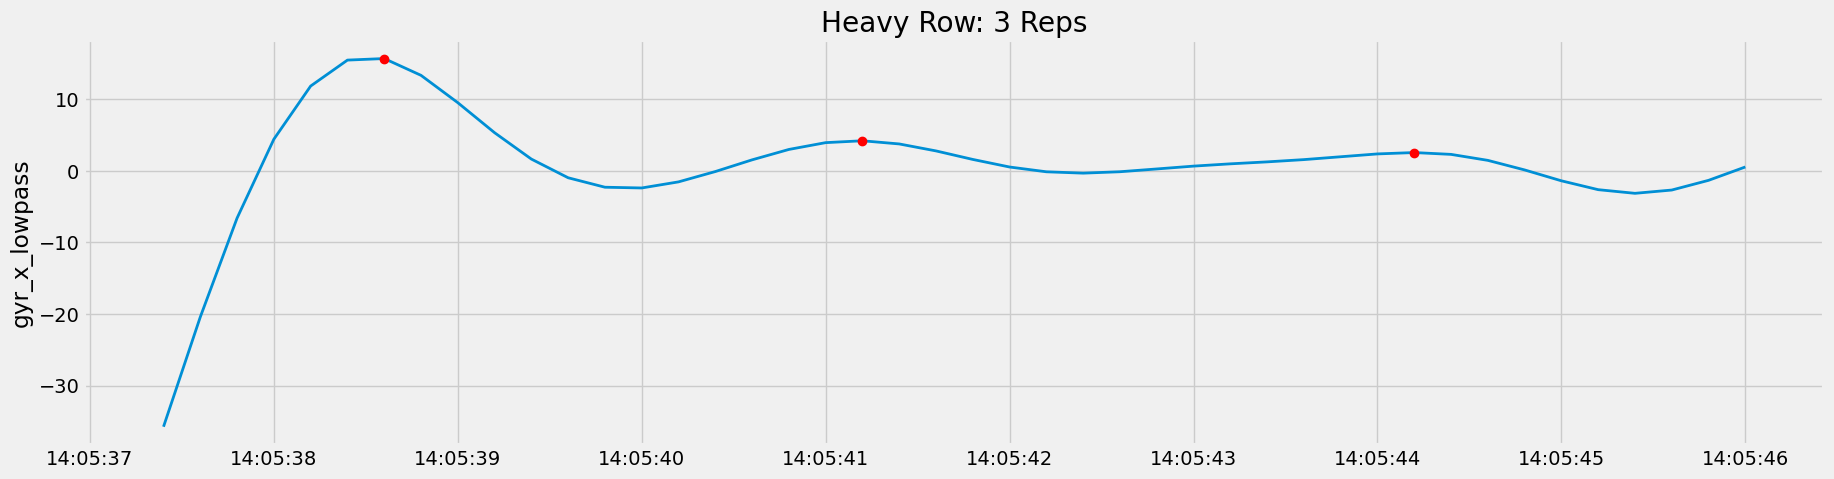

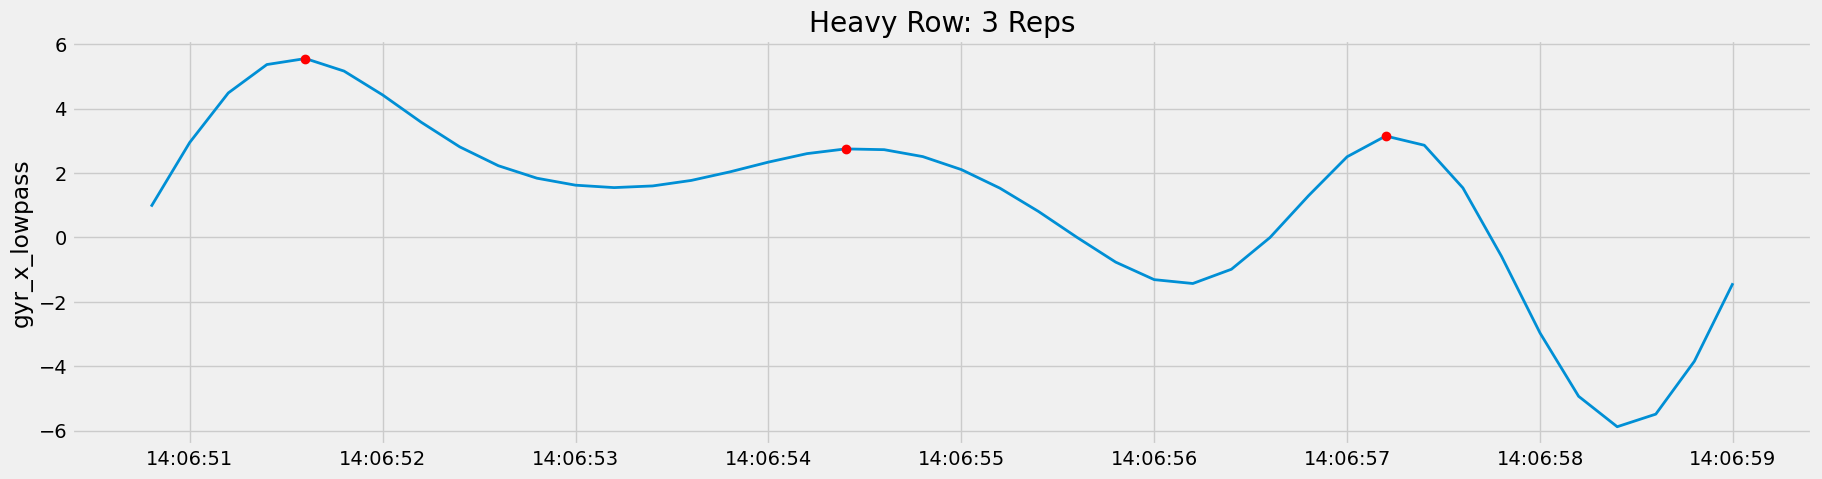

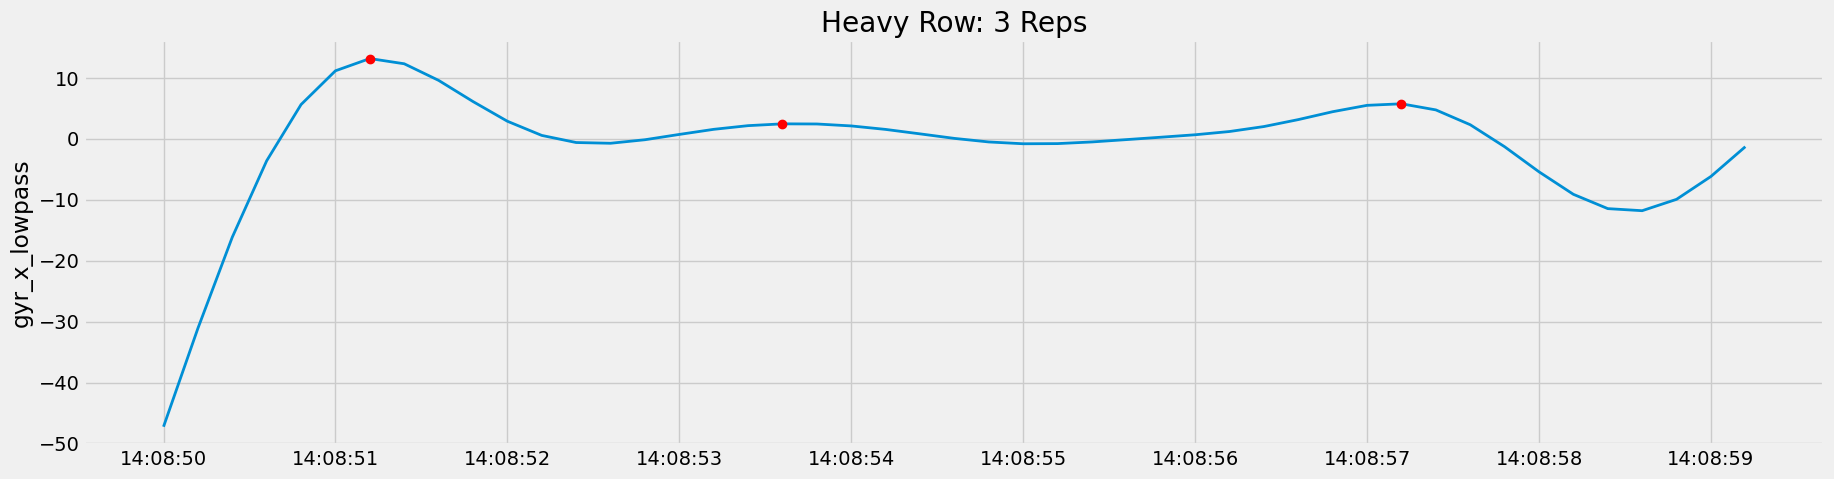

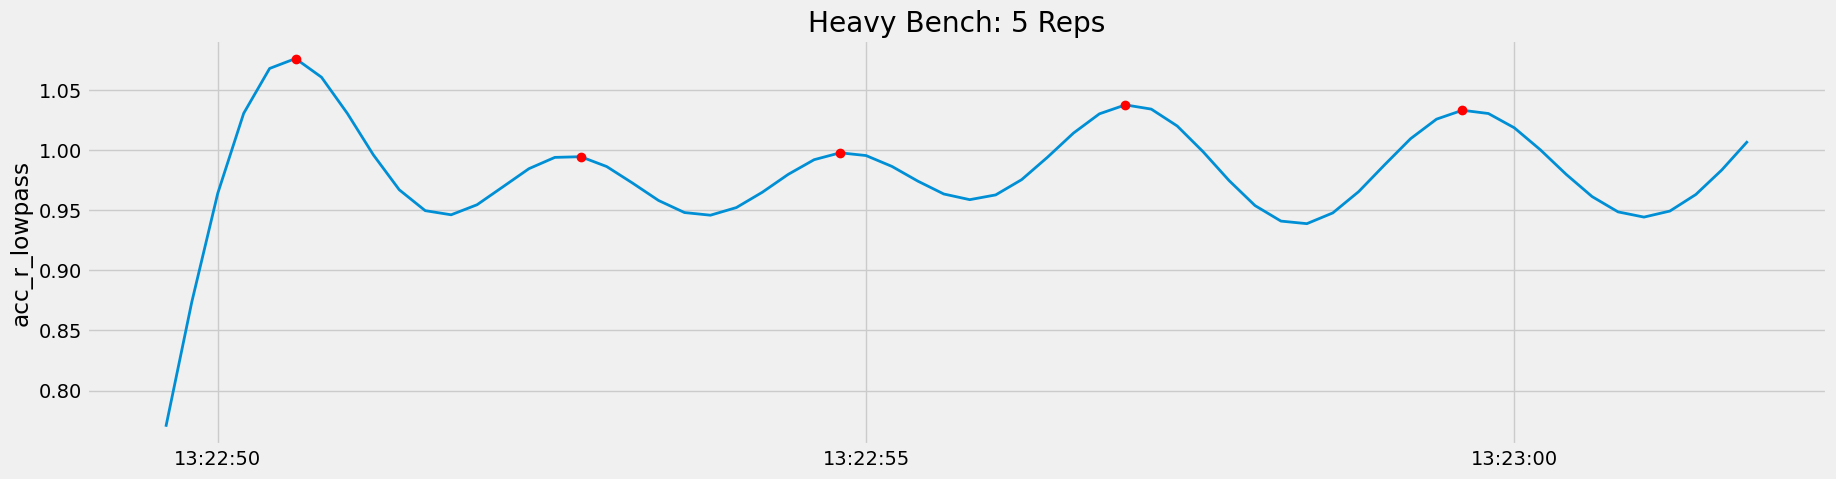

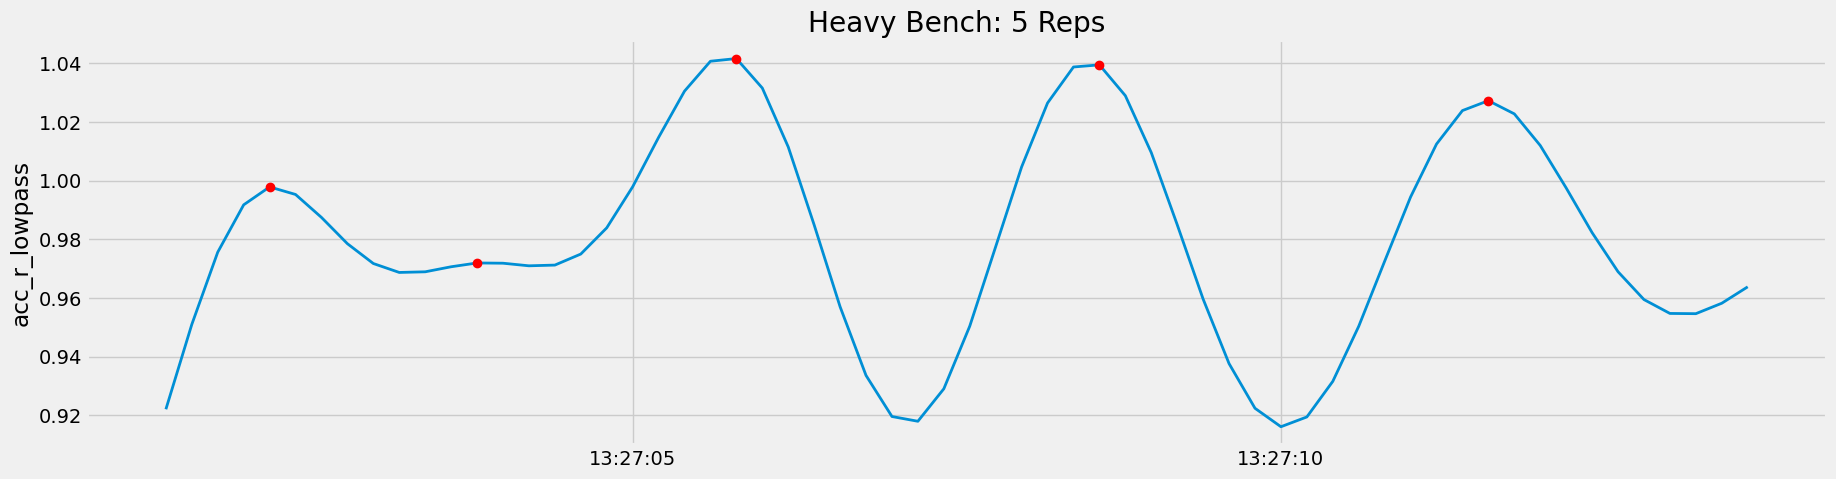

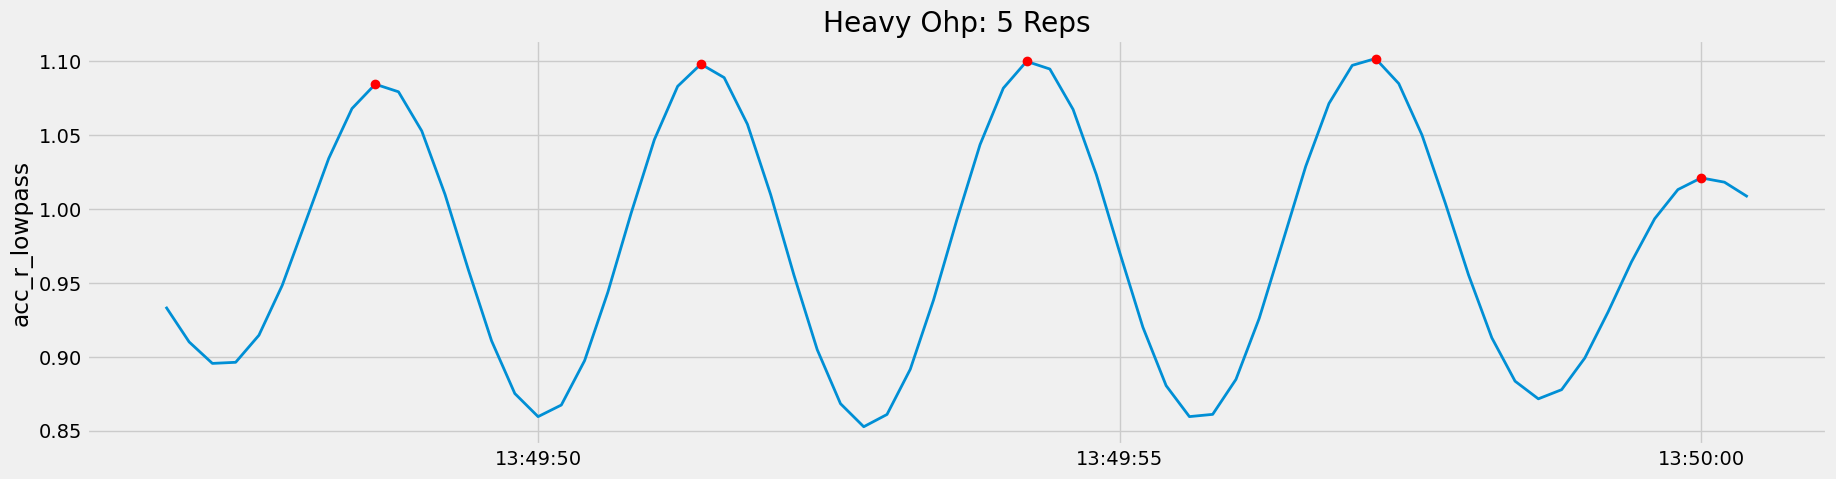

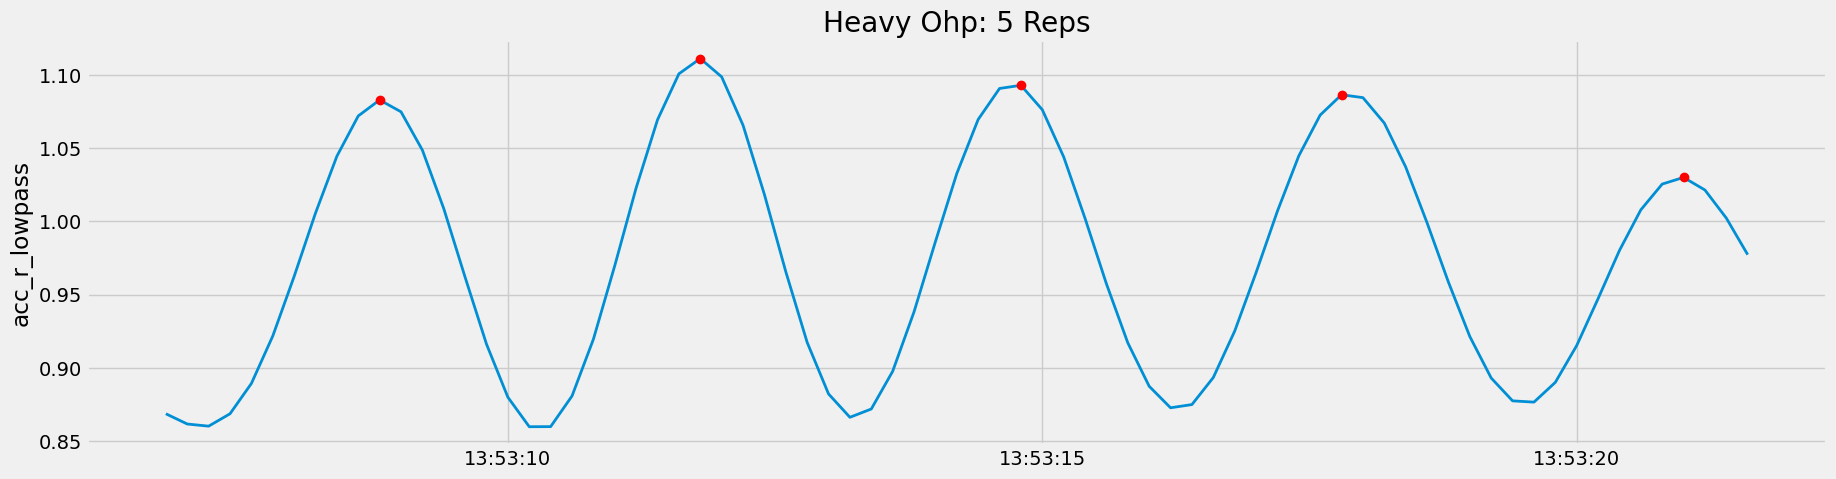

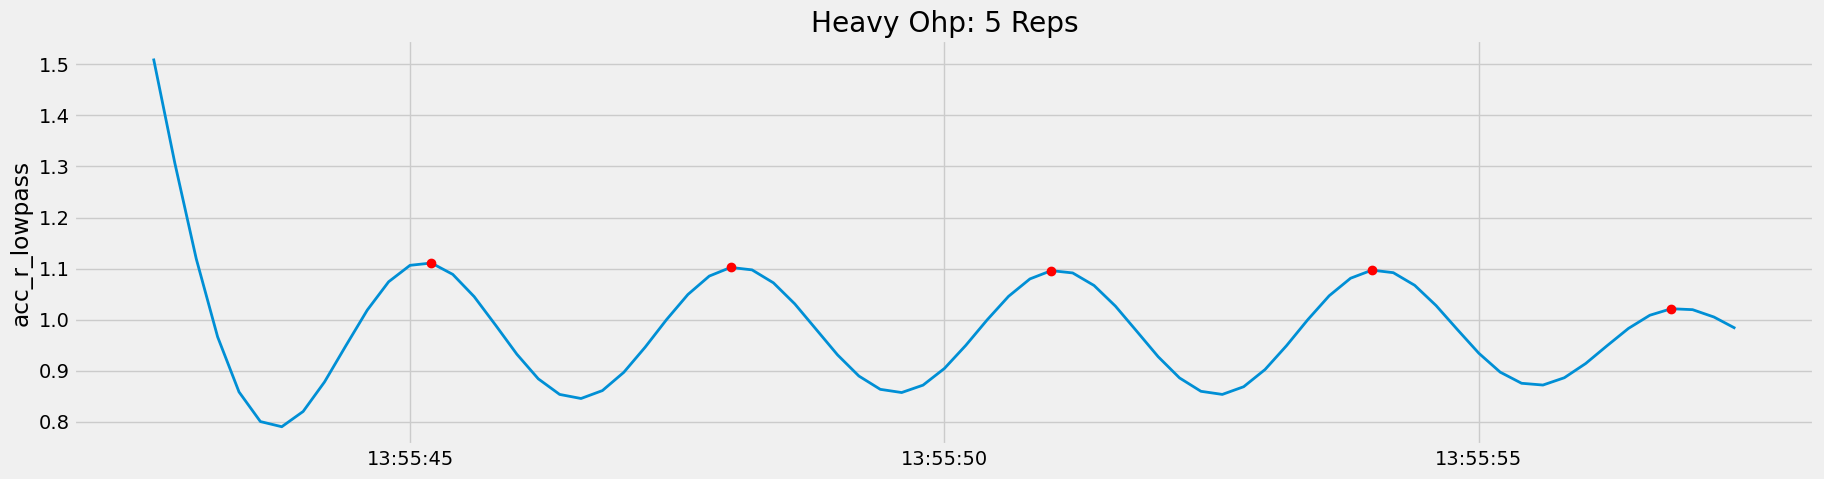

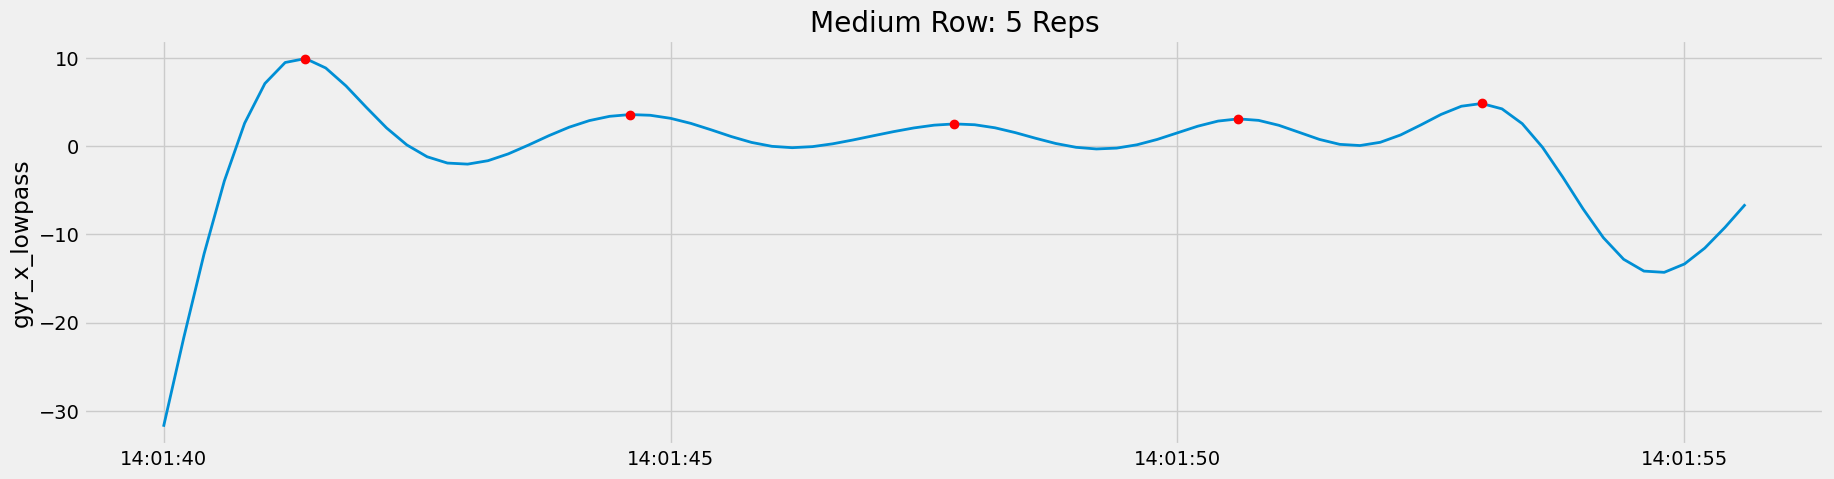

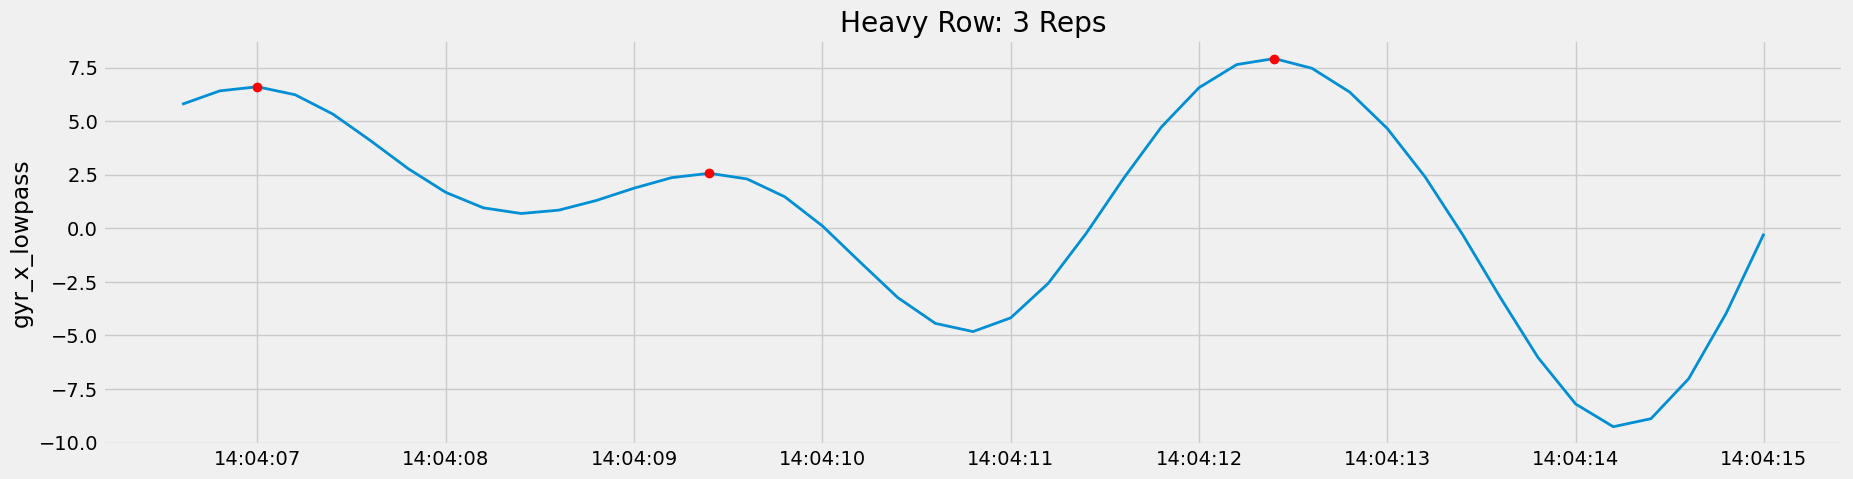

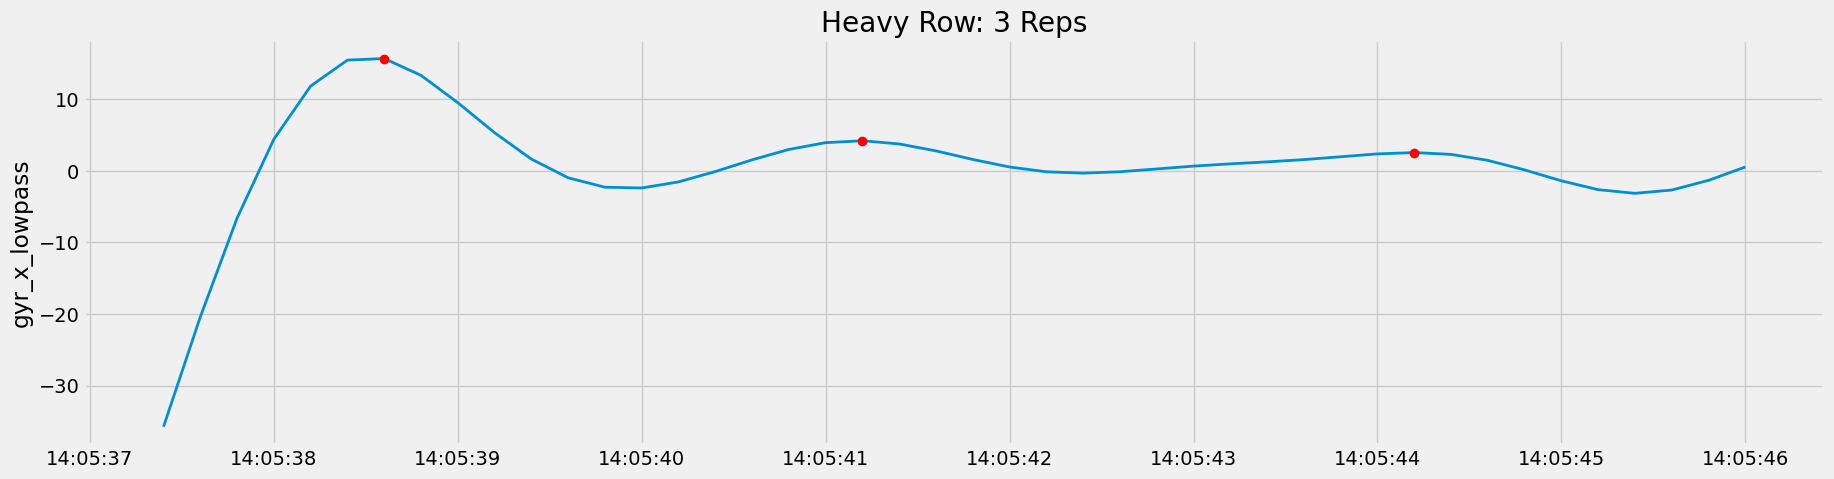

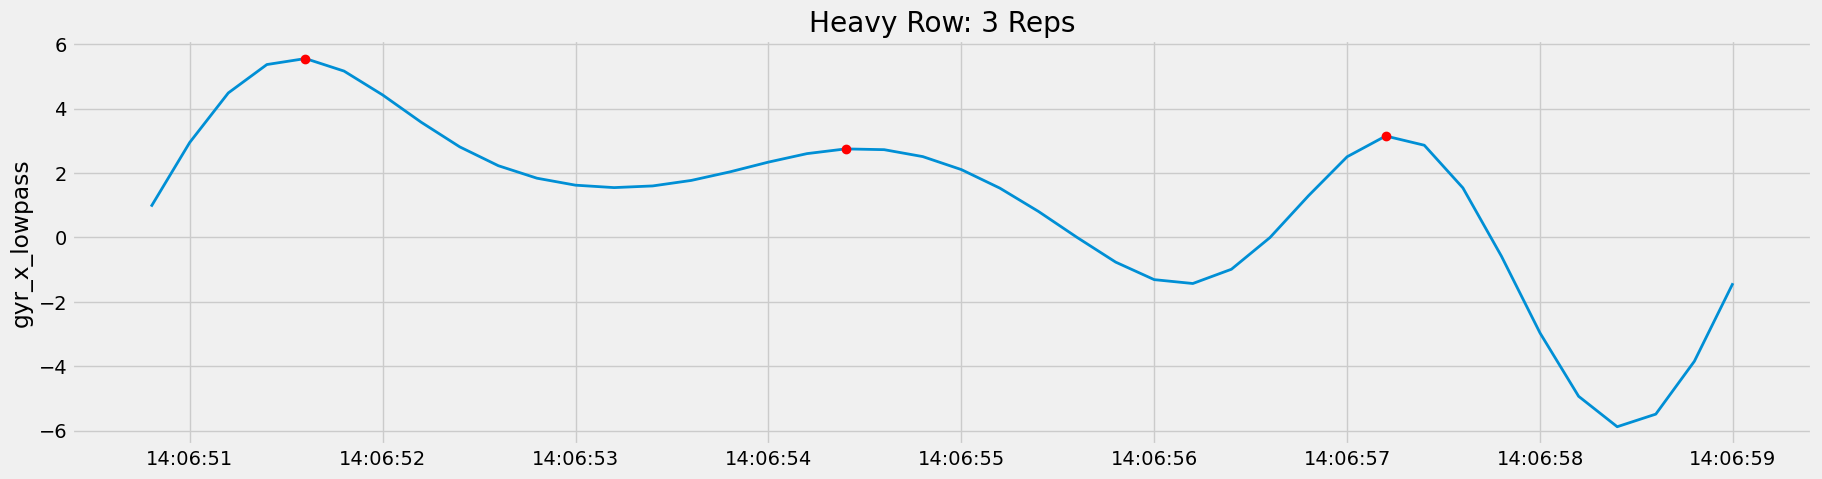

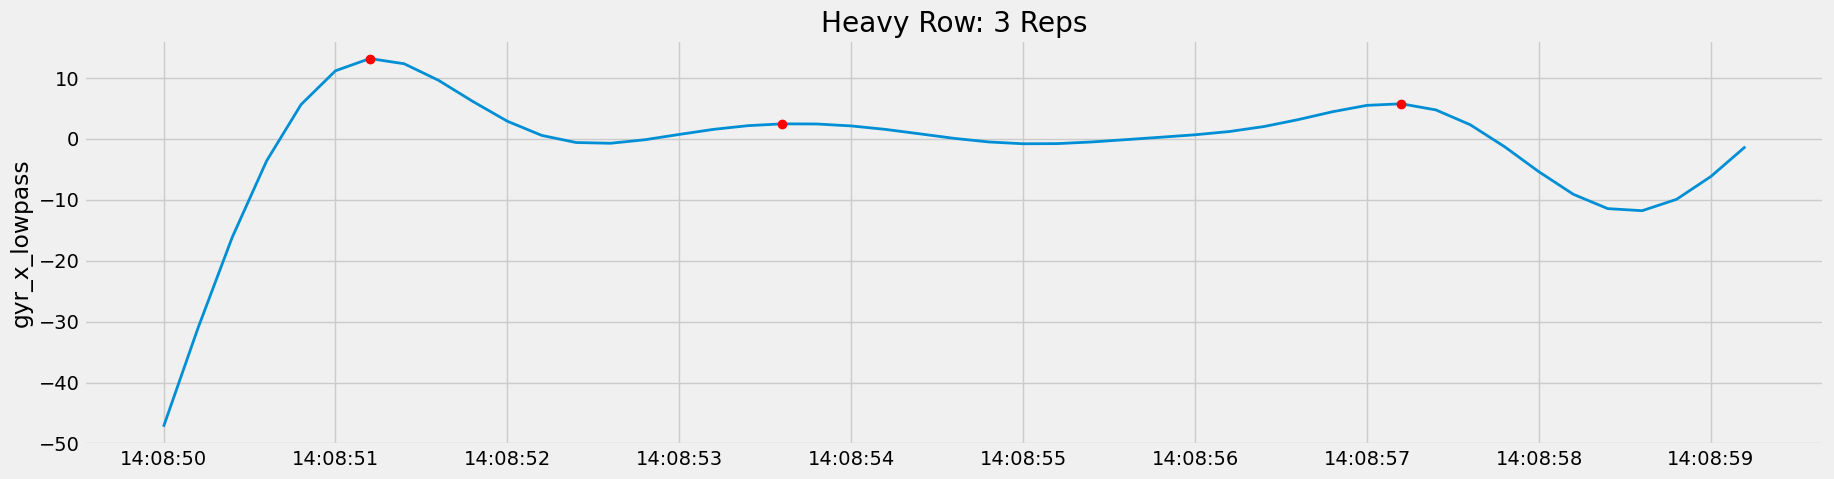

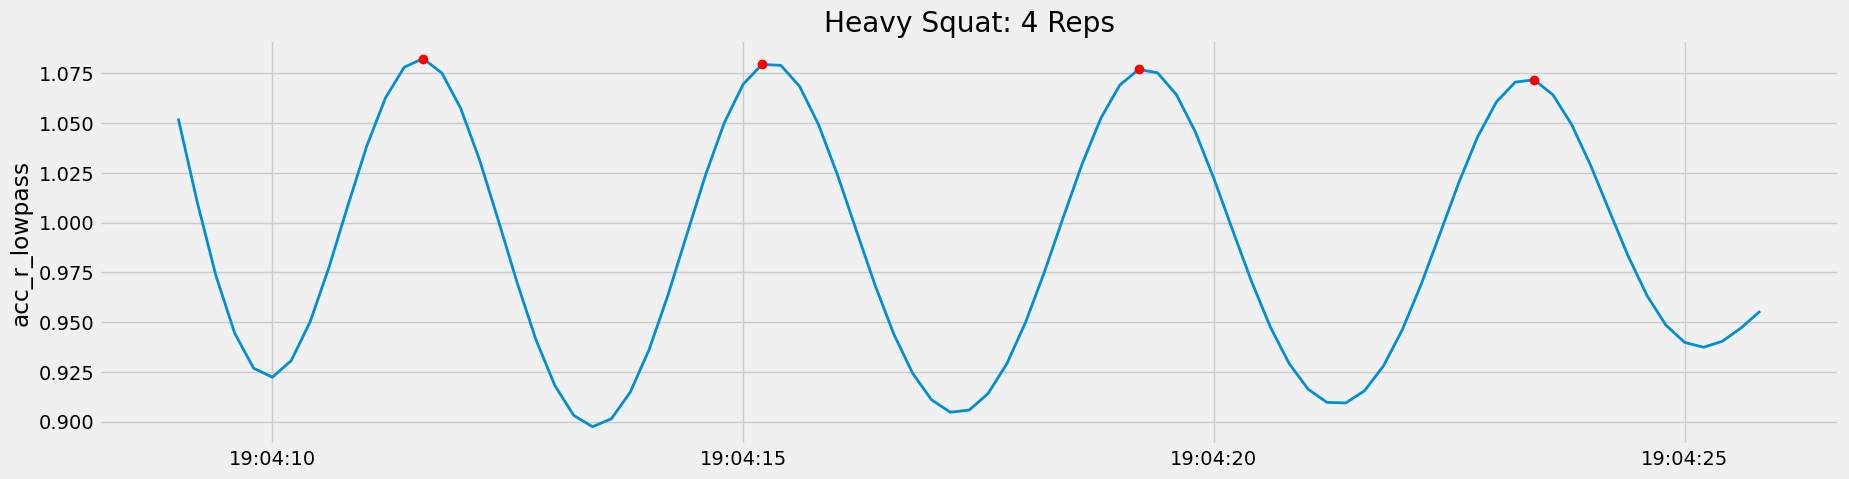

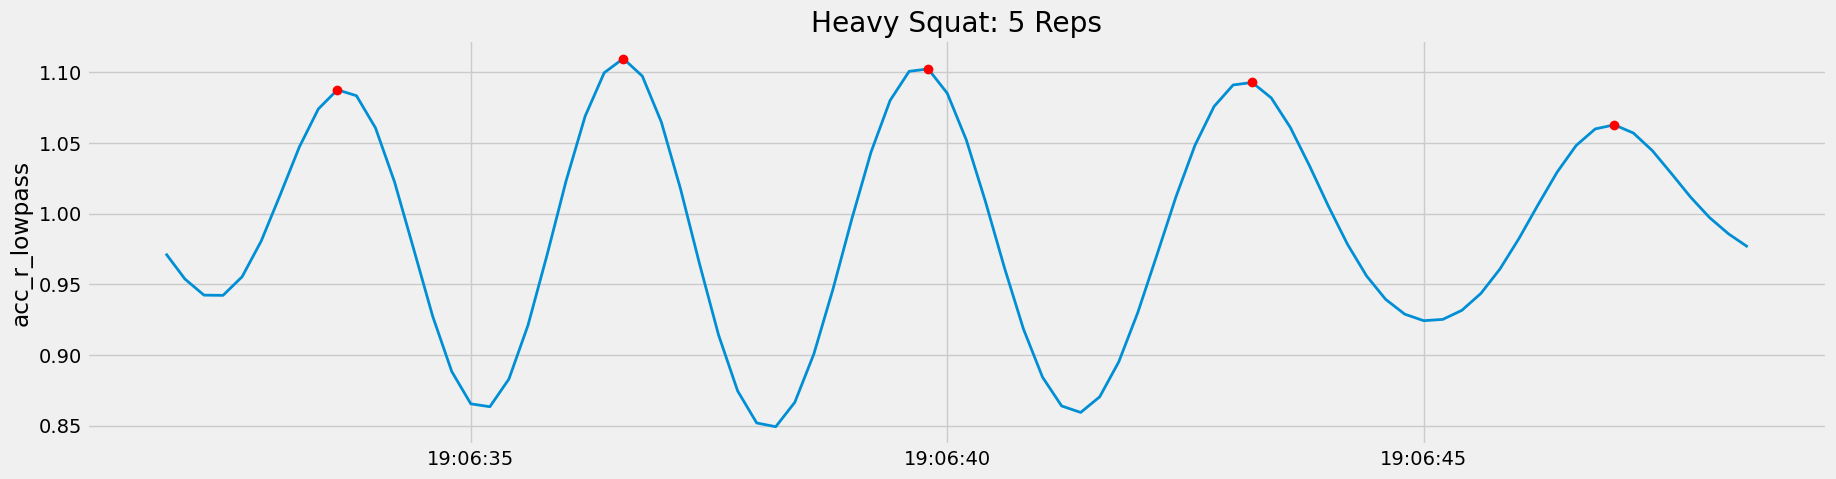

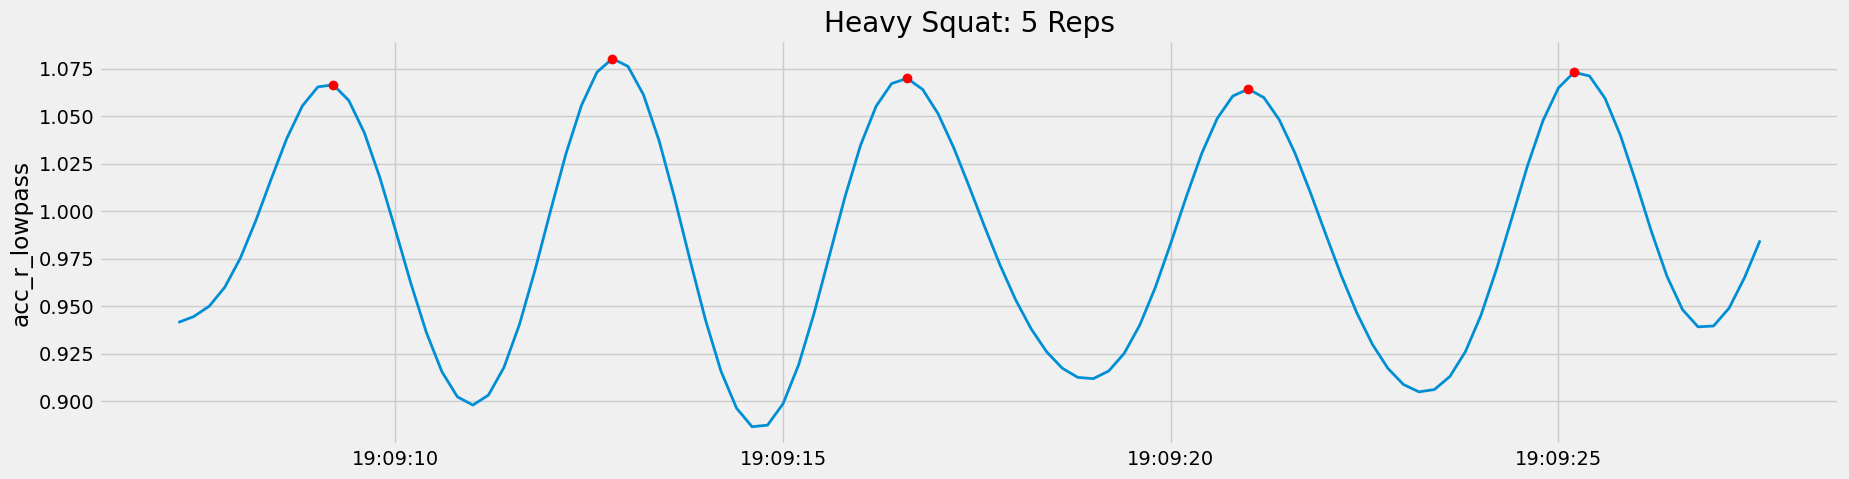

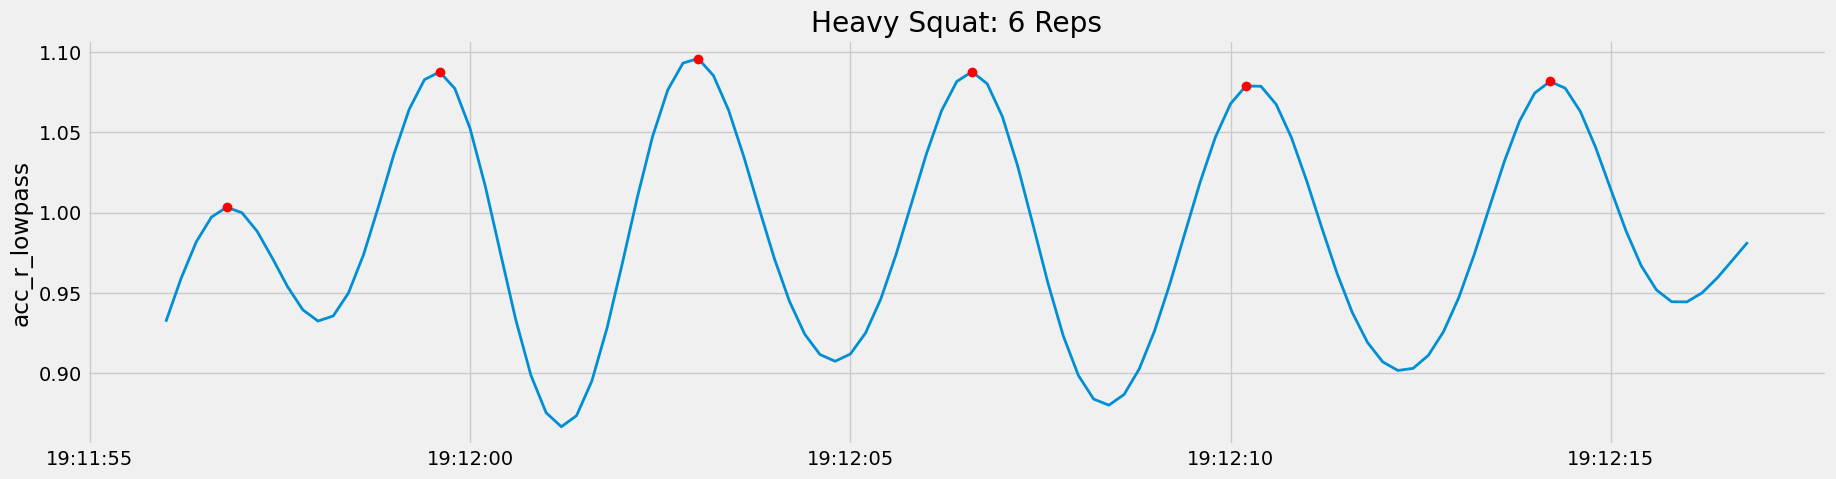

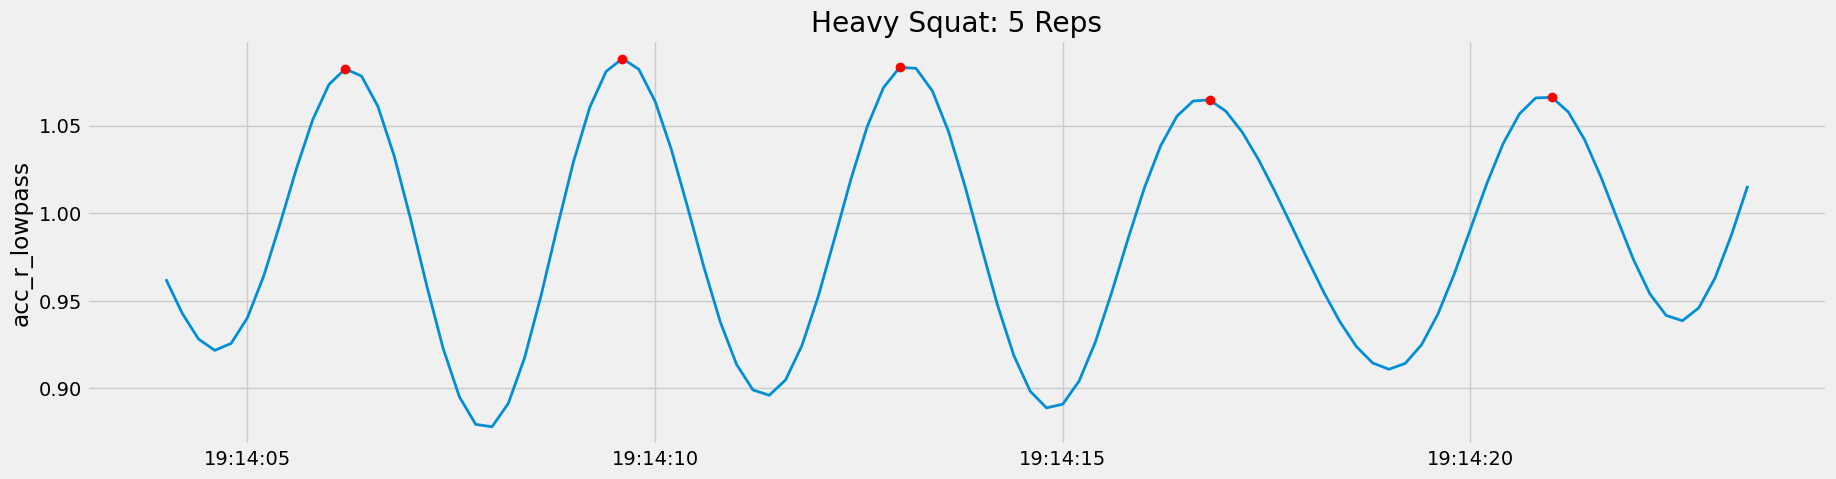

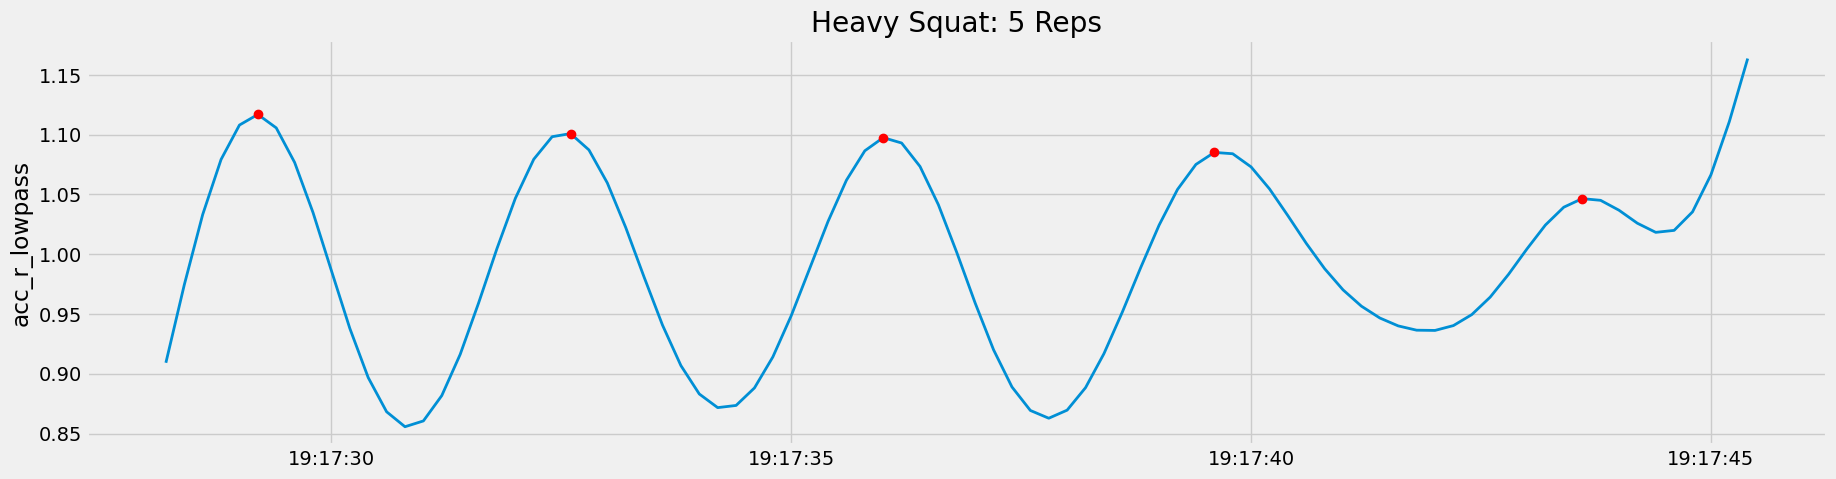

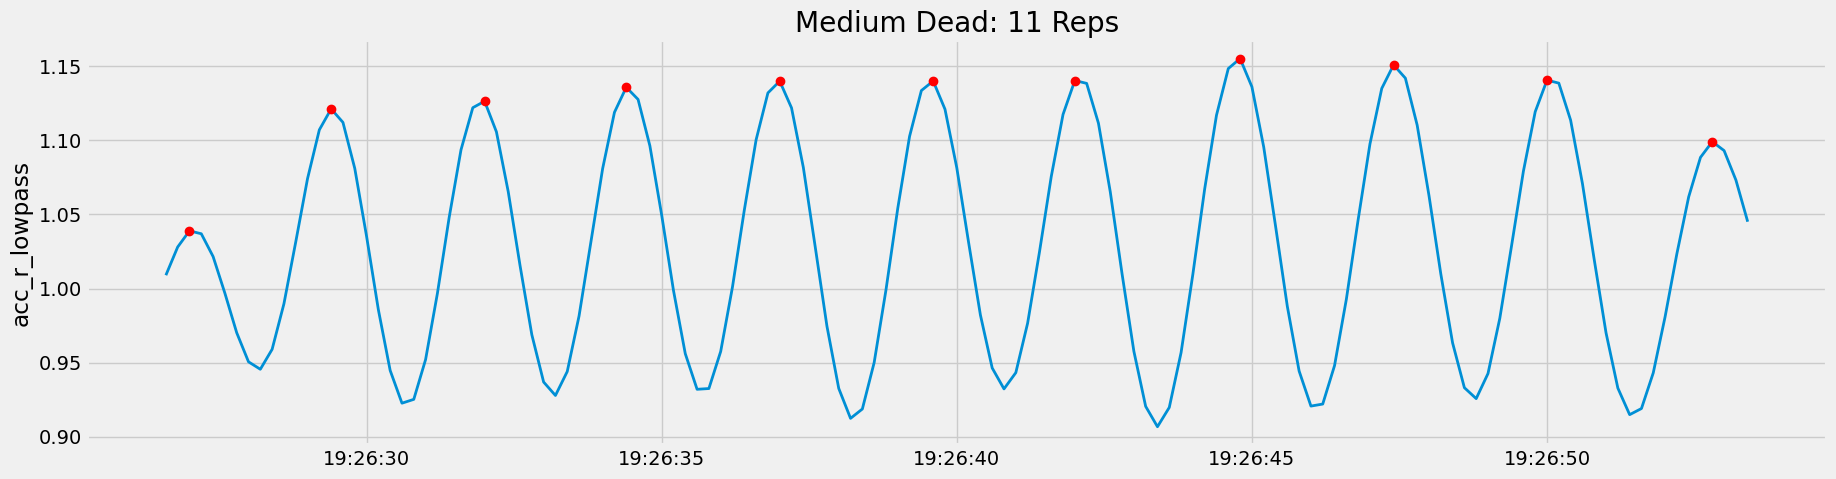

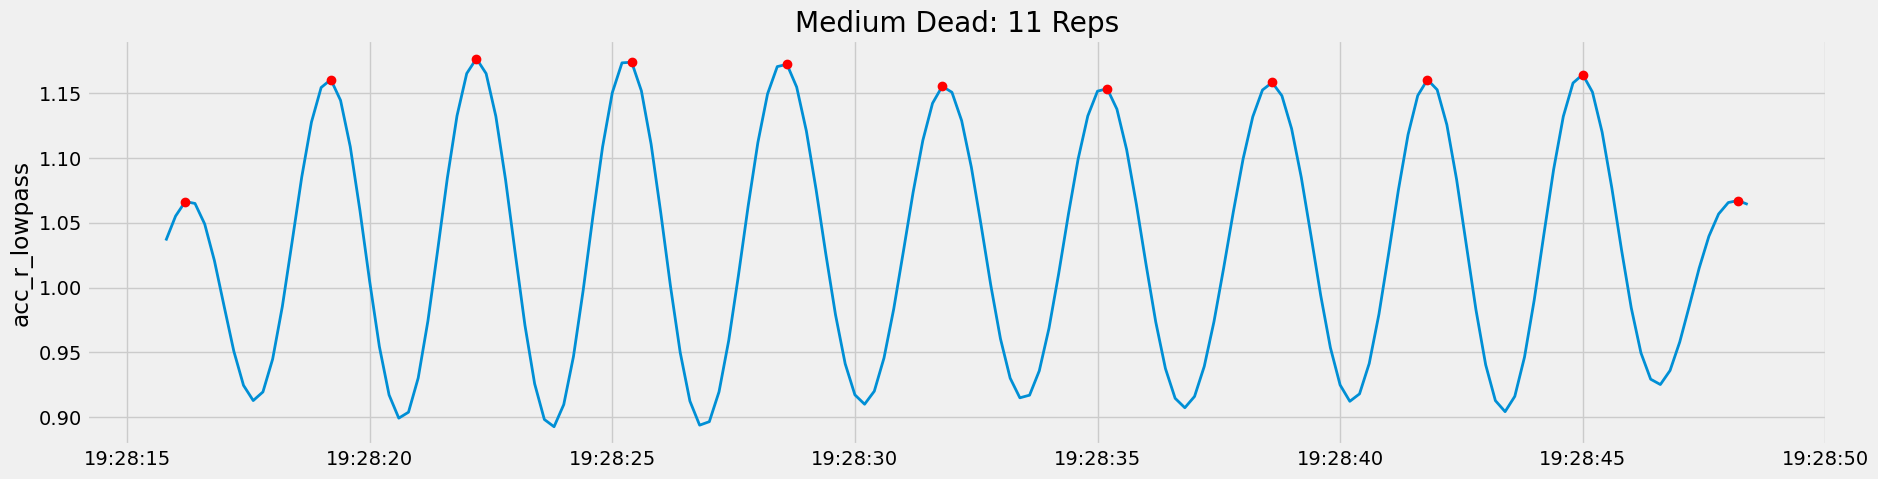

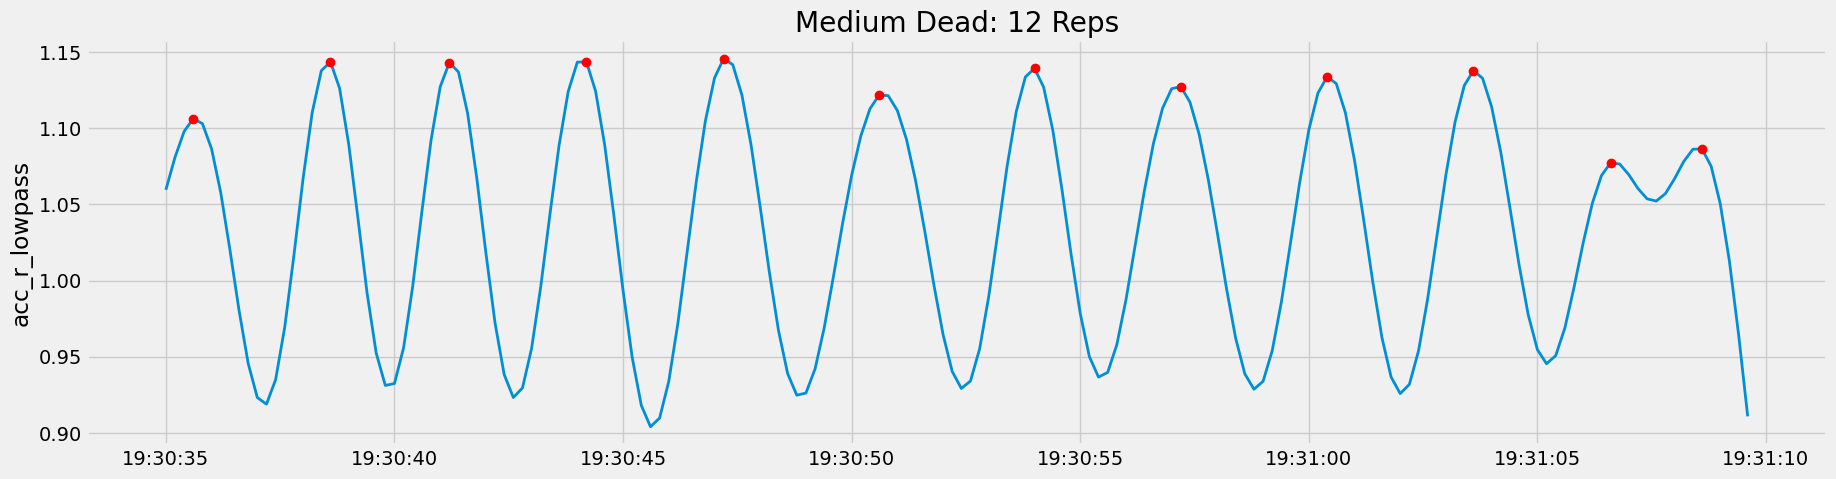

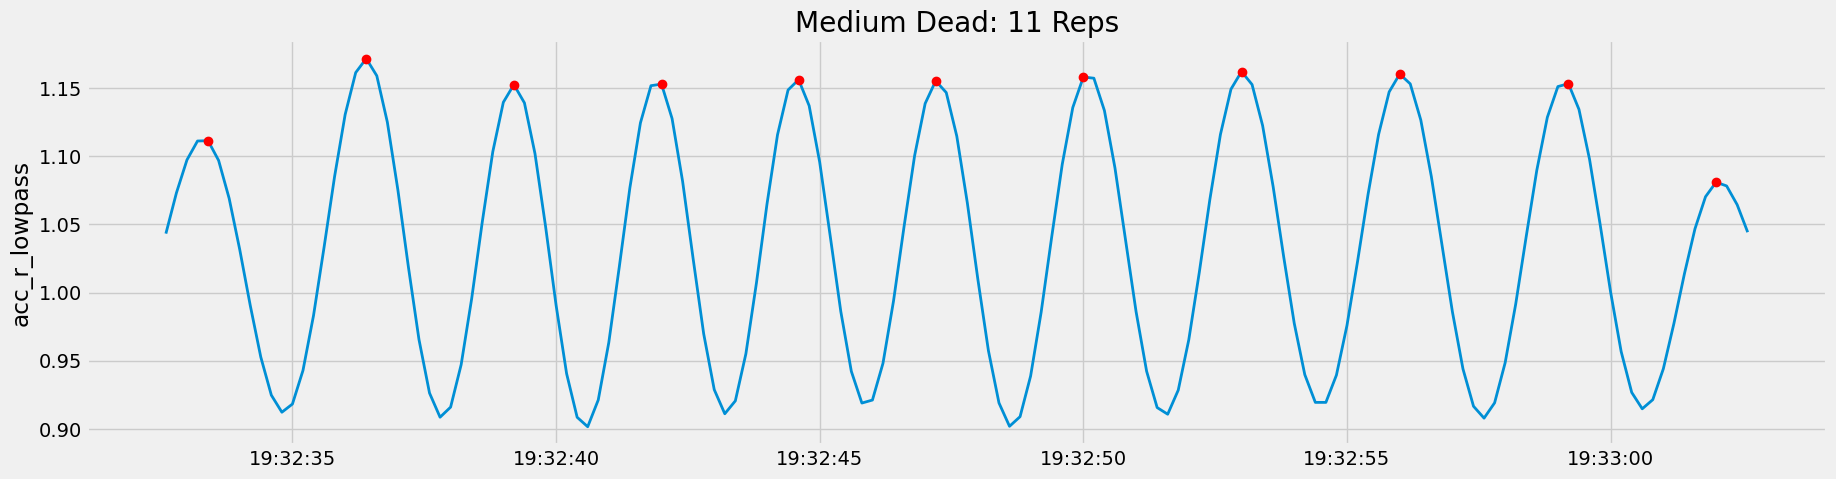

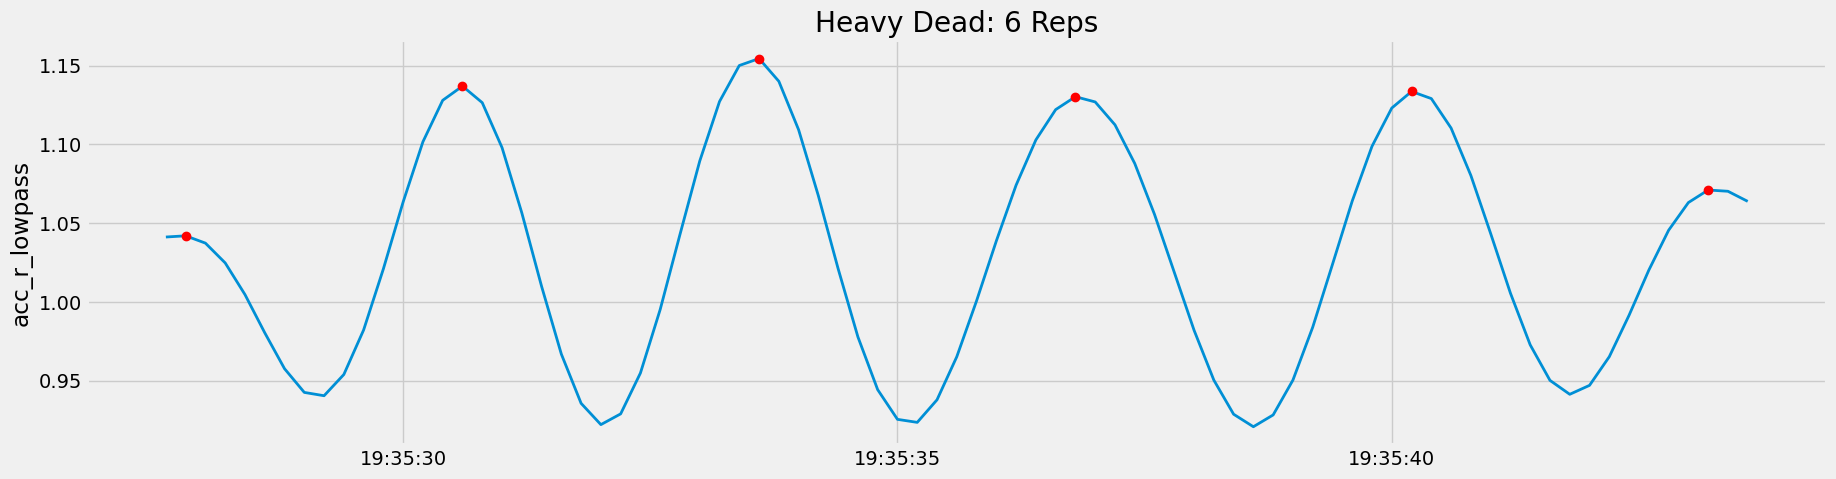

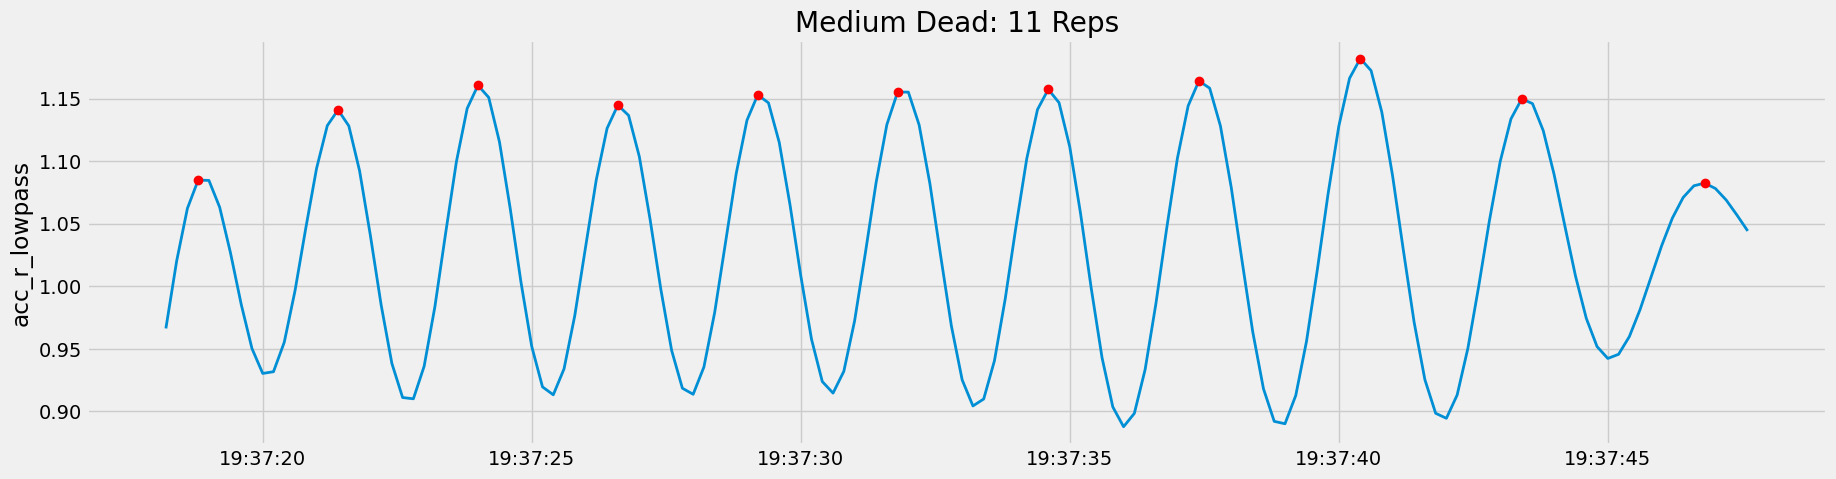

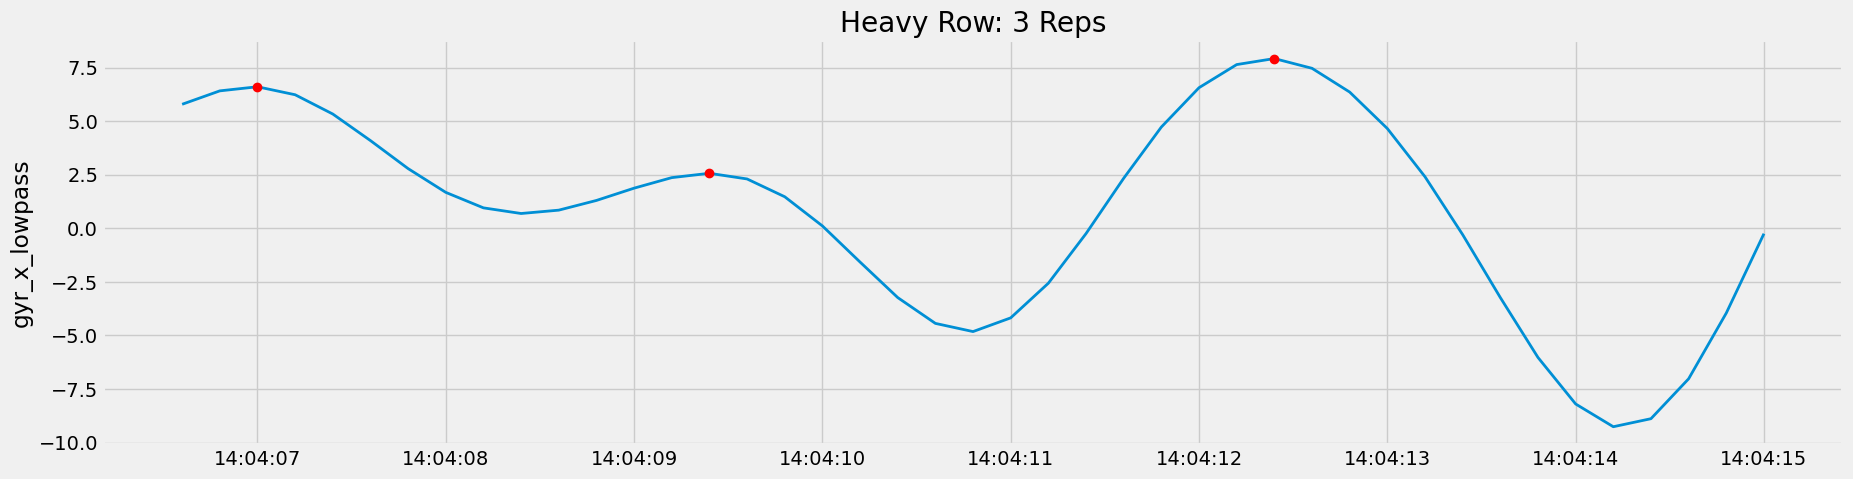

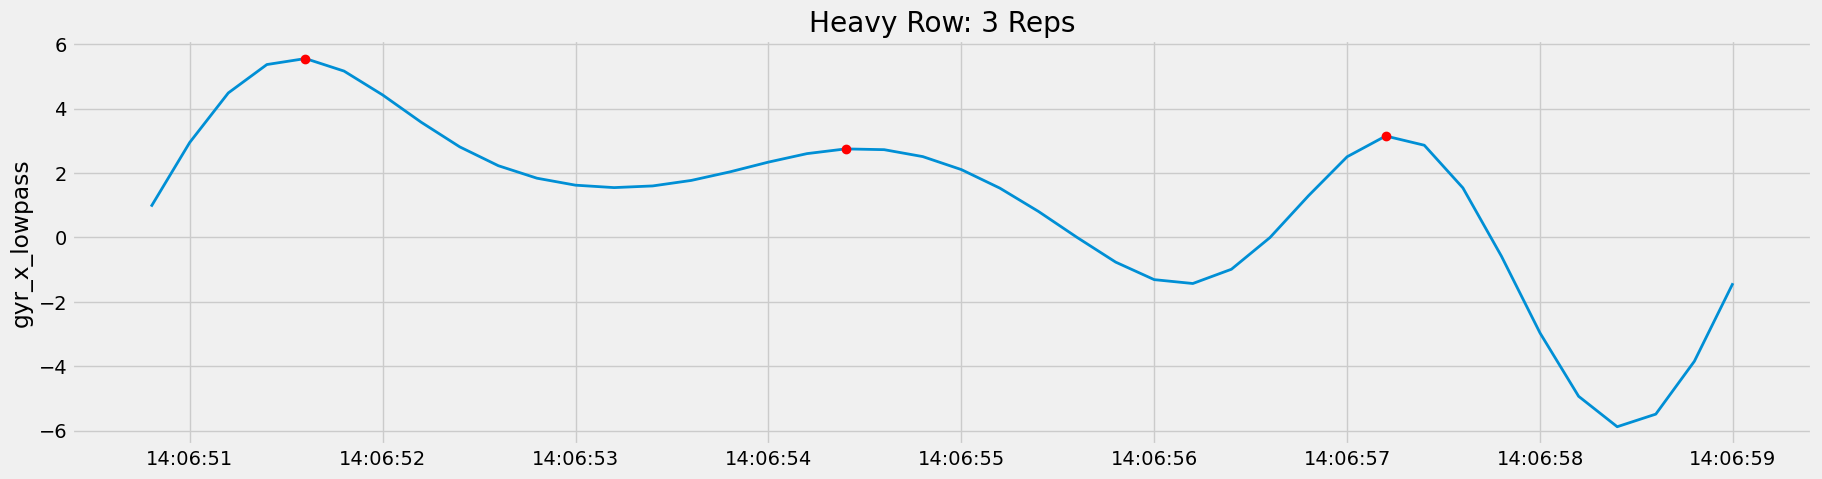

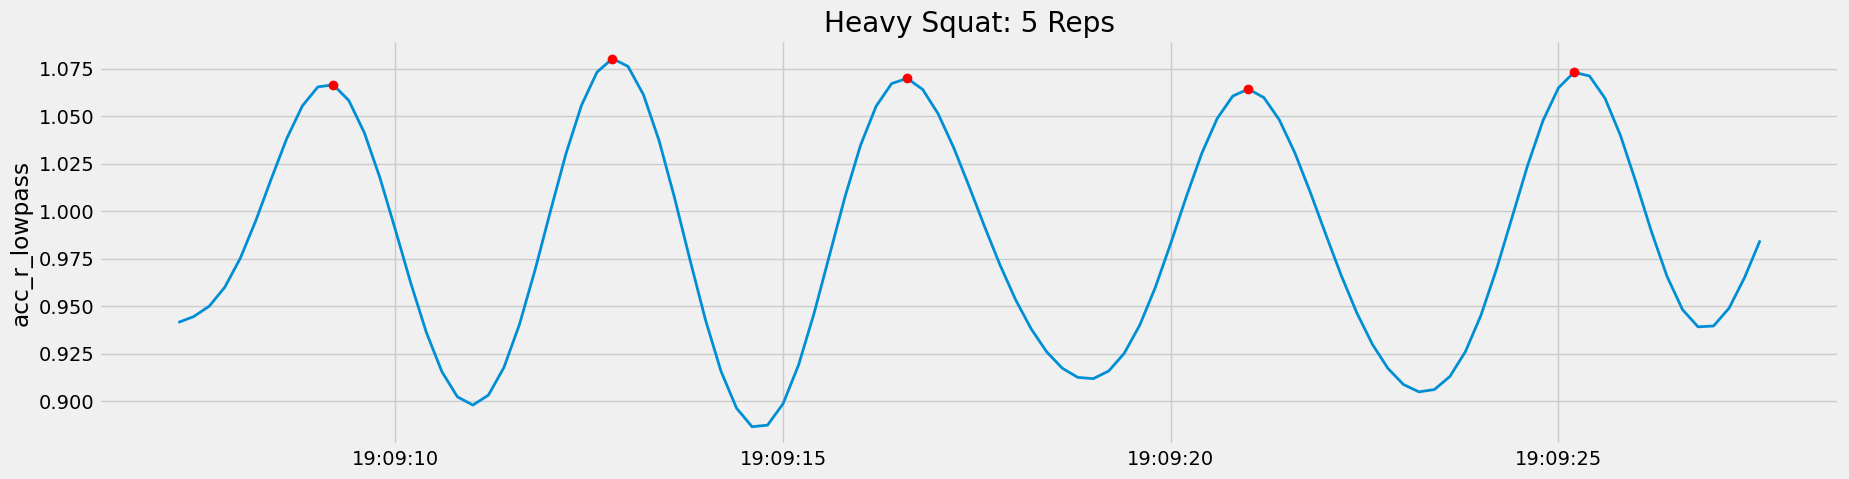

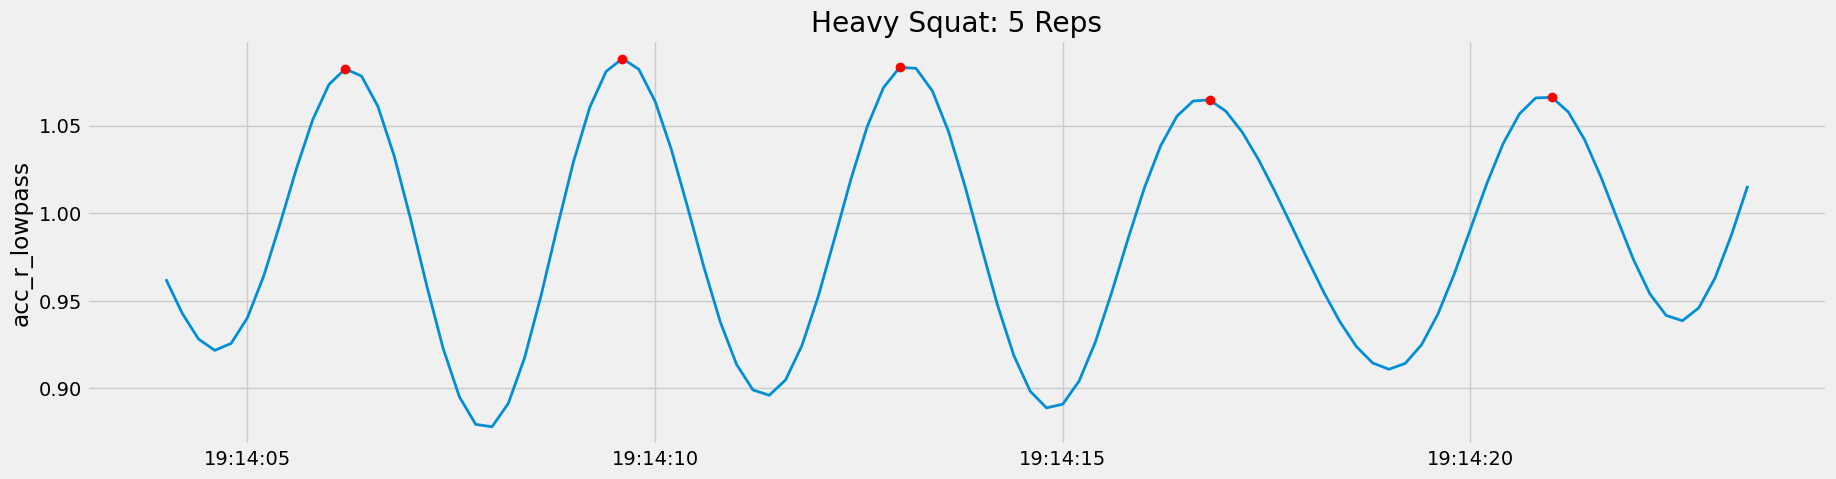

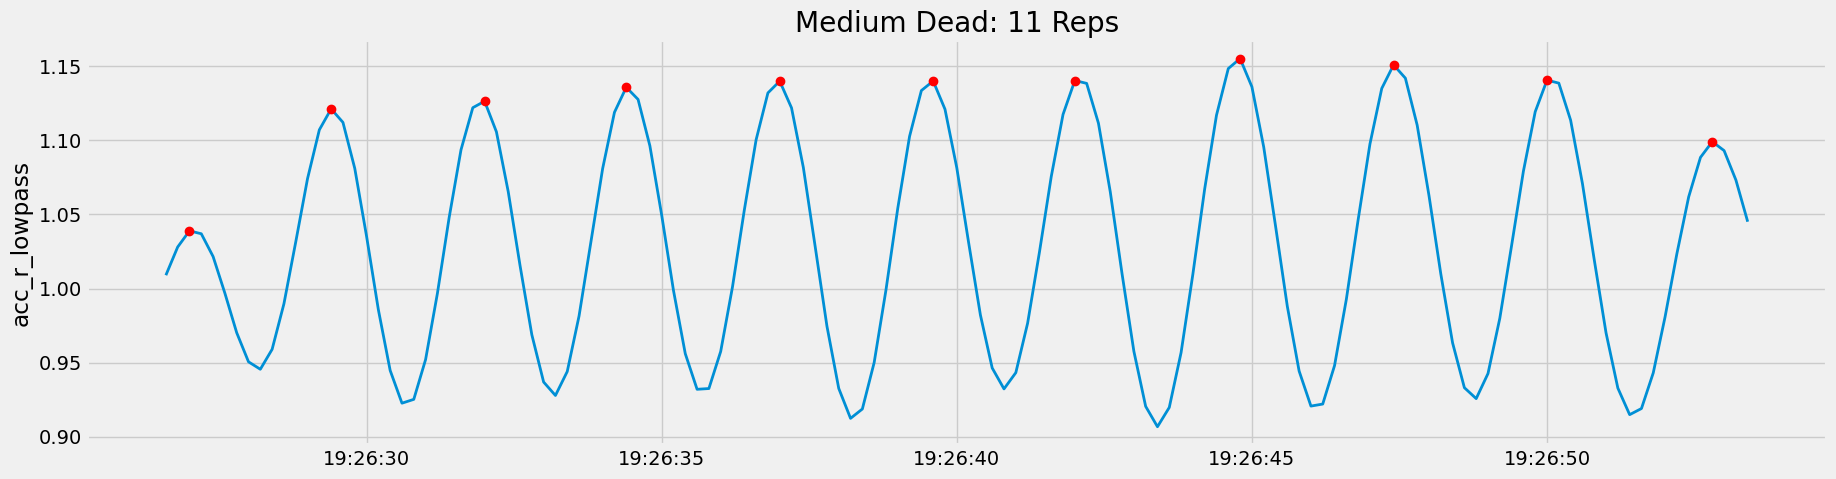

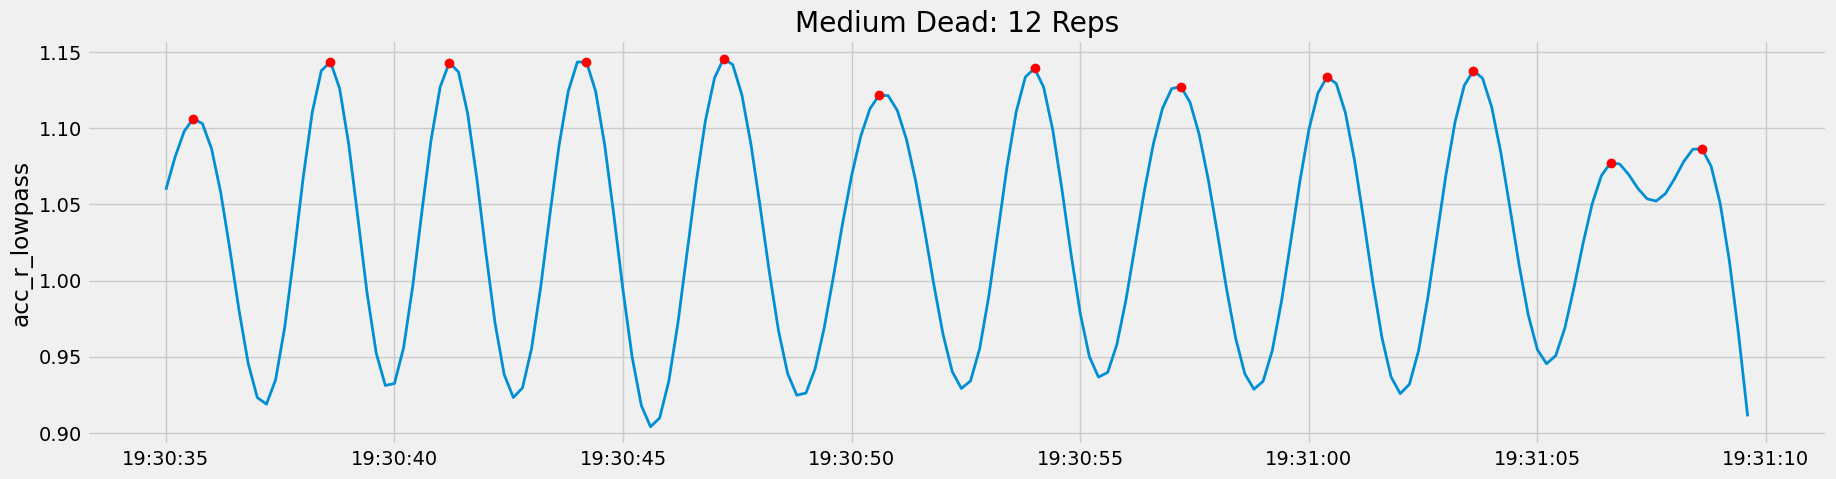

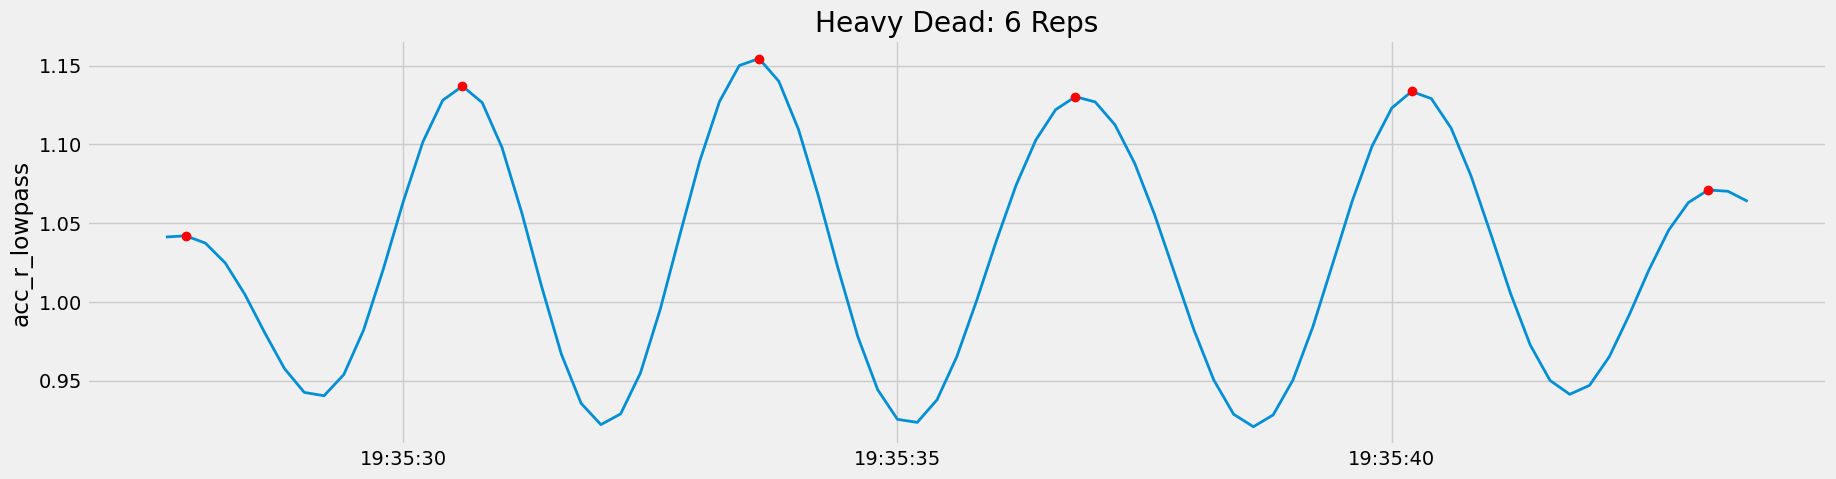

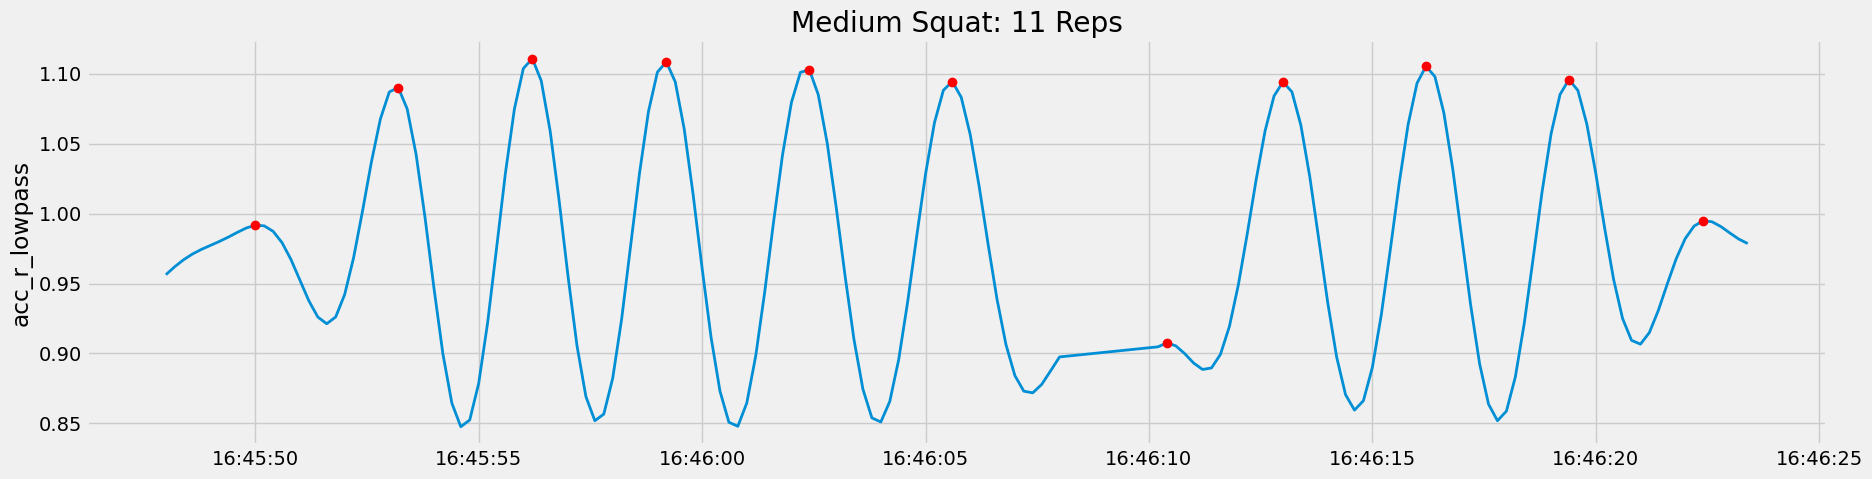

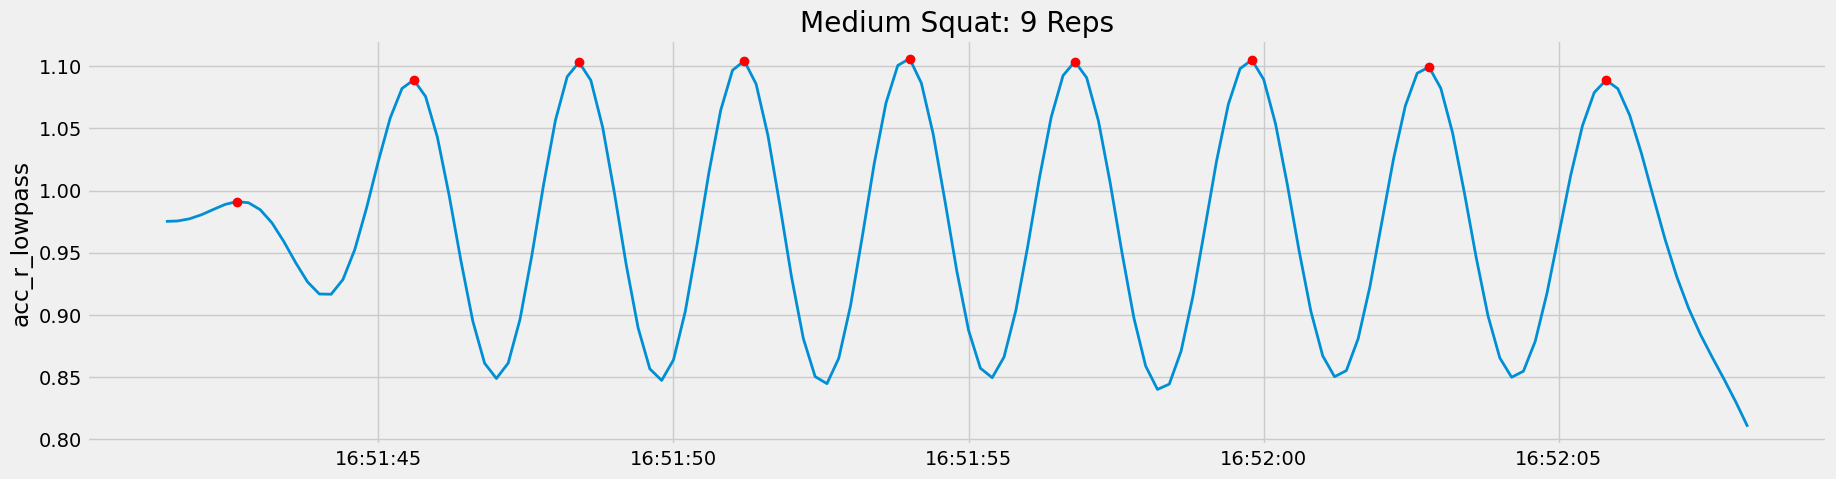

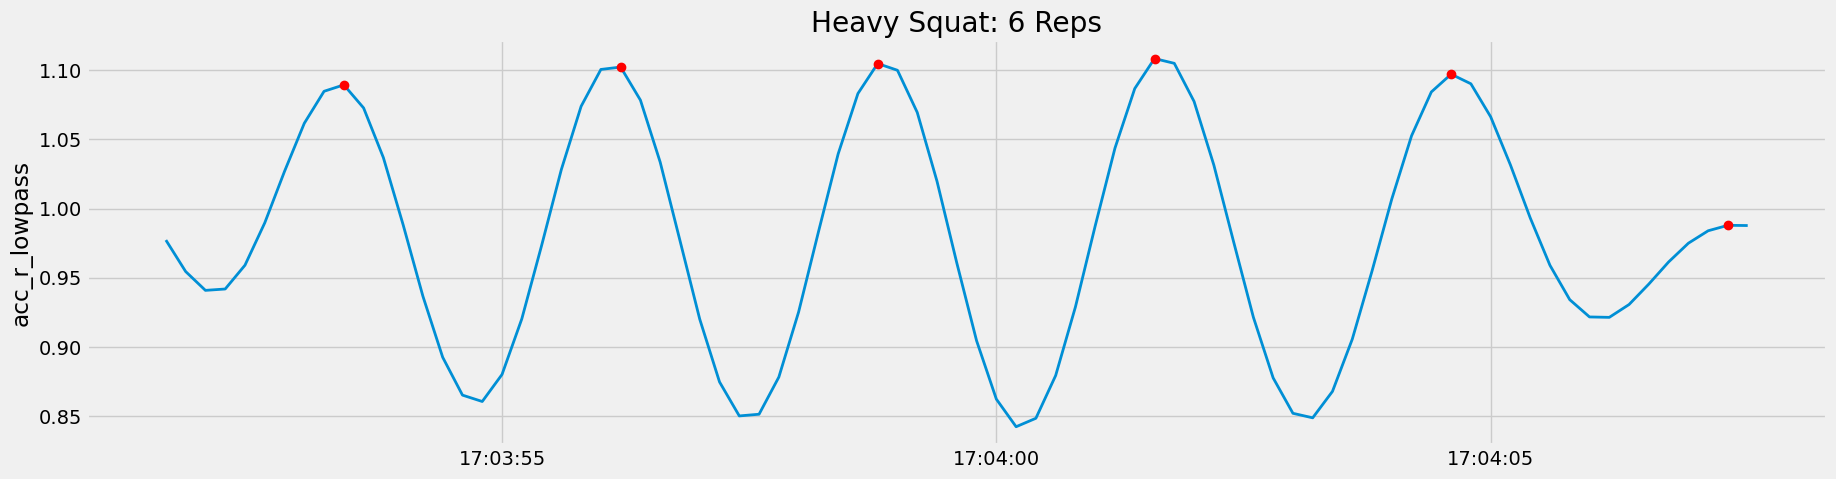

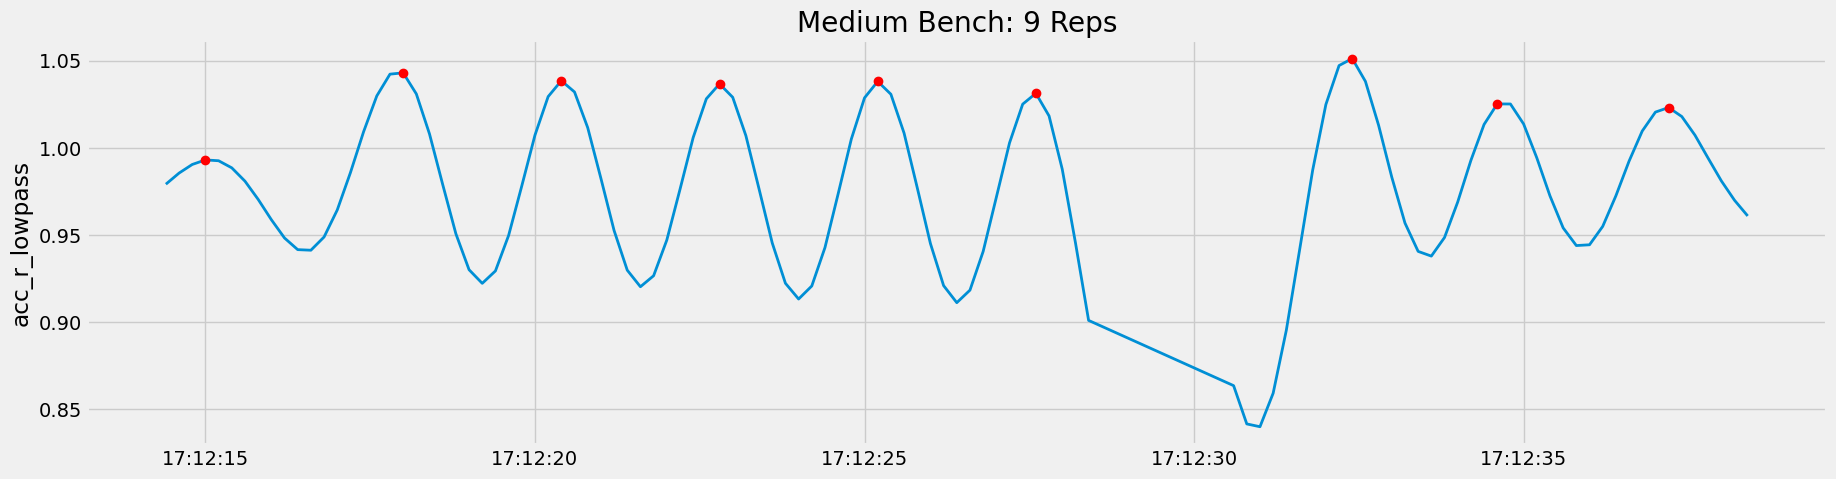

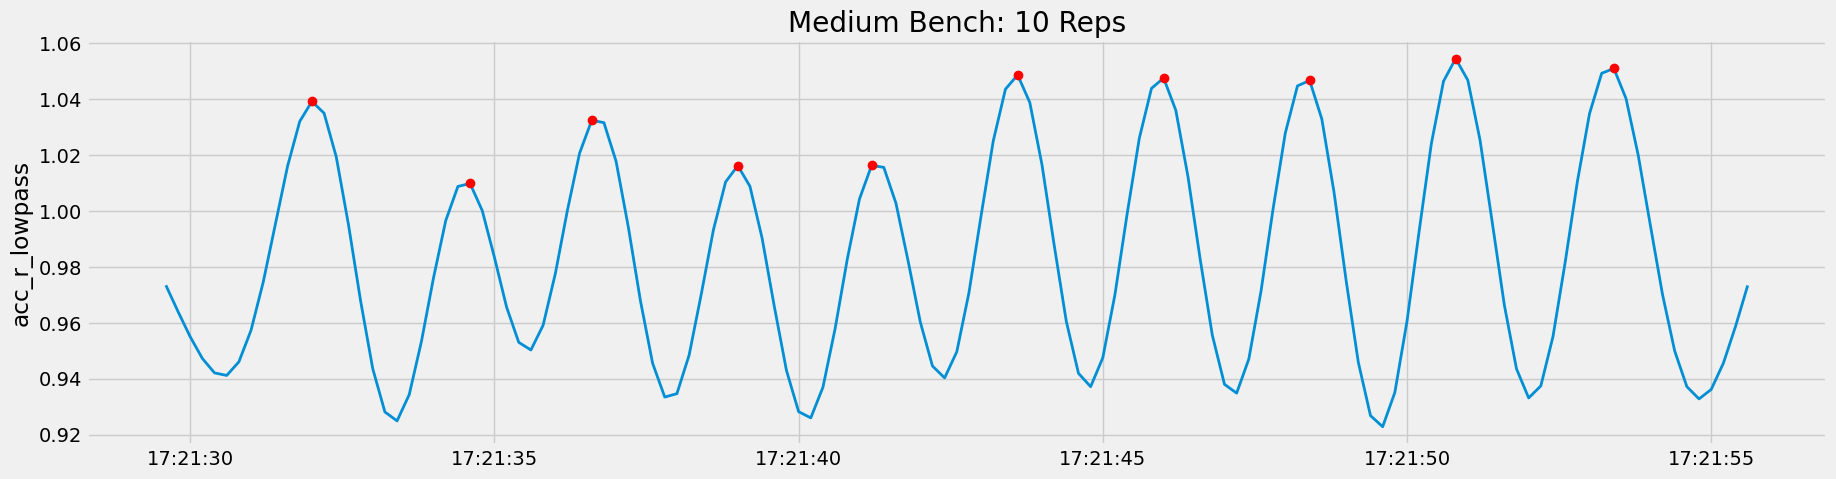

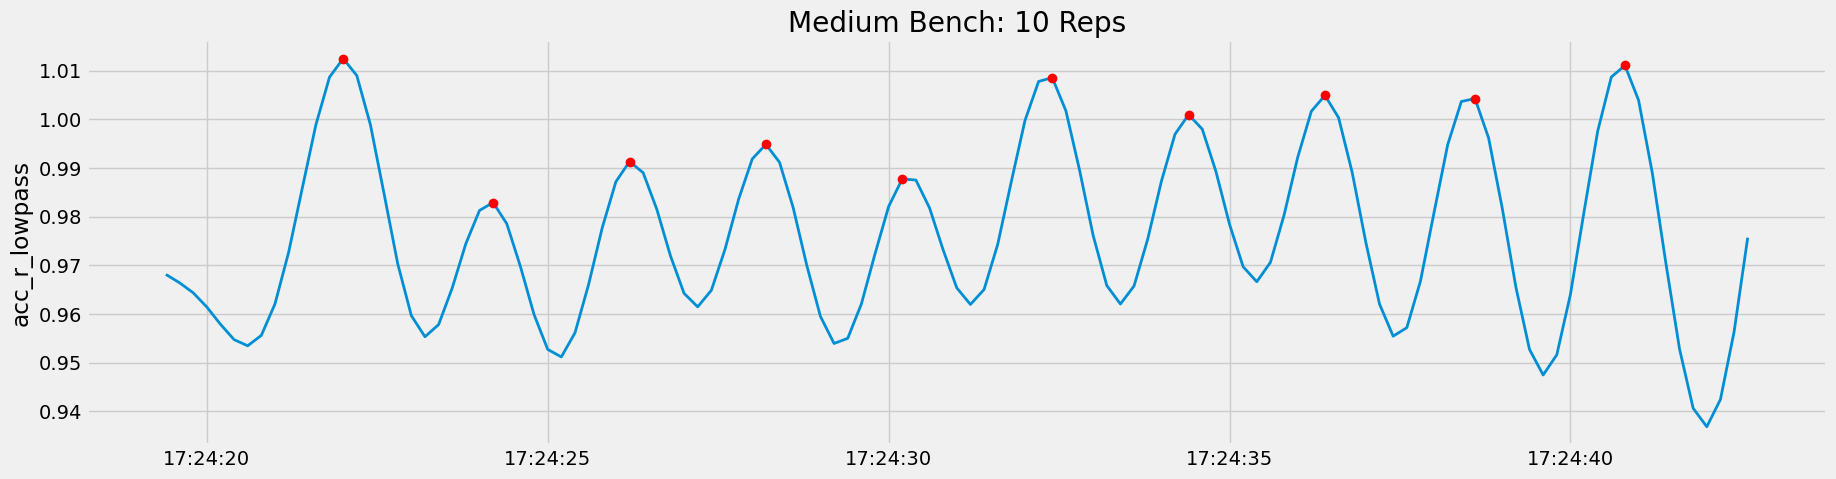

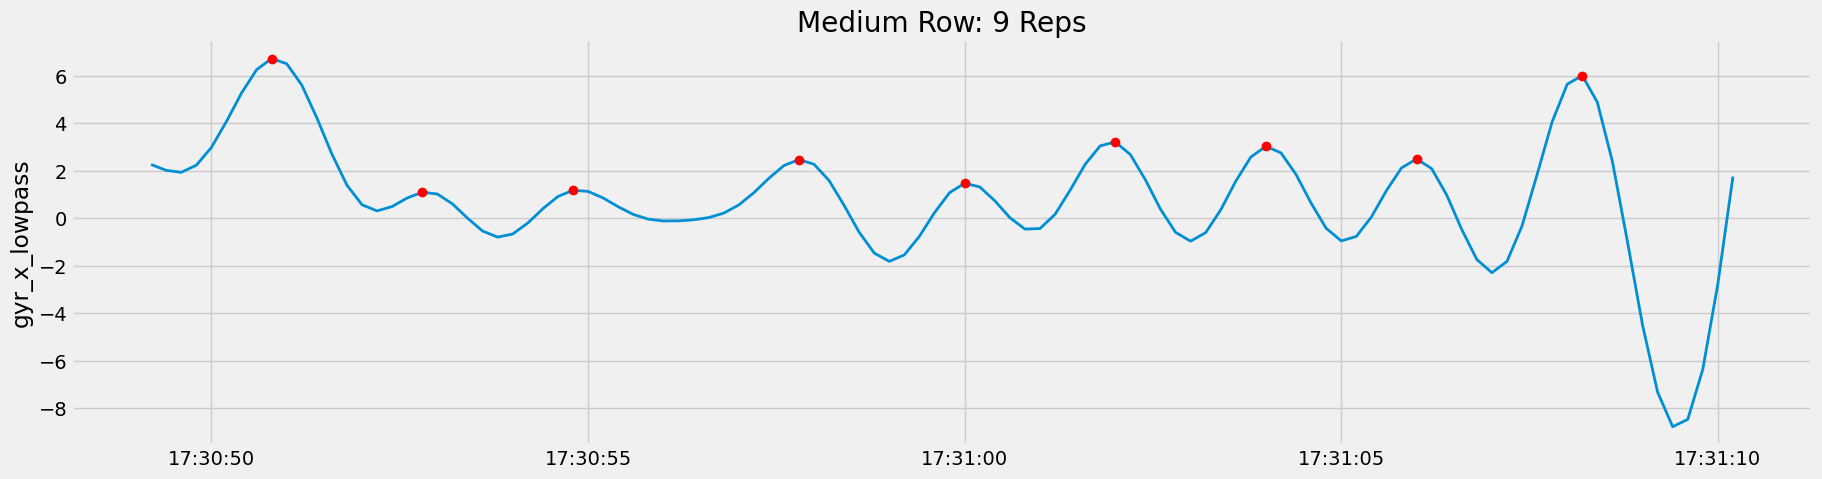

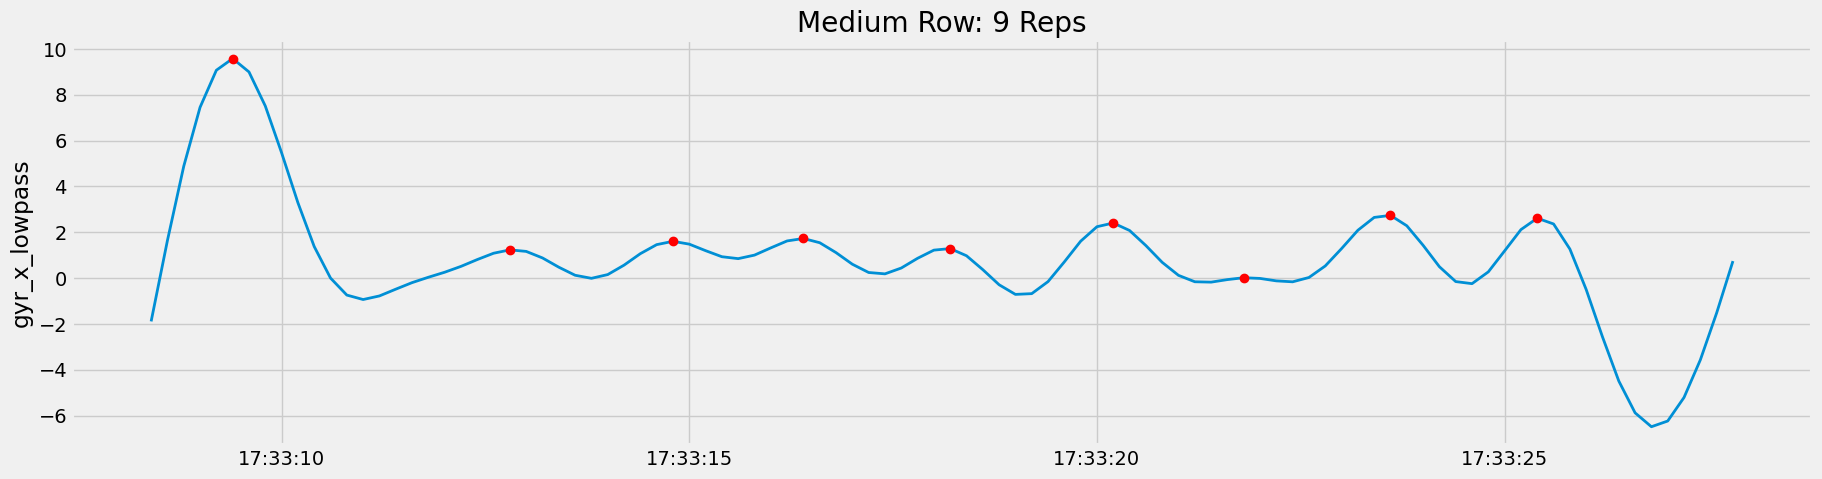

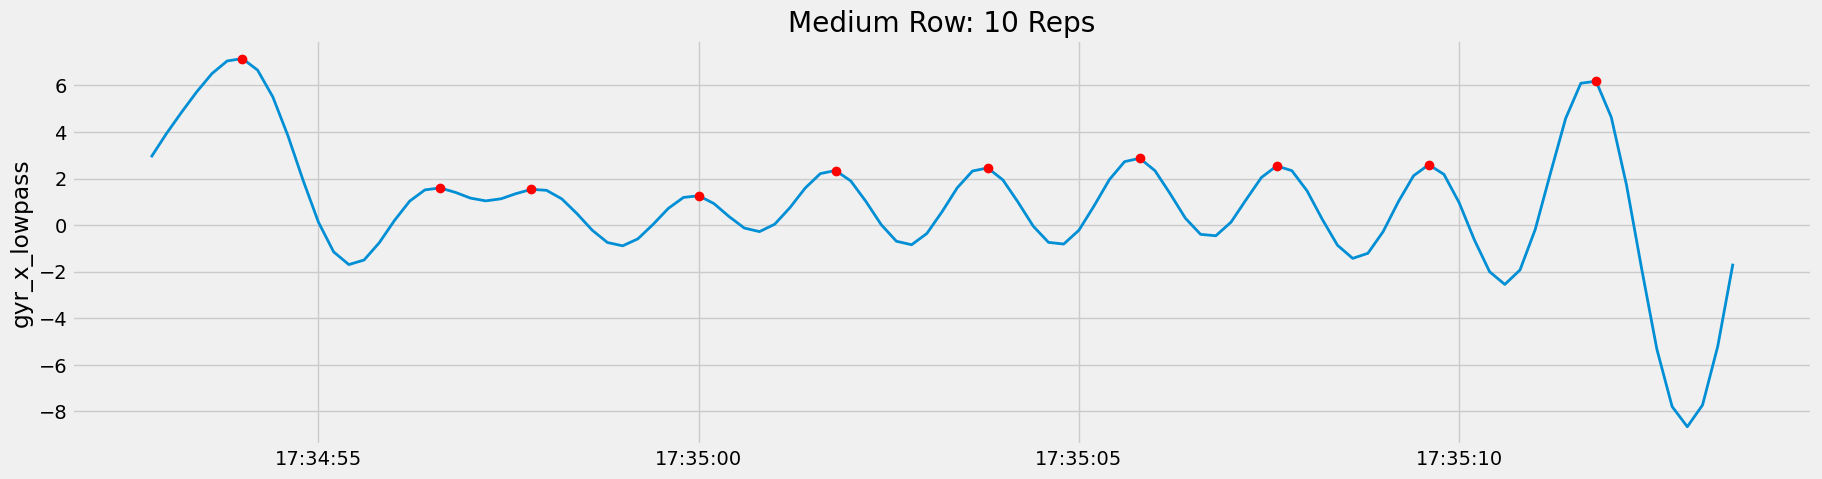

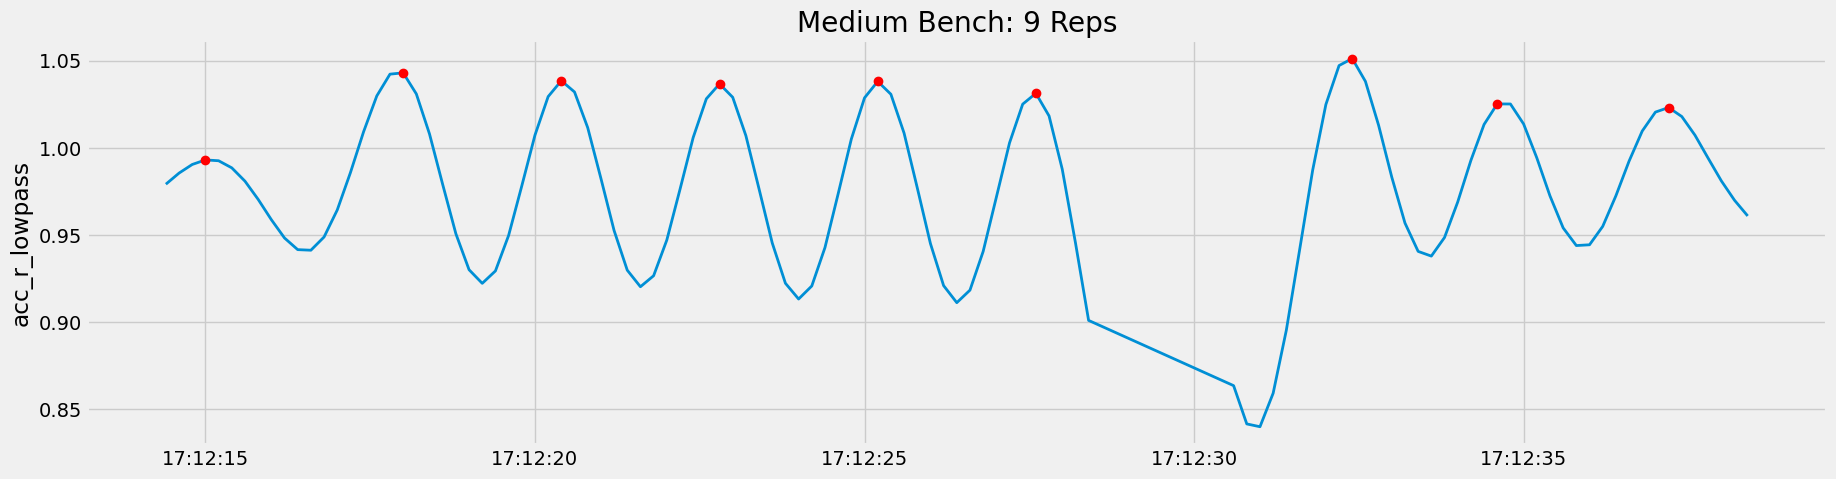

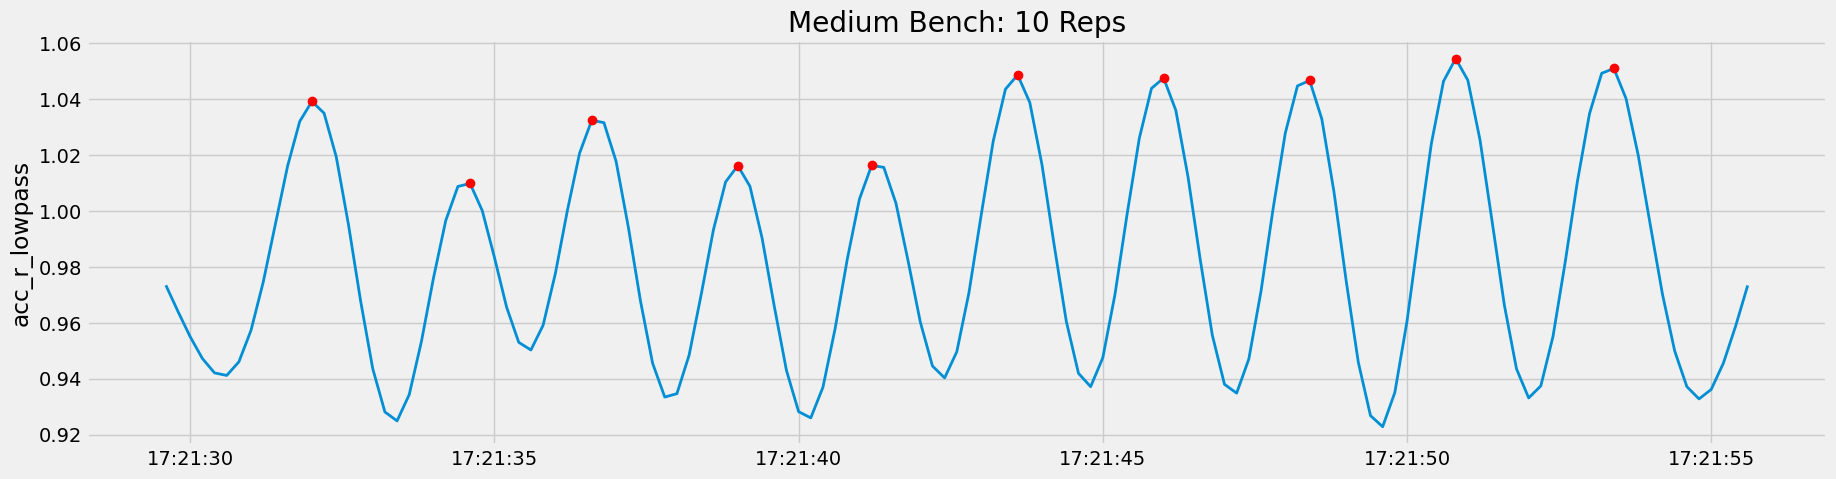

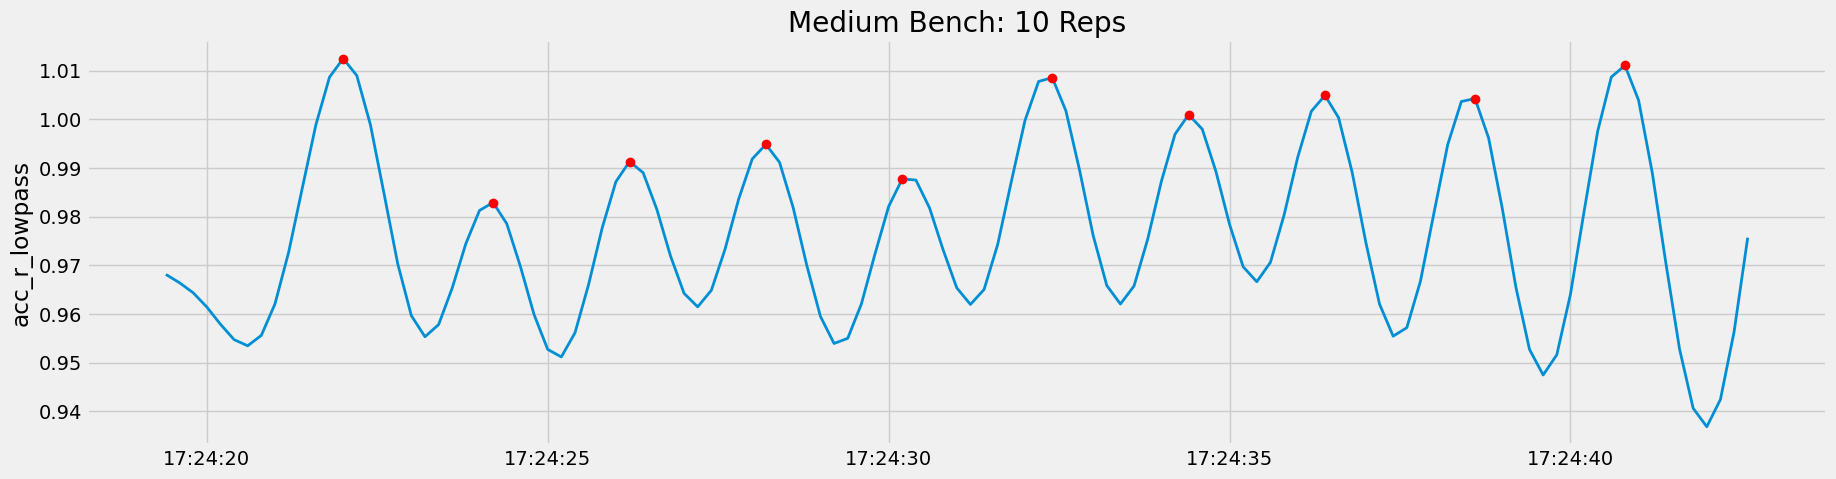

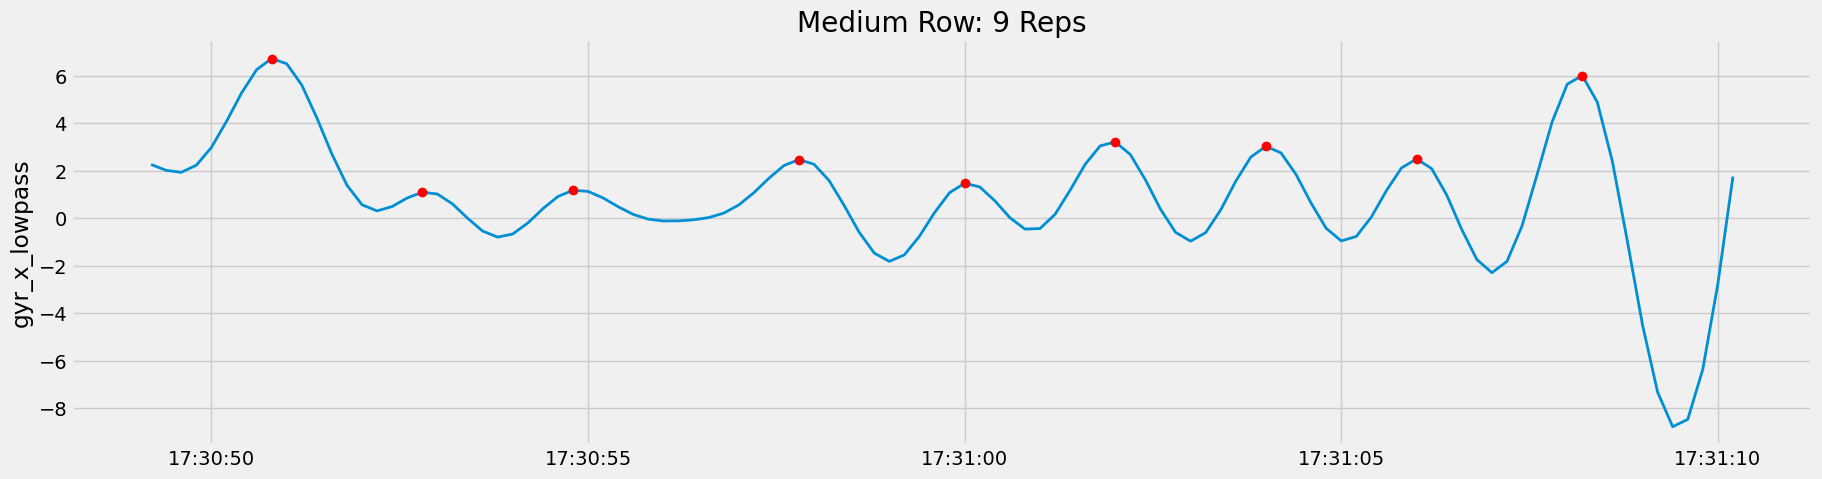

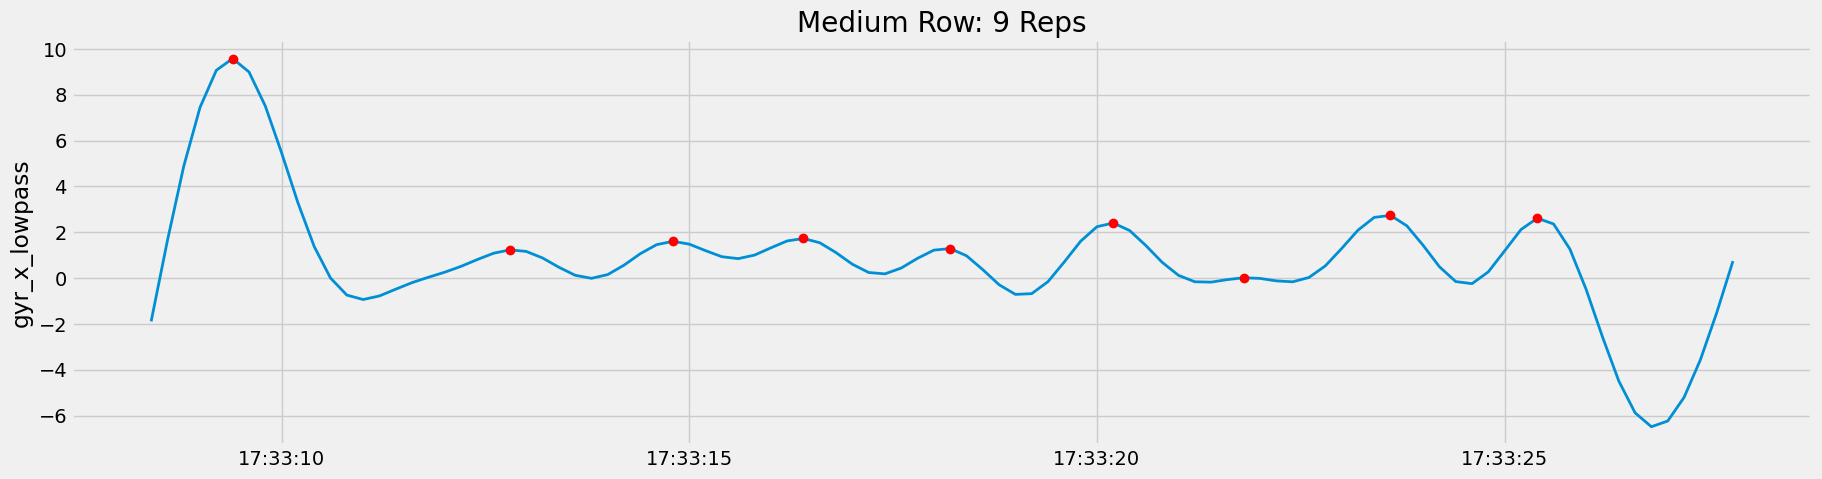

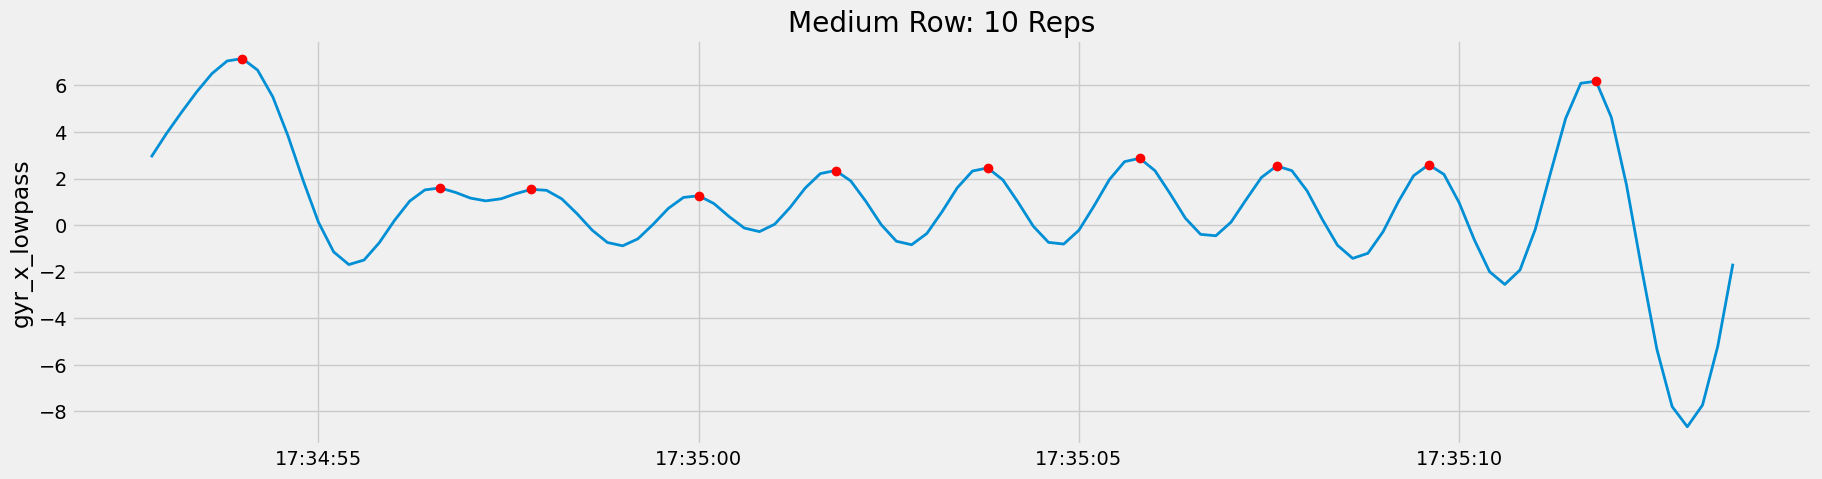

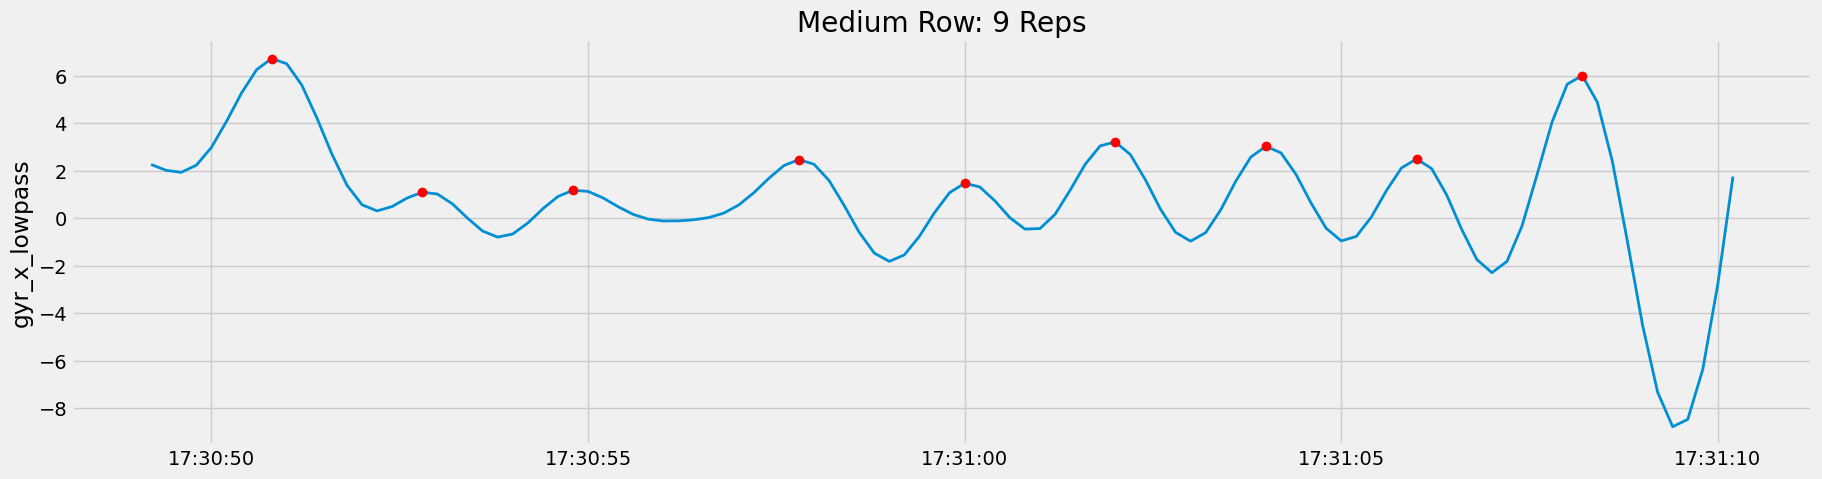

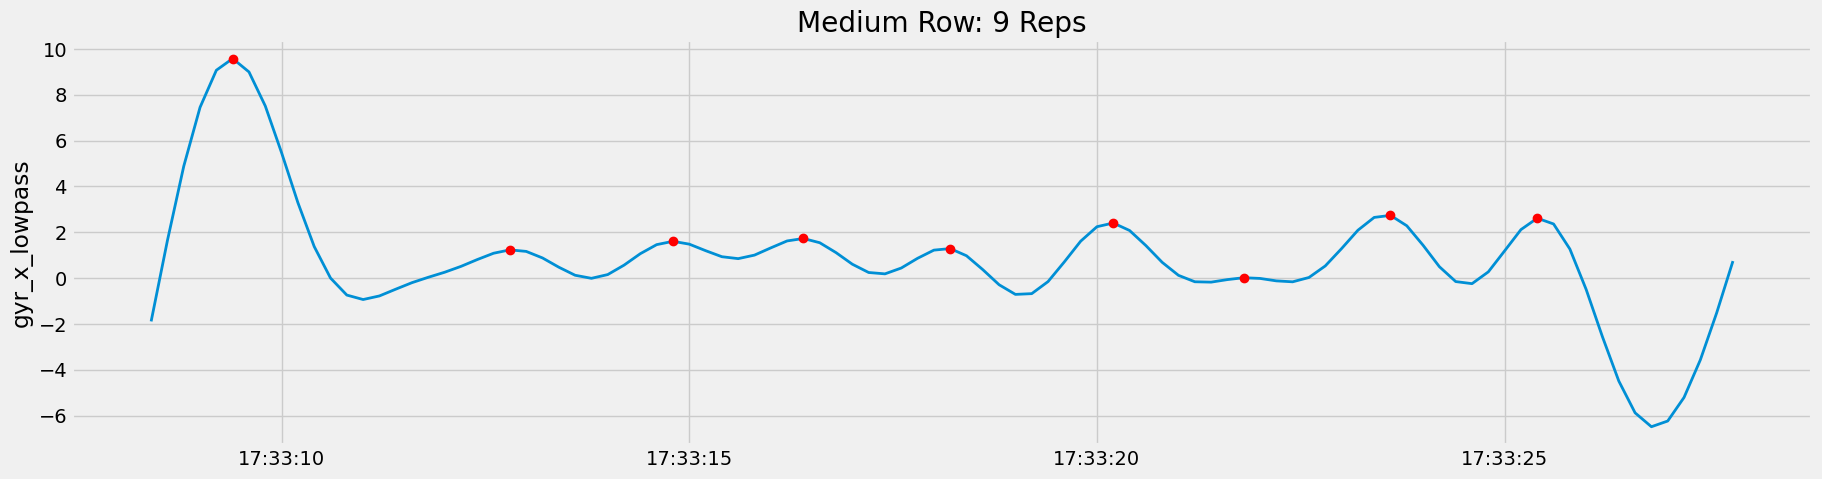

In [22]:
rep_df = df.groupby(["label", "category", "set"])["reps"].max().reset_index()
rep_df["reps_pred"] = 0

for s in df["set"].unique():
    subset=df[df["set"]==s]
    column="acc_r"
    cutoff = 0.4
    if subset["label"].iloc[0] == "squat":
        cutoff =  0.35
    if subset["label"].iloc[0]== "row": 
        cutoff = 0.65
        column = "gyr_x"
    if subset["label"].iloc[0]== "ohp":
        cutoff = 0.35
    reps = count_rep(subset, cutoff=cutoff, column = column)
    rep_df.loc[rep_df["set"] == s, "reps_pred"] = reps


In [23]:
rep_df

label category  set  reps  reps_pred
0   bench    heavy    1     5          5
1   bench    heavy    2     5          5
2   bench    heavy    3     5          5
3   bench    heavy    4     5          5
4   bench    heavy   30     5          4
..    ...      ...  ...   ...        ...
80  squat   medium   28    10         10
81  squat   medium   29    10         11
82  squat   medium   38    10          7
83  squat   medium   63    10         11
84  squat   medium   64    10          9

[85 rows x 5 columns]

# Evaluate the results

C:\Users\hp\AppData\Local\Temp\ipykernel_8224\3733062091.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rep_df.groupby(["label", "category"])["reps", "reps_pred"].mean().plot.bar()


0.93

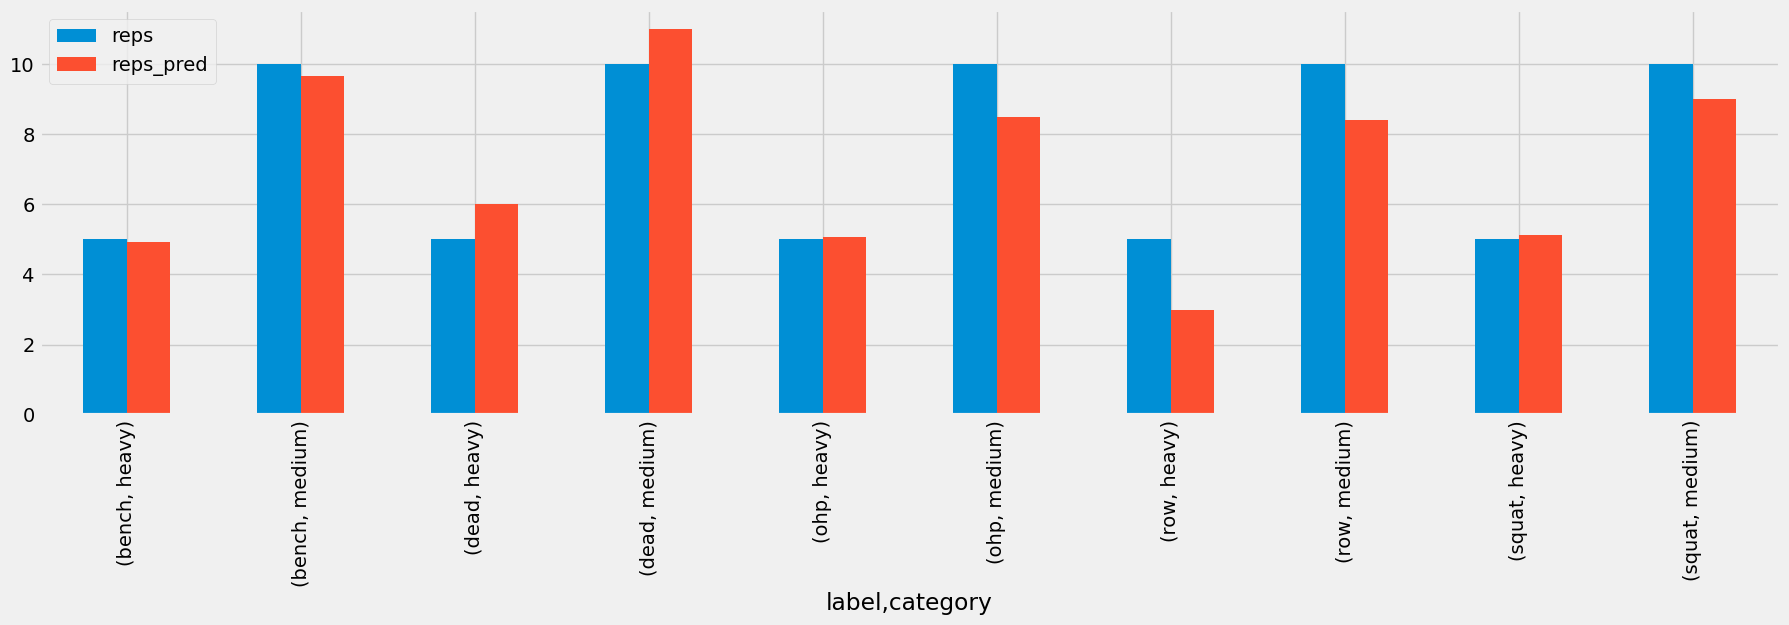

In [29]:
error = mean_absolute_error(rep_df["reps"], rep_df ["reps_pred"]).round(2) 
rep_df.groupby(["label", "category"])["reps", "reps_pred"].mean().plot.bar()
error